In [247]:
import pandas as pd
import numpy as np
# import torch
from pandasql import sqldf
from itertools import product

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split  # For splitting the train set
from sklearn.preprocessing import OrdinalEncoder
# 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

from sklearn.svm import SVC

from sklearn.datasets import load_iris

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score, pairwise_distances
import matplotlib.pyplot as plt

import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)         # for single-GPU
    torch.cuda.manual_seed_all(seed)     # for multi-GPU (if used)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
GLOBAL_CUTOFFS = {}
for a, b in pd.read_csv('cutoffs.csv').values:
    GLOBAL_CUTOFFS[a] = b
    # break

# cutoffs


In [452]:
X_6, y_6 , emb_list, real_size, encoder  = load_6(binary=True, cutoffs=cutoffs, qcut=False)
X_2, y_2 , emb_list, real_size, encoder  = load_2(binary=True, cutoffs=cutoffs, qcut=False)


# New Data

## 2

In [528]:
def load_2(binary=True, cutoffs=None, qcut=False, include_pid=False):
    df = pd.read_csv('Leidos_data_98_Abs_with_clinical_features_v2.csv')
    
    if cutoffs is None and qcut:
        for i, column in enumerate(df.columns[12:]):
            df['qcut_'+column] = pd.qcut(df[column], q=3)
            
    
    
    group = 'B0_Group'
    which = group.split('_')[0]
    pre = df[df[group] == f'Pre {which}']
    post = df[df[group] == f'Post {which}']
    
    result = pd.merge(pre, post, on="PID", how="inner")
    
    
    exclude_hiv = True
        
    if exclude_hiv:
            x_cols = ['Cohort_x'] + [i for i in result.columns[7:] if ('_x' in i and 'HIV' not in i)]
    else:
        x_cols = ['Cohort_x'] + [i for i in result.columns[7:] if '_x' in i] 
    
    data = result[x_cols + ['Vaccine_Response_class_y'] + ['Vaccine_Response_raw_y']].dropna()
    X = data[x_cols].values
    
    if cutoffs is not None:
        thresholds = []
        cutoff_cols = list(map(lambda z: z[:-2], x_cols))[6:]
        for c in cutoff_cols:
            thresholds.append(cutoffs[c])
        thresholds = np.array(thresholds)

        I = (X[:, 6:] >= thresholds).astype(float)                # same shape [batch_size, d]
        h = np.maximum(0.0, X[:, 6:] - thresholds)     # same shape
        X_aug = np.concatenate([X, I, h], axis=1)
        X = X_aug
        
        
    
    
    if binary:
        y = (data['Vaccine_Response_class_y'] == 'High').astype(int).values
    else:
        y = data['Vaccine_Response_raw_y'].values
    
    if qcut:
        cat_cols = [0, 2, 3, 4, 5] + list(range(X.shape[-1] - 98, X.shape[-1]))
    else:
        cat_cols = [0, 2, 3, 4, 5]
    
    
    X_cat = X[:, cat_cols]
    
    X_real = np.delete(X, cat_cols, axis=1)
    X_cat, X_real
    
    encoder = OrdinalEncoder()
    X_cat_encoded = encoder.fit_transform(X_cat)
    
    X_processed = np.hstack([X_cat, X_cat_encoded, X_real])
    
    # for j, xx in enumerate(X_processed[0]):
    #     print(j, xx)
    
    if qcut:
        emb_list = list(X_processed[:, 103:206].max(0).astype(int) + 1)
        real_size = X_processed.shape[1] - 206
    else:
        emb_list = list(X_processed[:, 5:10].max(0).astype(int) + 1)
        real_size = X_processed.shape[1] - 10
    
    
    
    if not include_pid:
        return X_processed, y, emb_list, real_size, encoder
    else:
        a = result[['PID'] + x_cols + ['Vaccine_Response_class_y'] + ['Vaccine_Response_raw_y']].dropna()
        return X_processed, y, a['PID'].values, emb_list, real_size, encoder


a = load_2(qcut=False, cutoffs=None) 
b = load_2(qcut=True, cutoffs=None)
c=load_2(cutoffs=GLOBAL_CUTOFFS)
a[-2], len(a[2]), b[-2], len(b[2]), c[-2], len(c[2])

(99, 5, 99, 103, 295, 5)

## 6

In [531]:
def load_6(binary=True, cutoffs=None, qcut=False, include_pid=False):
    df = pd.read_csv('Leidos_data_98_Abs_with_clinical_features_v2.csv')
    if cutoffs is None and qcut:
        for i, column in enumerate(df.columns[12:]):
            df['qcut_'+column] = pd.qcut(df[column], q=3)
    
    group = 'B0_Group'
    which = group.split('_')[0]
        
    post = df[df[group] == f'Post {which}']
    
    data = post[['Cohort'] + list(post.columns[5:])].dropna()
    data
    t = 3.5
    
    exclude_hiv = True
    
    if exclude_hiv:
        x_cols = [i for i in ['Cohort'] + list(data.columns[3:]) if 'HIV' not in i]
    else:
        x_cols = ['Cohort'] + list(data.columns[3:]) 
    X = data[x_cols].values
    if cutoffs is not None:
        
        thresholds = []
        cutoff_cols = list(map(lambda z: z, x_cols))[6:]
        
        for c in cutoff_cols:
            thresholds.append(cutoffs[c])
        thresholds = np.array(thresholds)

        I = (X[:, 6:] >= thresholds).astype(float)                # same shape [batch_size, d]
        h = np.maximum(0.0, X[:, 6:] - thresholds)     # same shape
        X_aug = np.concatenate([X, I, h], axis=1)
        X = X_aug
    
    if binary:
        y = (data['Vaccine_Response_class'] == 'High').astype(int).values
    else:
        y = data['Vaccine_Response_raw'].values
    
    X, y
    
    if qcut:
        cat_cols = [0, 2, 3, 4, 5] + list(range(X.shape[-1] - 98, X.shape[-1]))
    else:
        cat_cols = [0, 2, 3, 4, 5]
    
    X_cat = X[:, cat_cols]
    X_real = np.delete(X, cat_cols, axis=1)
    X_cat, X_real

    encoder = OrdinalEncoder()
    X_cat_encoded = encoder.fit_transform(X_cat)
    
    X_processed = np.hstack([X_cat, X_cat_encoded, X_real])
    X_processed
    
    if qcut:
        emb_list = list(X_processed[:, 103:206].max(0).astype(int) + 1)
        real_size = X_processed.shape[1] - 206
    else:
        emb_list = list(X_processed[:, 5:10].max(0).astype(int) + 1)
        real_size = X_processed.shape[1] - 10
    

    if not include_pid:
        return X_processed, y, emb_list, real_size, encoder
    else:
        a = post[['PID'] + ['Cohort'] + list(post.columns[5:])].dropna()
        return X_processed, y, a['PID'].values, emb_list, real_size, encoder

# load_6(qcut=False, cutoffs=None)[0][0], load_6(qcut=True)[0][0], load_6(cutoffs=GLOBAL_CUTOFFS)[0][0]

## Model

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class BottleneckMLP(nn.Module):
        def __init__(self, num_embeddings_list, input_size, start_from, emb_dim, dims=(32, 16, 2), p=0.5, use_cat=True, binary=True):
            super(BottleneckMLP, self).__init__()
            self.start_from = start_from
            self.use_cat = use_cat
            self.binary = binary
            if use_cat:
                self.embeddings = nn.ModuleList([
                    nn.Embedding(num_embeddings, emb_dim)
                    for num_embeddings in num_embeddings_list
                ])
            
            layers = []

            if use_cat:
                first_dim = input_size + len(num_embeddings_list) * emb_dim
            else:
                first_dim = input_size
            layers.append(nn.BatchNorm1d(first_dim))
            self.drop = nn.Dropout(p)
    
            prev_size = first_dim
            # for i, d in enumerate(dims[:-1]):
            for i, d in enumerate(dims):
                layers.append(nn.Linear(prev_size, d))
                layers.append(nn.BatchNorm1d(d))
                # if i != len(dims) - 2:
                if i != len(dims) - 1:
                    layers.append(nn.ReLU())
                    layers.append(nn.Dropout(p)) # I indented this recently
                
                prev_size = d
    
            self.encoder = nn.Sequential(*layers)
            self.classifier = nn.Sequential(
                # do not use dropout here
                nn.ReLU(),
                # nn.Linear(dims[-2], dims[-1]),
                nn.BatchNorm1d(dims[-1]),
                # nn.ReLU(),
                # nn.Dropout(p),
                
                nn.Linear(dims[-1], 1),
                # nn.Dropout(p)
            )

        def forward(self, x, return_features=False):
            _x = []
            
            if self.use_cat:
                for i, emb in enumerate(self.embeddings):
                    _x.append(self.drop(emb(x[:, i].long())))
                
                _x = torch.cat([torch.hstack(_x), x[:, self.start_from:]], dim=-1).float()
            
                z = self.encoder(_x)
            else:
                z = self.encoder(x)
            if return_features:
                return z
            if self.binary:
                return torch.sigmoid(self.classifier(z)), z
            return self.classifier(z), z
                




/tmp/ipykernel_3176679/1433446818.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


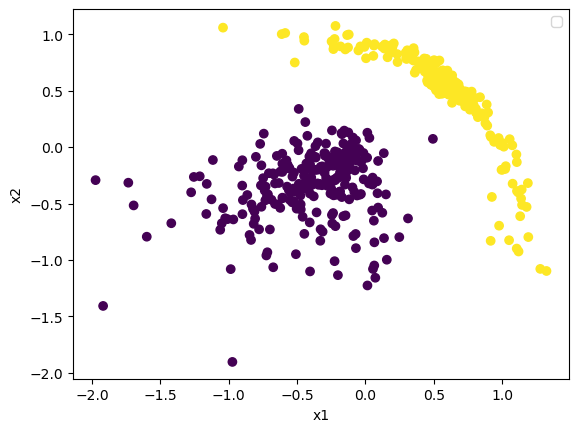

In [821]:
seed = 42
set_seed(42)
X, y , emb_list, real_size, encoder = load_6(binary=True, cutoffs=None, qcut=False)
use_cat = True
if use_cat:
    start_from = len(emb_list)
else:
    start_from = 11


size = real_size if use_cat else real_size - 1

X_train_tensor = torch.from_numpy(X[:, start_from:].astype(np.float32))
y_train_tensor = torch.from_numpy(y).float()



train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))


m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)


opt = torch.optim.AdamW(m.parameters(), lr=1e-3, weight_decay=0)
lf = nn.BCELoss() if binary else nn.MSELoss()

best = -1 if binary else 1e50
best_a = -1
best_b = -1
best_state_dict = None
######################################### Train for some epochs ###########################################
for epoch in range(201):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        m.train()
        opt.zero_grad()
        y_hat, two_d = m(x_batch.to(device))
        loss = lf(y_hat.reshape(-1), y_batch.to(device).reshape(-1))
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    # print(epoch_loss)

coors = []
labels = []
with torch.no_grad():
    m.eval()
    for x_batch, y_batch in train_loader:
        z = m(x_batch.to(device), return_features=True)
        labels.extend(y_batch)
        coors.extend(z.cpu())
zz, yy = torch.stack(coors).numpy(), torch.stack(labels).numpy()
plt.scatter(zz[:, 0], zz[:, 1], c=yy)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
df = pd.DataFrame([zz[:, 0], zz[:, 1], yy]).T
df.columns = ['Coordinate 1', 'Coordinate 2', 'Label']
df.to_csv('coor.csv', index=False)

264.0

## Experimental Setup

In [602]:
def at_95(y_scores, y_true, t=0.9):
    from sklearn.metrics import roc_curve
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Specificity = 1 - FPR
    specificity = 1 - fpr
    sensitivity = tpr
    
    # ---- Sensitivity at 95% specificity ----
    target_spec = t
    idx_spec = np.argmin(np.abs(specificity - target_spec))
    sensitivity_at_95_spec = sensitivity[idx_spec]
    
    # ---- Specificity at 95% sensitivity ----
    target_sens = t
    idx_sens = np.argmin(np.abs(sensitivity - target_sens))
    specificity_at_95_sens = specificity[idx_sens]

    return sensitivity_at_95_spec, specificity_at_95_sens
    

def ml_with_cat_features(SEED, clf, X, y, emb_list, real_size, encoder, dim, use_cat, splits=10, binary=True, use_hmean=True, coeffs=(1, 1), p=0.2, n_epochs=300, lr=1e-2):
    
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)
    best_models = []
    metrics = []
    for_stratify = y if binary else (y>3.5).astype(int)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, for_stratify), start=1):
        #################################################### Dataset
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        # start_from = 5 if use_cat else 11
        if use_cat:
            start_from = len(emb_list)
        else:
            start_from = 11
        
        
        size = real_size if use_cat else real_size - 1
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() if binary else (y_train_tensor.numpy()>3.5).astype(int),  # preserve label distribution
            random_state=SEED
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(SEED))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        #################################################### Model
        set_seed(SEED)
        # p = 0.2 if binary else 0.2
        # p = 
        # lr = 1e-2 if binary else 1e-2
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, dim), p=p, use_cat=use_cat, binary=binary).to(device)
        
        opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0)
        lf = nn.BCELoss() if binary else nn.MSELoss()
        
        best = -1 if binary else 1e50
        best_a = -1
        best_b = -1
        best_state_dict = None
        ######################################### Train for some epochs ###########################################
        for epoch in range(n_epochs):
            epoch_loss = 0
            for x_batch, y_batch in train_loader:
                m.train()
                opt.zero_grad()
                y_hat, two_d = m(x_batch.to(device))
                loss = lf(y_hat.reshape(-1), y_batch.to(device).reshape(-1))
                loss.backward()
                opt.step()
                epoch_loss += loss.item()
            if epoch % 50 == 0:
                print('Fold:', fold)
                print('Epoch:', epoch+1)
                print('Train Loss:', epoch_loss / len(train_loader))
            with torch.no_grad():
                ######################################### validation after each epoch ###########################################
                m.eval()
                for x_batch, y_batch in val_loader:
                    
                    if clf == 'mlp':
                        logits, two_d = m(x_batch.to(device))
                    else:
                        with torch.no_grad():
                            m.eval()
                            x_for_clf = []
                            y_for_clf = []
                            for x_batch_train, y_batch_train in train_loader:
                                logits, two_d = m(x_batch_train.to(device))
                                x_for_clf.extend(two_d)
                                y_for_clf.extend(y_batch_train)
                        x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                        y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                        if clf == 'svm':
                            one = (y_for_clf == 1).astype(float).sum()
                            zero = (y_for_clf == 0).astype(float).sum()
                            w = (one/zero)
                            delta = 1
                
                            classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                            classifier.fit(x_for_clf, y_for_clf)
                            
                            x_in = m(x_batch.to(device))[-1].cpu().numpy()
                            logits = classifier.decision_function(x_in)
                        elif clf == 'nc':
                            classifier = NearestCentroid(metric="euclidean")
                            classifier.fit(x_for_clf, y_for_clf)
                            x_in = m(x_batch.to(device))[-1].cpu().numpy()
                            logits = classifier.predict(x_in)
                            
                            
                        
                        
                    if binary:
                        if clf == 'mlp':
                            y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                        elif clf == 'svm':
                            y_pred = torch.from_numpy(logits >= delta).int()
                        elif clf == 'nc':
                            y_pred = torch.from_numpy(logits).int()
                        a_val = (y_pred[y_batch==0] == y_batch[y_batch==0]).float().mean().item() + 1e-20
                        b_val = (y_pred[y_batch==1] == y_batch[y_batch==1]).float().mean().item() + 1e-20
                        ####################################### This is weighting zeros higher
                        
                        c_val = sum(coeffs) / ((coeffs[0]/a_val) + coeffs[1]/b_val)
                        # c_val = (coeffs[0] * a_val + coeffs[1] * b_val) / (coeffs[0] + coeffs[1])
                        
                        try:
                            if clf == 'svm':
                                logits = torch.sigmoid(torch.from_numpy(logits))
                            elif clf == 'nc':
                                D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                                pos_idx = np.where(classifier.classes_ == 1)[0][0]
                                logits = torch.from_numpy(-D[:, pos_idx])
                                # logits = torch.sigmoid(torch.from_numpy(logits))
                            auc_val = roc_auc_score(y_batch.cpu().numpy(), logits.reshape(-1).cpu().numpy())
                            sen_val = []
                            spec_val = []
                            for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                                sen_, spec_ = at_95(logits.cpu().numpy(), y_batch, t=t)
                                sen_val.append(sen_)
                                spec_val.append(spec_)
                        except:
                            pass
                    else:
                        if clf != 'mlp':
                            raise NotImplementedError
                        y_labeled = (y_batch > 3.5).int()
                        zero = y_labeled == 0
                        a_val = lf(logits[zero], y_batch[zero]) ** 0.5 
                        b_val = lf(logits[~zero], y_batch[~zero]) ** 0.5
                        c_val = 2 / ((1/a_val) + 1/b_val)

                    if use_hmean:
                       condition = (binary and c_val > best) or ((not binary) and c_val < best) 
                    else:
                        condition = (binary and spec_ > best) or ((not binary) and c_val < best)
                    if condition:
                        ######################################### Record test scores at best validation epoch ###########################################
                        
                        if binary:
                            if use_hmean:
                                best = c_val
                                best_a = a_val
                                best_b = b_val
                            else:
                                best = spec_val
                        else:
                            best = c_val
                        import copy
                        best_state_dict = copy.deepcopy(m.state_dict())
                        m.eval()
                        for x_batch, y_batch in test_loader:
                            if clf == 'mlp':
                                
                                logits, two_d = m(x_batch.to(device))
                            elif clf == 'svm':
                                x_in = m(x_batch.to(device))[-1].cpu().numpy()
                                logits = classifier.decision_function(x_in)
                            elif clf == 'nc':
                                x_in = m(x_batch.to(device))[-1].cpu().numpy()
                                logits = classifier.predict(x_in)
                                
                            if binary:
                                if clf == 'mlp':
                                    y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                                elif clf == 'svm':
                                    y_pred = torch.from_numpy(logits >= delta).int()
                                elif clf == 'nc':
                                    
                                    y_pred = torch.from_numpy(logits).int()
                                a_test = (y_pred[y_batch==0] == y_batch[y_batch==0]).float().mean().item() + 1e-20
                                b_test = (y_pred[y_batch==1] == y_batch[y_batch==1]).float().mean().item() + 1e-20
                                c_test = 2 / ((1/a_test) + 1/b_test)
                                if clf == 'svm':
                                    logits = torch.sigmoid(torch.from_numpy(logits))
                                elif clf == 'nc':
                                    D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                                    pos_idx = np.where(classifier.classes_ == 1)[0][0]
                                    logits = torch.from_numpy(-D[:, pos_idx])
                                    # logits = torch.sigmoid(torch.from_numpy(logits))
                                
                                auc_test = roc_auc_score(y_batch.cpu().numpy(), logits.cpu().numpy())
                                sen_test = []
                                spec_test = []
                                for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                                    sen_, spec_ = at_95(logits.cpu().numpy(), y_batch, t=t)
                                    sen_test.append(sen_)
                                    spec_test.append(spec_)
                                
                            else:
                                if clf != 'mlp':
                                    raise NotImplementedError
                                y_labeled = (y_batch > 3.5).int()
                                zero = y_labeled == 0
                                a_test = lf(logits[zero], y_batch[zero]) ** 0.5 
                                b_test = lf(logits[~zero], y_batch[~zero]) ** 0.5
                                c_test = 2 / ((1/a_test) + 1/b_test)
                                auc_test = 0
            if epoch % 50 == 0:
                if not binary:
                    print(f'Fold {fold}, Test Metric: ({a_test:.4f}, {b_test:.4f}, {c_test:.4f}, {auc_test:.4f}), Val Best mean: {best}')
                else:
                    print(f'Val Best mean: ({best:.4f}, {best_a:.4f}, {best_b:.4f})')
                    print(f'Test Metric at best Validation Epoch: ({a_test:.4f}, {b_test:.4f}, {c_test:.4f}, {auc_test:.4f}, {sen_test[0]:.4f}, {spec_test[0]:.4f})')
                    
                print(f'{splits}-fold Average: {torch.tensor(metrics).mean(0)}')
                print('----------------------'*2)
        best_models.append(best_state_dict)
        
        if binary:
            metrics.append([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])
            # metrics.extend(spec_test)
            # metrics.extend(sen_test)
        else:
            metrics.append([a_test, b_test, c_test, auc_test])
        print('============================================='*2)

    return best_models, skf, torch.tensor(metrics).mean(0)




## Experiments

In [ ]:
cutoff_setting = {
    1:{'qcut':True, 'cutoffs':None, 'setting': 'qcut'},
    2:{'qcut':False, 'cutoffs':GLOBAL_CUTOFFS, 'setting': 'binary'},
    3:{'qcut':False, 'cutoffs':None, 'setting': 'no-cutoff'}
}
# results_6 = {}
# results_cohort_specific = {}
# results_6_11 = {}
# results_2 = {}

# results_6_excel = {}
# results_8_excel = {}

COHORTS = ['Autoimmune: Other', 'Cancer: Other', 'HIV', 'Healthy Control',
           'IBD', 'Multiple Myeloma', 'Transplant']
# COHORTS = [None]
for seed in range(0, 100):
    for task in [6]:
        binary = True
        for clf in ['mlp', 'nc', 'svm']:
            for c in [2, 3]:
                for coeffs in [(4, 1)]:
                    for use_cat in [True, False]:
                        if use_cat:
                            use = 'Demographic'
                        else:
                            use = 'Ab raw'
                        qcut = cutoff_setting[c]['qcut']
                        cutoffs = cutoff_setting[c]['cutoffs']
                        setting = cutoff_setting[c]['setting'] 
                        if task == 2:
                            
                            results_2[f'{seed}{task},{setting},{clf},{coeffs}'] = ml_with_cat_features(
                                seed,
                                clf,
                                *load_2(binary, cutoffs=cutoffs, qcut=qcut), dim=2, use_cat=True, binary=binary, use_hmean=True, splits=5, coeffs=coeffs,
                                n_epochs=101, p=0.2, lr=1e-3 
                            )
                        elif task == 4:
                            X, y , emb_list, real_size, encoder = load_2(binary, cutoffs=cutoffs, qcut=qcut)
                            idx = X[:, 0] == 'Healthy Control'
                            results[f'{seed},{task},{setting},{clf},{coeffs}'] = ml_with_cat_features(
                                seed,
                                clf,
                                X[idx], y[idx], emb_list, real_size, encoder, dim=2, use_cat=True, binary=binary, use_hmean=True, splits=5, coeffs=coeffs,
                                n_epochs=101, p=0.2, lr=1e-3 
                            )
                        elif task == 6:
                            X, y , emb_list, real_size, encoder = load_6(binary, cutoffs=cutoffs, qcut=qcut)
                            results_6_excel[f'{seed},{task},{setting},{clf},{coeffs},{use}'] = ml_with_cat_features(
                                seed,
                                clf,
                                X, y , emb_list, real_size, encoder, dim=2, use_cat=use_cat, binary=binary, use_hmean=True, splits=5, coeffs=coeffs,
                                n_epochs=101, p=0.2, lr=1e-3 
                            )
                        elif task == 8:
                            for cohort in COHORTS:
                                X, y , emb_list, real_size, encoder = load_6(binary, cutoffs=cutoffs, qcut=qcut)
                                # idx = X[:, 0] == 'Healthy Control'
                                idx = X[:, 0] == cohort
                                if (y[idx] == 0).sum() < 5:
                                    continue
                                results_8_excel[f'{seed},{cohort},{task},{setting},{clf},{coeffs},{use}'] = ml_with_cat_features(
                                    seed,
                                    clf,
                                    X[idx], y[idx], emb_list, real_size, encoder, dim=2, use_cat=use_cat, binary=binary, use_hmean=True, splits=5, coeffs=coeffs,
                                    n_epochs=101, p=0.2, lr=1e-3                  
                                )
    

Fold: 1
Epoch: 1
Train Loss: 0.6417098492383957
Val Best mean: (0.0000, 0.0000, 1.0000)
Test Metric at best Validation Epoch: (0.0000, 1.0000, 0.0000, 0.6427, 0.0000, 0.4717)
5-fold Average: nan
--------------------------------------------
Fold: 1
Epoch: 51
Train Loss: 0.22783776745200157
Val Best mean: (0.5253, 0.4762, 0.8938)
Test Metric at best Validation Epoch: (0.3396, 0.8900, 0.4916, 0.7289, 0.6150, 0.5849)
5-fold Average: nan
--------------------------------------------
Fold: 1
Epoch: 101
Train Loss: 0.12671278975903988
Val Best mean: (0.5253, 0.4762, 0.8938)
Test Metric at best Validation Epoch: (0.3396, 0.8900, 0.4916, 0.7289, 0.6150, 0.5849)
5-fold Average: nan
--------------------------------------------
Fold: 2
Epoch: 1
Train Loss: 0.6189555078744888
Val Best mean: (0.0000, 0.0000, 1.0000)
Test Metric at best Validation Epoch: (0.0000, 1.0000, 0.0000, 0.6053, 0.3650, 0.4151)
5-fold Average: tensor([0.3396, 0.8900, 0.4916, 0.7289, 0.5849, 0.4906, 0.4528, 0.3208, 0.2642,
    

In [782]:
# import pickle

# with open('final_models.pkl', 'wb') as f:
#     pickle.dump({'dict6': results_6_excel, 'dict8': results_8_excel}, f)


#### Post to Post by cohort

In [680]:
import re
import pandas as pd
import numpy as np

# Example: your dictionary of metrics


# --- define the 14 metric column names ---
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
columns = [
    'Low Responders Accuracy',
    'High Responders Accuracy',
    'Harmonic Mean',
    'AUC'
] + columns

# Regex: split on commas that are not inside parentheses
split_pattern = r',\s*(?![^()]*\))'

records = []
for k, v in results_8_excel.items():
    parts = re.split(split_pattern, k)
    seed, cohort, task, setting, clf, coeffs, usage = parts
    records.append({
        'seed': int(seed),
        'cohort': cohort,
        'task': task,
        'setting': setting,
        'clf': clf,
        'coeffs': coeffs,
        'usage': usage,
        **{name: val for name, val in zip(columns, v[-1])}
    })

df = pd.DataFrame(records)

group_cols = ['cohort', 'task', 'setting', 'clf', 'coeffs', 'usage']
metric_cols = columns

agg_df = df.groupby(group_cols)[metric_cols].agg(['mean', 'std']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]

# print(agg_df)


In [681]:
agg_df.head()

cohort task setting  clf  coeffs        usage  \
0  Autoimmune: Other    8  binary  mlp  (4, 1)       Ab raw   
1  Autoimmune: Other    8  binary  mlp  (4, 1)  Demographic   
2  Autoimmune: Other    8  binary   nc  (4, 1)       Ab raw   
3  Autoimmune: Other    8  binary   nc  (4, 1)  Demographic   
4  Autoimmune: Other    8  binary  svm  (4, 1)       Ab raw   

  Low Responders Accuracy_mean  Low Responders Accuracy_std  \
0                     0.483657                     0.283375   
1                     0.521686                     0.279460   
2                     0.397133                     0.063008   
3                     0.426038                     0.067220   
4                     0.706571                     0.055719   

  High Responders Accuracy_mean  High Responders Accuracy_std  ...  \
0                      0.535814                      0.270041  ...   
1                      0.520352                      0.275685  ...   
2                      0.624284                      0.057271  ...   
3                      0.621502                      0.053877  ...   
4                      0.335949                      0.052944  ...   

  Specificity at 0.75 Sensitivity_mean  Specificity at 0.75 Sensitivity_std  \
0                             0.236413                             0.073648   
1                             0.265945                             0.072609   
2                             0.220943                             0.061691   
3                             0.234517                             0.050559   
4                             0.239227                             0.055156   

  Specificity at 0.8 Sensitivity_mean  Specificity at 0.8 Sensitivity_std  \
0                            0.188761                            0.059383   
1                            0.222303                            0.066424   
2                            0.184239                            0.052999   
3                            0.198028                            0.050590   
4                            0.202758                            0.050026   

  Specificity at 0.85 Sensitivity_mean  Specificity at 0.85 Sensitivity_std  \
0                             0.129714                             0.058552   
1                              0.16089                             0.054670   
2                             0.130657                             0.046604   
3                              0.14264                             0.044893   
4                             0.147002                             0.046978   

  Specificity at 0.9 Sensitivity_mean  Specificity at 0.9 Sensitivity_std  \
0                            0.058277                            0.039342   
1                            0.072352                            0.044463   
2                            0.062564                            0.033670   
3                            0.061371                            0.032921   
4                             0.06779                            0.032058   

  Specificity at 0.95 Sensitivity_mean  Specificity at 0.95 Sensitivity_std  
0                             0.040396                             0.033726  
1                             0.055754                             0.041882  
2                             0.043646                             0.030186  
3                             0.047356                             0.031698  
4                              0.05465                             0.032557  

[5 rows x 34 columns]

In [886]:
X, y , emb_list, real_size, encoder = load_6(binary, cutoffs=cutoffs, qcut=qcut)
counts = {}
for cohort in COHORTS:
    
    # idx = X[:, 0] == 'Healthy Control'
    idx = X[:, 0] == cohort
    
    all_low_count = (y[idx] == 0).astype(float).sum()
    all_high_count = (y[idx] == 1).astype(float).sum()
    print(all_low_count, all_high_count, cohort)
    counts[f'{cohort},Test_N_Low'] = all_low_count
    counts[f'{cohort},Train_N_Low'] = all_low_count
    counts[f'{cohort},Test_N_High'] = all_high_count
    counts[f'{cohort},Train_N_High'] = all_high_count
counts

72.0 163.0 Autoimmune: Other
9.0 102.0 Cancer: Other
14.0 70.0 HIV
24.0 465.0 Healthy Control
4.0 33.0 IBD
60.0 92.0 Multiple Myeloma
81.0 73.0 Transplant


{'Autoimmune: Other,Test_N_Low': 72.0,
 'Autoimmune: Other,Train_N_Low': 72.0,
 'Autoimmune: Other,Test_N_High': 163.0,
 'Autoimmune: Other,Train_N_High': 163.0,
 'Cancer: Other,Test_N_Low': 9.0,
 'Cancer: Other,Train_N_Low': 9.0,
 'Cancer: Other,Test_N_High': 102.0,
 'Cancer: Other,Train_N_High': 102.0,
 'HIV,Test_N_Low': 14.0,
 'HIV,Train_N_Low': 14.0,
 'HIV,Test_N_High': 70.0,
 'HIV,Train_N_High': 70.0,
 'Healthy Control,Test_N_Low': 24.0,
 'Healthy Control,Train_N_Low': 24.0,
 'Healthy Control,Test_N_High': 465.0,
 'Healthy Control,Train_N_High': 465.0,
 'IBD,Test_N_Low': 4.0,
 'IBD,Train_N_Low': 4.0,
 'IBD,Test_N_High': 33.0,
 'IBD,Train_N_High': 33.0,
 'Multiple Myeloma,Test_N_Low': 60.0,
 'Multiple Myeloma,Train_N_Low': 60.0,
 'Multiple Myeloma,Test_N_High': 92.0,
 'Multiple Myeloma,Train_N_High': 92.0,
 'Transplant,Test_N_Low': 81.0,
 'Transplant,Train_N_Low': 81.0,
 'Transplant,Test_N_High': 73.0,
 'Transplant,Train_N_High': 73.0}

In [682]:
agg_df['Train_Timepoint'] = 'Post-B'
agg_df['Test_Timepoint'] = 'Post-B'
agg_df['Test_Cohort'] = agg_df['cohort']
def update_usage(row, what):
    cohort = row['cohort']
    return counts[f'{cohort},{what}']

# Apply transformation
for what in ['Train_N_Low', 'Train_N_High', 'Test_N_High', 'Test_N_Low']:
    agg_df[what] = agg_df.apply(lambda z:update_usage(z, what=what), axis=1)
    
agg_df = agg_df.rename(columns={
    'cohort': 'Train_Cohort', 
    'clf': 'Classifier', 
    'AUC_mean': 'CV_AUC_Mean',
    'AUC_std': 'CV_AUC_SD',
    'Sensitivity at 0.8 Specificity_mean': 'CV_Sen_at_80_Spe_Mean',
    'Sensitivity at 0.8 Specificity_std': 'CV_Sen_at_80_Spe_SD',
    'Low Responders Accuracy_mean': 'CV_Acc_Low_Mean',
    'High Responders Accuracy_mean': 'CV_Acc_High_Mean',
    'Low Responders Accuracy_std': 'CV_Acc_Low_SD',
    'High Responders Accuracy_std': 'CV_Acc_High_SD',
})

def update_usage(row):
    # Start with base usage name
    usage = row['usage']
    setting = row['setting']
    
    
    # Case 1: if usage is "Ab raw"
    
    out = 'Ab_raw'
    
    
    # Case 2: if usage is "Demographic"
    if setting.strip().lower() == 'binary':
        out += '+ Ab_binary'
        
    if usage.strip().lower() == 'demographic':
        out += '+ demographic'
    
    # Case 3: modify further based on 'setting'
    
    if setting.strip().lower() == 'no-cutoff':
        # don't add anything
        pass
    
    return out

# Apply transformation
agg_df['Feature_Set'] = agg_df.apply(update_usage, axis=1)
agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier',	'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]



Train_Timepoint       Train_Cohort  Train_N_Low  Train_N_High  \
0           Post-B  Autoimmune: Other         58.0         131.0   
1           Post-B  Autoimmune: Other         58.0         131.0   
2           Post-B  Autoimmune: Other         58.0         131.0   
3           Post-B  Autoimmune: Other         58.0         131.0   
4           Post-B  Autoimmune: Other         58.0         131.0   
..             ...                ...          ...           ...   
67          Post-B         Transplant         65.0          59.0   
68          Post-B         Transplant         65.0          59.0   
69          Post-B         Transplant         65.0          59.0   
70          Post-B         Transplant         65.0          59.0   
71          Post-B         Transplant         65.0          59.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
..                             ...            ...                ...   
67             Ab_raw+ demographic         Post-B         Transplant   
68                          Ab_raw         Post-B         Transplant   
69             Ab_raw+ demographic         Post-B         Transplant   
70                          Ab_raw         Post-B         Transplant   
71             Ab_raw+ demographic         Post-B         Transplant   

    Test_N_Low  Test_N_High Classifier CV_AUC_Mean  CV_AUC_SD  \
0         14.0         32.0        mlp    0.519177   0.037570   
1         14.0         32.0        mlp    0.545551   0.040479   
2         14.0         32.0         nc    0.528434   0.039630   
3         14.0         32.0         nc    0.541059   0.036547   
4         14.0         32.0        svm    0.531261   0.035584   
..         ...          ...        ...         ...        ...   
67        16.0         14.0        mlp    0.552797   0.040570   
68        16.0         14.0         nc    0.510863   0.043189   
69        16.0         14.0         nc    0.526472   0.046465   
70        16.0         14.0        svm    0.520031   0.047456   
71        16.0         14.0        svm     0.53209   0.045176   

   CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD CV_Acc_Low_Mean  CV_Acc_Low_SD  \
0               0.280638             0.057416        0.483657       0.283375   
1               0.310752             0.070853        0.521686       0.279460   
2               0.302295             0.055403        0.397133       0.063008   
3               0.320124             0.052592        0.426038       0.067220   
4               0.286267             0.048841        0.706571       0.055719   
..                   ...                  ...             ...            ...   
67              0.332228             0.065942        0.564265       0.248461   
68              0.286088             0.054508        0.520029       0.065614   
69               0.30361             0.068458        0.554243       0.074772   
70              0.292162             0.067263        0.836809       0.058186   
71              0.315426             0.063876         0.82664       0.045852   

   CV_Acc_High_Mean  CV_Acc_High_SD  
0          0.535814        0.270041  
1          0.520352        0.275685  
2          0.624284        0.057271  
3          0.621502        0.053877  
4          0.335949        0.052944  
..              ...             ...  
67         0.509495        0.239451  
68         0.479533        0.062681  
69         0.500381        0.059136  
70         0.187333        0.058779  
71         0.203286        0.059852  

[72 rows x 18 columns]

In [ ]:
out = agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier',	'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]
out.to_csv('model_performance_summary_v1.csv')

In [889]:
df = pd.read_csv('model_performance_summary_v1.csv')
for i, r in df.iterrows():
    df.loc[i, 'Train_N_Low'] = counts[f'{r["Train_Cohort"]},Train_N_Low']
    df.loc[i, 'Train_N_High'] = counts[f'{r["Train_Cohort"]},Train_N_High']
    df.loc[i, 'Test_N_Low'] = counts[f'{r["Test_Cohort"]},Test_N_Low']
    df.loc[i, 'Test_N_High'] = counts[f'{r["Test_Cohort"]},Test_N_High']

df.to_csv('model_performance_summary_v1_revised.csv')
df

Unnamed: 0 Train_Timepoint       Train_Cohort  Train_N_Low  Train_N_High  \
0            0          Post-B  Autoimmune: Other         72.0         163.0   
1            1          Post-B  Autoimmune: Other         72.0         163.0   
2            2          Post-B  Autoimmune: Other         72.0         163.0   
3            3          Post-B  Autoimmune: Other         72.0         163.0   
4            4          Post-B  Autoimmune: Other         72.0         163.0   
..         ...             ...                ...          ...           ...   
67          67          Post-B         Transplant         81.0          73.0   
68          68          Post-B         Transplant         81.0          73.0   
69          69          Post-B         Transplant         81.0          73.0   
70          70          Post-B         Transplant         81.0          73.0   
71          71          Post-B         Transplant         81.0          73.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
..                             ...            ...                ...   
67             Ab_raw+ demographic         Post-B         Transplant   
68                          Ab_raw         Post-B         Transplant   
69             Ab_raw+ demographic         Post-B         Transplant   
70                          Ab_raw         Post-B         Transplant   
71             Ab_raw+ demographic         Post-B         Transplant   

    Test_N_Low  Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  \
0         72.0        163.0        mlp     0.519177   0.037570   
1         72.0        163.0        mlp     0.545551   0.040479   
2         72.0        163.0         nc     0.528434   0.039630   
3         72.0        163.0         nc     0.541059   0.036547   
4         72.0        163.0        svm     0.531261   0.035584   
..         ...          ...        ...          ...        ...   
67        81.0         73.0        mlp     0.552797   0.040570   
68        81.0         73.0         nc     0.510863   0.043189   
69        81.0         73.0         nc     0.526472   0.046465   
70        81.0         73.0        svm     0.520031   0.047456   
71        81.0         73.0        svm     0.532090   0.045176   

    CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  \
0                0.280638             0.057416         0.483657   
1                0.310752             0.070853         0.521686   
2                0.302295             0.055403         0.397133   
3                0.320124             0.052592         0.426038   
4                0.286267             0.048841         0.706571   
..                    ...                  ...              ...   
67               0.332228             0.065942         0.564265   
68               0.286088             0.054508         0.520029   
69               0.303610             0.068458         0.554243   
70               0.292162             0.067263         0.836809   
71               0.315426             0.063876         0.826640   

    CV_Acc_Low_SD  CV_Acc_High_Mean  CV_Acc_High_SD  
0        0.283375          0.535814        0.270041  
1        0.279460          0.520352        0.275685  
2        0.063008          0.624284        0.057271  
3        0.067220          0.621502        0.053877  
4        0.055719          0.335949        0.052944  
..            ...               ...             ...  
67       0.248461          0.509495        0.239451  
68       0.065614          0.479533        0.062681  
69       0.074772          0.500381        0.059136  
70       0.058186          0.187333     

#### Post to Post All

In [699]:
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
columns = [
    'Low Responders Accuracy',
    'High Responders Accuracy',
    'Harmonic Mean',
    'AUC'
] + columns
for k, v in results_6_excel.items():
    seed, _, setting, clf, __, usage = re.split(r',\s*(?![^()]*\))', k)


records = []
for k, v in results_6_excel.items():
    parts = re.split(split_pattern, k)
    seed, task, setting, clf, coeffs, usage = parts
    records.append({
        'seed': int(seed),
        'cohort': 'All',
        'task': task,
        'setting': setting,
        'clf': clf,
        'coeffs': coeffs,
        'usage': usage,
        **{name: val for name, val in zip(columns, v[-1])}
    })

df = pd.DataFrame(records)

group_cols = ['task', 'cohort', 'setting', 'clf', 'coeffs', 'usage']
metric_cols = columns

agg_df = df.groupby(group_cols)[metric_cols].agg(['mean', 'std']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]
agg_df

task cohort    setting  clf  coeffs        usage  \
0     6    All     binary  mlp  (4, 1)       Ab raw   
1     6    All     binary  mlp  (4, 1)  Demographic   
2     6    All     binary   nc  (4, 1)       Ab raw   
3     6    All     binary   nc  (4, 1)  Demographic   
4     6    All     binary  svm  (4, 1)       Ab raw   
5     6    All     binary  svm  (4, 1)  Demographic   
6     6    All  no-cutoff  mlp  (4, 1)       Ab raw   
7     6    All  no-cutoff  mlp  (4, 1)  Demographic   
8     6    All  no-cutoff   nc  (4, 1)       Ab raw   
9     6    All  no-cutoff   nc  (4, 1)  Demographic   
10    6    All  no-cutoff  svm  (4, 1)       Ab raw   
11    6    All  no-cutoff  svm  (4, 1)  Demographic   

   Low Responders Accuracy_mean  Low Responders Accuracy_std  \
0                      0.572921                     0.172749   
1                      0.644741                     0.169995   
2                       0.54907                     0.042800   
3                      0.589658                     0.042097   
4                      0.691062                     0.037217   
5                      0.744039                     0.043451   
6                      0.584875                     0.156188   
7                      0.666021                     0.156551   
8                      0.547397                     0.045727   
9                      0.614024                     0.039258   
10                     0.692431                     0.037638   
11                     0.777803                     0.040112   

   High Responders Accuracy_mean  High Responders Accuracy_std  ...  \
0                        0.67822                      0.162297  ...   
1                       0.696249                      0.138374  ...   
2                        0.66208                      0.055566  ...   
3                       0.713142                      0.049810  ...   
4                       0.555638                      0.037663  ...   
5                       0.603672                      0.035942  ...   
6                       0.670334                      0.157725  ...   
7                       0.715709                      0.126016  ...   
8                       0.656191                      0.058674  ...   
9                       0.730845                      0.045814  ...   
10                      0.554172                      0.043360  ...   
11                      0.613881                      0.038048  ...   

   Specificity at 0.75 Sensitivity_mean  Specificity at 0.75 Sensitivity_std  \
0                              0.493206                             0.038858   
1                               0.60616                             0.036515   
2                              0.333472                             0.051213   
3                               0.38929                             0.073052   
4                              0.438089                             0.051454   
5                              0.552353                             0.070853   
6                               0.48819                             0.041704   
7                              0.648492                             0.035424   
8                              0.325801                             0.051683   
9                               0.41372                             0.089823   
10                             0.442824                             0.056119   
11                             0.603753                             0.063853   

   Specificity at 0.8 Sensitivity_mean  Specificity at 0.8 Sensitivity_std  \
0                             0.431945                            0.049203   
1                              0.55136                            0.043810   
2                             0.277888                            0.050271   
3                             0.329967                            0.067699   
4                             0.366809                            0.051421   
5                    

In [890]:
X, y , emb_list, real_size, encoder = load_6(binary, cutoffs=cutoffs, qcut=qcut)
counts = {}
# for cohort in COHORTS:
    
    # idx = X[:, 0] == 'Healthy Control'
    # idx = X[:, 0] == cohort
all_low_count = (y == 0).astype(float).sum()
all_high_count = (y == 1).astype(float).sum()
counts[f'Test_N_Low'] = all_low_count
counts[f'Train_N_Low'] = all_low_count
counts[f'Test_N_High'] = all_high_count
counts[f'Train_N_High'] = all_high_count
counts

{'Test_N_Low': 264.0,
 'Train_N_Low': 264.0,
 'Test_N_High': 998.0,
 'Train_N_High': 998.0}

In [701]:
agg_df['Train_Timepoint'] = 'Post-B'
agg_df['Test_Timepoint'] = 'Post-B'
agg_df['Test_Cohort'] = 'All'

X, y , emb_list, real_size, encoder = load_6(binary, cutoffs=cutoffs, qcut=qcut)
counts = {}
# for cohort in COHORTS:
    
    # idx = X[:, 0] == 'Healthy Control'
    # idx = X[:, 0] == cohort
all_low_count = (y == 0).astype(float).sum()
all_high_count = (y == 1).astype(float).sum()
counts[f'Test_N_Low'] = all_low_count // 5
counts[f'Train_N_Low'] = all_low_count  - counts[f'Test_N_Low']
counts[f'Test_N_High'] = all_high_count // 5
counts[f'Train_N_High'] = all_high_count  - counts[f'Test_N_High']
# counts

def update_usage(row, what):
    return counts[f'{what}']

# Apply transformation
for what in ['Train_N_Low', 'Train_N_High', 'Test_N_High', 'Test_N_Low']:
    agg_df[what] = agg_df.apply(lambda z:update_usage(z, what=what), axis=1)
    
agg_df = agg_df.rename(columns={
    'cohort': 'Train_Cohort', 
    'clf': 'Classifier', 
    'AUC_mean': 'CV_AUC_Mean',
    'AUC_std': 'CV_AUC_SD',
    'Sensitivity at 0.8 Specificity_mean': 'CV_Sen_at_80_Spe_Mean',
    'Sensitivity at 0.8 Specificity_std': 'CV_Sen_at_80_Spe_SD',
    'Low Responders Accuracy_mean': 'CV_Acc_Low_Mean',
    'High Responders Accuracy_mean': 'CV_Acc_High_Mean',
    'Low Responders Accuracy_std': 'CV_Acc_Low_SD',
    'High Responders Accuracy_std': 'CV_Acc_High_SD',
})

def update_usage(row):
    # Start with base usage name
    usage = row['usage']
    setting = row['setting']
    
    
    # Case 1: if usage is "Ab raw"
    
    out = 'Ab_raw'
    
    
    # Case 2: if usage is "Demographic"
    if setting.strip().lower() == 'binary':
        out += '+ Ab_binary'
        
    if usage.strip().lower() == 'demographic':
        out += '+ demographic'
    
    # Case 3: modify further based on 'setting'
    
    if setting.strip().lower() == 'no-cutoff':
        # don't add anything
        pass
    
    return out

# Apply transformation
agg_df['Feature_Set'] = agg_df.apply(update_usage, axis=1)
agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier', 'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]



Train_Timepoint Train_Cohort  Train_N_Low  Train_N_High  \
0           Post-B          All        212.0         799.0   
1           Post-B          All        212.0         799.0   
2           Post-B          All        212.0         799.0   
3           Post-B          All        212.0         799.0   
4           Post-B          All        212.0         799.0   
5           Post-B          All        212.0         799.0   
6           Post-B          All        212.0         799.0   
7           Post-B          All        212.0         799.0   
8           Post-B          All        212.0         799.0   
9           Post-B          All        212.0         799.0   
10          Post-B          All        212.0         799.0   
11          Post-B          All        212.0         799.0   

                       Feature_Set Test_Timepoint Test_Cohort  Test_N_Low  \
0                Ab_raw+ Ab_binary         Post-B         All        52.0   
1   Ab_raw+ Ab_binary+ demographic         Post-B         All        52.0   
2                Ab_raw+ Ab_binary         Post-B         All        52.0   
3   Ab_raw+ Ab_binary+ demographic         Post-B         All        52.0   
4                Ab_raw+ Ab_binary         Post-B         All        52.0   
5   Ab_raw+ Ab_binary+ demographic         Post-B         All        52.0   
6                           Ab_raw         Post-B         All        52.0   
7              Ab_raw+ demographic         Post-B         All        52.0   
8                           Ab_raw         Post-B         All        52.0   
9              Ab_raw+ demographic         Post-B         All        52.0   
10                          Ab_raw         Post-B         All        52.0   
11             Ab_raw+ demographic         Post-B         All        52.0   

    Test_N_High Classifier CV_AUC_Mean  CV_AUC_SD CV_Sen_at_80_Spe_Mean  \
0         199.0        mlp    0.684762   0.013148              0.475634   
1         199.0        mlp     0.74264   0.018529              0.558895   
2         199.0         nc    0.585022   0.039592              0.329084   
3         199.0         nc    0.622994   0.050419              0.385864   
4         199.0        svm    0.666246   0.017892               0.46645   
5         199.0        svm    0.721375   0.023013              0.548728   
6         199.0        mlp    0.687912   0.020413              0.480037   
7         199.0        mlp    0.765951   0.017666              0.594364   
8         199.0         nc    0.580031   0.041890              0.326875   
9         199.0         nc    0.640067   0.052502              0.416181   
10        199.0        svm    0.667977   0.019814              0.466571   
11        199.0        svm     0.74161   0.022247              0.582762   

    CV_Sen_at_80_Spe_SD CV_Acc_Low_Mean  CV_Acc_Low_SD CV_Acc_High_Mean  \
0              0.029027        0.572921       0.172749          0.67822   
1              0.037587        0.644741       0.169995         0.696249   
2              0.062969         0.54907       0.042800          0.66208   
3              0.080376        0.589658       0.042097         0.713142   
4              0.030549        0.691062       0.037217         0.555638   
5              0.032280        0.744039       0.043451         0.603672   
6              0.037763        0.584875       0.156188         0.670334   
7              0.035159        0.666021       0.156551         0.715709   
8              0.067398        0.547397       0.045727         0.656191   
9              0.083975        0.614024       0.039258         0.730845   
10             0.027837        0.692431       0.037638         0.554172   
11             0.039049        0.777803       0.040112         0.613881   

    CV_Acc_High_SD  
0         0.162297  
1         0.138374  
2         0.055566  
3         0.049810  
4         0.037663  
5         0.035942  
6         0.157725  
7         0.126016  
8         0.058674  
9         0.045814  
10        0

In [702]:
out = agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier',	'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]
out.to_csv('model_performance_summary_v2.csv')

In [891]:
df = pd.read_csv('model_performance_summary_v2.csv')
for i, r in df.iterrows():
    df.loc[i, 'Train_N_Low'] = counts[f'Train_N_Low']
    df.loc[i, 'Train_N_High'] = counts[f'Train_N_High']
    df.loc[i, 'Test_N_Low'] = counts[f'Test_N_Low']
    df.loc[i, 'Test_N_High'] = counts[f'Test_N_High']

df.to_csv('model_performance_summary_v2_revised.csv')
# df

#### Post to Post from All to cohort

In [740]:
metrics = {}

for k, v in results_6_excel.items():
    # print(k)
    # raise
    seed, task, setting, clf, coeffs, usage = re.split(r',\s*(?![^()]*\))', k)
    # print(usage)
    seed = int(seed)
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None

    if 'raw' in usage:
        use_cat = False
    else:
        use_cat = True
    if use_cat:
            start_from = len(emb_list)
    else:
        start_from = 11
        
        
    
    X, y , emb_list, real_size, encoder = load_6(binary=True, cutoffs=cutoffs, qcut=False)
    size = real_size if use_cat else real_size - 1
    # print(usage, setting, X.shape, use_cat, size, start_from)
    en = {}
    for k_cohort, v_cohort in (X[:, [0, 5]]):
        en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, for_stratify), start=0):
        #################################################### Dataset
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        # start_from = len(emb_list)
        # size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        # print(size, start_from)
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)
        # print(m)
        # print(fold, k, len(emb_list))
        # for a, b in v[0][fold].items():
            # print(a, b.shape)
        m.load_state_dict(v[0][fold])
        
        
        for cohort in en.keys():
            for x_batch, y_batch in test_loader:
                pass
            # index = x_batch[:, 0] == en[cohort]
            index = X_test[:, 5] == en[cohort]
            # print(cohort, en[cohort])
            
            # print(y_batch[index])
            # print(x_batch.shape, X_test[:, :].shape)
            
            
            if (y_batch[index] == 0).float().sum() < 1:
                print(cohort, fold, seed, 'not enough negative samples')
                continue
            if clf == 'mlp':
                with torch.no_grad():
                    m.eval()
                    logits, two_d = m(x_batch[index].to(device))
            else:
                with torch.no_grad():
                    x_for_clf = []
                    y_for_clf = []
                    for x_batch_train, y_batch_train in train_loader:
                        with torch.no_grad():
                            m.eval()
                            _, two_d = m(x_batch_train.to(device))
                        x_for_clf.extend(two_d)
                        y_for_clf.extend(y_batch_train)
                x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                if clf == 'svm':
                    one = (y_for_clf == 1).astype(float).sum()
                    zero = (y_for_clf == 0).astype(float).sum()
                    w = (one/zero)
                    delta = 1
        
                    classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.decision_function(x_in)
                elif clf == 'nc':
                    classifier = NearestCentroid(metric="euclidean")
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.predict(x_in)

            if 1:
                if clf == 'mlp':
                    y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                elif clf == 'svm':
                    y_pred = torch.from_numpy(logits >= delta).int()
                elif clf == 'nc':
                    
                    y_pred = torch.from_numpy(logits).int()
                a_test = (y_pred[y_batch[index]==0] == y_batch[index][y_batch[index]==0]).float().mean().item() + 1e-20
                b_test = (y_pred[y_batch[index]==1] == y_batch[index][y_batch[index]==1]).float().mean().item() + 1e-20
                c_test = 2 / ((1/a_test) + 1/b_test)
                if clf == 'svm':
                    logits = torch.sigmoid(torch.from_numpy(logits))
                elif clf == 'nc':
                    D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                    pos_idx = np.where(classifier.classes_ == 1)[0][0]
                    logits = torch.from_numpy(-D[:, pos_idx])
                    # logits = torch.sigmoid(torch.from_numpy(logits))

                try:
                    auc_test = roc_auc_score(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                except:
                    auc_test = None
                sen_test = []
                spec_test = []
                for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                    sen_, spec_ = at_95(logits.cpu().numpy(), y_batch[index], t=t)
                    sen_test.append(sen_)
                    spec_test.append(spec_)
                    
            
            metrics[f'{seed}, {fold}, {cohort}, {clf}, {setting}, {usage}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
    
        # print('-----------------')

IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 no

In [750]:
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
columns = [
    'Low Responders Accuracy',
    'High Responders Accuracy',
    'Harmonic Mean',
    'AUC'
] + columns
# for k, v in results_6_excel.items():
    # seed, _, setting, clf, __, usage = re.split(r',\s*(?![^()]*\))', k)


records = []
for k, v in metrics.items():
    # parts = re.split(split_pattern, k)
    seed, fold, cohort, clf, setting, usage = k.split(', ')
    # seed, task, setting, clf, coeffs, usage = parts
    records.append({
        'seed': int(seed),
        'fold': int(fold),
        'cohort': cohort,
        # 'task': task,
        'setting': setting,
        'clf': clf,
        # 'coeffs': coeffs,
        'usage': usage,
        **{name: val for name, val in zip(columns, v)}
    })

df = pd.DataFrame(records)

group_cols = ['cohort', 'setting', 'clf', 'usage']
metric_cols = columns

agg_df = df.groupby(group_cols)[metric_cols].agg(['mean', 'std']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]
agg_df

cohort    setting  clf        usage  \
0   Autoimmune: Other     binary  mlp       Ab raw   
1   Autoimmune: Other     binary  mlp  Demographic   
2   Autoimmune: Other     binary   nc       Ab raw   
3   Autoimmune: Other     binary   nc  Demographic   
4   Autoimmune: Other     binary  svm       Ab raw   
..                ...        ...  ...          ...   
79         Transplant  no-cutoff  mlp  Demographic   
80         Transplant  no-cutoff   nc       Ab raw   
81         Transplant  no-cutoff   nc  Demographic   
82         Transplant  no-cutoff  svm       Ab raw   
83         Transplant  no-cutoff  svm  Demographic   

    Low Responders Accuracy_mean  Low Responders Accuracy_std  \
0                       0.411970                     0.214082   
1                       0.502758                     0.229264   
2                       0.398444                     0.146331   
3                       0.410567                     0.157251   
4                       0.532997                     0.152662   
..                           ...                          ...   
79                      0.765108                     0.206998   
80                      0.491249                     0.142405   
81                      0.733370                     0.147936   
82                      0.673354                     0.148676   
83                      0.883456                     0.107767   

    High Responders Accuracy_mean  High Responders Accuracy_std  \
0                        0.641123                      0.190020   
1                        0.557126                      0.216069   
2                        0.612073                      0.132745   
3                        0.604165                      0.142220   
4                        0.514514                      0.118839   
..                            ...                           ...   
79                       0.255960                      0.223688   
80                       0.520774                      0.155175   
81                       0.281284                      0.160980   
82                       0.368025                      0.159628   
83                       0.131494                      0.119650   

    Harmonic Mean_mean  Harmonic Mean_std  ...  \
0             0.430876           0.139752  ...   
1             0.442959           0.120777  ...   
2             0.455480           0.108868  ...   
3             0.455383           0.111975  ...   
4             0.498978           0.092860  ...   
..                 ...                ...  ...   
79            0.298718           0.197879  ...   
80            0.477961           0.102841  ...   
81            0.368691           0.156690  ...   
82            0.442522           0.129291  ...   
83            0.205866           0.159251  ...   

    Specificity at 0.75 Sensitivity_mean  Specificity at 0.75 Sensitivity_std  \
0                               0.254479                             0.164339   
1                               0.261500                             0.148433   
2                               0.247546                             0.141659   
3                               0.251254                             0.142051   
4                               0.239173                             0.139063   
..                                   ...                                  ...   
79                              0.213360                             0.142782   
80                              0.220767                             0.152171   
81                              0.207373                             0.146723   
82                              0.226234                             0.144158   
83                              0.210953                             0.138475   

    Specificity at 0.8 Sensitivity_mean  Specificity at 0.8 Sensitivity_std  \
0                              0.202397                            0.160861   
1                              0.209518         

In [892]:
X, y , emb_list, real_size, encoder = load_6(binary, cutoffs=cutoffs, qcut=qcut)
counts = {}
for cohort in COHORTS:
    
    # idx = X[:, 0] == 'Healthy Control'
    all_low_count_train = (y == 0).astype(float).sum()
    all_high_count_train = (y == 1).astype(float).sum()
    idx = X[:, 0] == cohort
    all_low_count = (y[idx] == 0).astype(float).sum()
    all_high_count = (y[idx] == 1).astype(float).sum()
    counts[f'{cohort},Test_N_Low'] = all_low_count
    counts[f'All,Train_N_Low'] = all_low_count_train
    counts[f'{cohort},Test_N_High'] = all_high_count
    counts[f'All,Train_N_High'] = all_high_count_train
counts

{'Autoimmune: Other,Test_N_Low': 72.0,
 'All,Train_N_Low': 264.0,
 'Autoimmune: Other,Test_N_High': 163.0,
 'All,Train_N_High': 998.0,
 'Cancer: Other,Test_N_Low': 9.0,
 'Cancer: Other,Test_N_High': 102.0,
 'HIV,Test_N_Low': 14.0,
 'HIV,Test_N_High': 70.0,
 'Healthy Control,Test_N_Low': 24.0,
 'Healthy Control,Test_N_High': 465.0,
 'IBD,Test_N_Low': 4.0,
 'IBD,Test_N_High': 33.0,
 'Multiple Myeloma,Test_N_Low': 60.0,
 'Multiple Myeloma,Test_N_High': 92.0,
 'Transplant,Test_N_Low': 81.0,
 'Transplant,Test_N_High': 73.0}

In [751]:
agg_df['Train_Timepoint'] = 'Post-B'
agg_df['Test_Timepoint'] = 'Post-B'

agg_df['Test_Cohort'] = agg_df['cohort']
agg_df['Train_Cohort'] = 'All'

X, y , emb_list, real_size, encoder = load_6(binary, cutoffs=cutoffs, qcut=qcut)
counts = {}
for cohort in COHORTS:
    
    # idx = X[:, 0] == 'Healthy Control'
    idx = X[:, 0] == cohort
    all_low_count = (y[idx] == 0).astype(float).sum()
    all_high_count = (y[idx] == 1).astype(float).sum()
    counts[f'{cohort},Test_N_Low'] = all_low_count // 5
    counts[f'{cohort},Train_N_Low'] = all_low_count  - counts[f'{cohort},Test_N_Low']
    counts[f'{cohort},Test_N_High'] = all_high_count // 5
    counts[f'{cohort},Train_N_High'] = all_high_count  - counts[f'{cohort},Test_N_High']
# counts

def update_usage(row, what):
    cohort = row['cohort']
    return counts[f'{cohort},{what}']

# Apply transformation
for what in ['Train_N_Low', 'Train_N_High', 'Test_N_High', 'Test_N_Low']:
    agg_df[what] = agg_df.apply(lambda z:update_usage(z, what=what), axis=1)
    
    
agg_df = agg_df.rename(columns={
    # 'cohort': 'Train_Cohort', 
    'clf': 'Classifier', 
    'AUC_mean': 'CV_AUC_Mean',
    'AUC_std': 'CV_AUC_SD',
    'Sensitivity at 0.8 Specificity_mean': 'CV_Sen_at_80_Spe_Mean',
    'Sensitivity at 0.8 Specificity_std': 'CV_Sen_at_80_Spe_SD',
    'Low Responders Accuracy_mean': 'CV_Acc_Low_Mean',
    'High Responders Accuracy_mean': 'CV_Acc_High_Mean',
    'Low Responders Accuracy_std': 'CV_Acc_Low_SD',
    'High Responders Accuracy_std': 'CV_Acc_High_SD',
})

def update_usage(row):
    # Start with base usage name
    usage = row['usage']
    setting = row['setting']
    
    
    # Case 1: if usage is "Ab raw"
    
    out = 'Ab_raw'
    
    
    # Case 2: if usage is "Demographic"
    if setting.strip().lower() == 'binary':
        out += '+ Ab_binary'
        
    if usage.strip().lower() == 'demographic':
        out += '+ demographic'
    
    # Case 3: modify further based on 'setting'
    
    if setting.strip().lower() == 'no-cutoff':
        # don't add anything
        pass
    
    return out

# Apply transformation
agg_df['Feature_Set'] = agg_df.apply(update_usage, axis=1)
agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier', 'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]



Train_Timepoint Train_Cohort  Train_N_Low  Train_N_High  \
0           Post-B          All         58.0         131.0   
1           Post-B          All         58.0         131.0   
2           Post-B          All         58.0         131.0   
3           Post-B          All         58.0         131.0   
4           Post-B          All         58.0         131.0   
..             ...          ...          ...           ...   
79          Post-B          All         65.0          59.0   
80          Post-B          All         65.0          59.0   
81          Post-B          All         65.0          59.0   
82          Post-B          All         65.0          59.0   
83          Post-B          All         65.0          59.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
..                             ...            ...                ...   
79             Ab_raw+ demographic         Post-B         Transplant   
80                          Ab_raw         Post-B         Transplant   
81             Ab_raw+ demographic         Post-B         Transplant   
82                          Ab_raw         Post-B         Transplant   
83             Ab_raw+ demographic         Post-B         Transplant   

    Test_N_Low  Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  \
0         14.0         32.0        mlp     0.538740   0.093753   
1         14.0         32.0        mlp     0.545297   0.091905   
2         14.0         32.0         nc     0.561573   0.101163   
3         14.0         32.0         nc     0.557160   0.097453   
4         14.0         32.0        svm     0.536833   0.095280   
..         ...          ...        ...          ...        ...   
79        16.0         14.0        mlp     0.517787   0.102587   
80        16.0         14.0         nc     0.537281   0.105351   
81        16.0         14.0         nc     0.520133   0.105473   
82        16.0         14.0        svm     0.528078   0.105533   
83        16.0         14.0        svm     0.508121   0.108654   

    CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  \
0                0.307631             0.131976         0.411970   
1                0.323484             0.141425         0.502758   
2                0.357184             0.147727         0.398444   
3                0.348004             0.143153         0.410567   
4                0.311407             0.137529         0.532997   
..                    ...                  ...              ...   
79               0.249932             0.192165         0.765108   
80               0.327033             0.150193         0.491249   
81               0.308289             0.141439         0.733370   
82               0.308376             0.161778         0.673354   
83               0.283542             0.154540         0.883456   

    CV_Acc_Low_SD  CV_Acc_High_Mean  CV_Acc_High_SD  
0        0.214082          0.641123        0.190020  
1        0.229264          0.557126        0.216069  
2        0.146331          0.612073        0.132745  
3        0.157251          0.604165        0.142220  
4        0.152662          0.514514        0.118839  
..            ...               ...             ...  
79       0.206998          0.255960        0.223688  
80       0.142405          0.520774        0.155175  
81       0.147936          0.281284        0.160980  
82       0.148676          0.368025        0.159628  
83       0.107767          0.131494        0.119650  

[84 rows x 18 columns]

In [752]:
out = agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier',	'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]
out.to_csv('model_performance_summary_v3.csv')

In [894]:
df = pd.read_csv('model_performance_summary_v3.csv')
for i, r in df.iterrows():
    df.loc[i, 'Train_N_Low'] = counts[f'All,Train_N_Low']
    df.loc[i, 'Train_N_High'] = counts[f'All,Train_N_High']
    df.loc[i, 'Test_N_Low'] = counts[f'{r["Test_Cohort"]},Test_N_Low']
    df.loc[i, 'Test_N_High'] = counts[f'{r["Test_Cohort"]},Test_N_High']

df.to_csv('model_performance_summary_v3_revised.csv')
df

Unnamed: 0 Train_Timepoint Train_Cohort  Train_N_Low  Train_N_High  \
0            0          Post-B          All        264.0         998.0   
1            1          Post-B          All        264.0         998.0   
2            2          Post-B          All        264.0         998.0   
3            3          Post-B          All        264.0         998.0   
4            4          Post-B          All        264.0         998.0   
..         ...             ...          ...          ...           ...   
79          79          Post-B          All        264.0         998.0   
80          80          Post-B          All        264.0         998.0   
81          81          Post-B          All        264.0         998.0   
82          82          Post-B          All        264.0         998.0   
83          83          Post-B          All        264.0         998.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic         Post-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary         Post-B  Autoimmune: Other   
..                             ...            ...                ...   
79             Ab_raw+ demographic         Post-B         Transplant   
80                          Ab_raw         Post-B         Transplant   
81             Ab_raw+ demographic         Post-B         Transplant   
82                          Ab_raw         Post-B         Transplant   
83             Ab_raw+ demographic         Post-B         Transplant   

    Test_N_Low  Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  \
0         72.0        163.0        mlp     0.538740   0.093753   
1         72.0        163.0        mlp     0.545297   0.091905   
2         72.0        163.0         nc     0.561573   0.101163   
3         72.0        163.0         nc     0.557160   0.097453   
4         72.0        163.0        svm     0.536833   0.095280   
..         ...          ...        ...          ...        ...   
79        81.0         73.0        mlp     0.517787   0.102587   
80        81.0         73.0         nc     0.537281   0.105351   
81        81.0         73.0         nc     0.520133   0.105473   
82        81.0         73.0        svm     0.528078   0.105533   
83        81.0         73.0        svm     0.508121   0.108654   

    CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  \
0                0.307631             0.131976         0.411970   
1                0.323484             0.141425         0.502758   
2                0.357184             0.147727         0.398444   
3                0.348004             0.143153         0.410567   
4                0.311407             0.137529         0.532997   
..                    ...                  ...              ...   
79               0.249932             0.192165         0.765108   
80               0.327033             0.150193         0.491249   
81               0.308289             0.141439         0.733370   
82               0.308376             0.161778         0.673354   
83               0.283542             0.154540         0.883456   

    CV_Acc_Low_SD  CV_Acc_High_Mean  CV_Acc_High_SD  
0        0.214082          0.641123        0.190020  
1        0.229264          0.557126        0.216069  
2        0.146331          0.612073        0.132745  
3        0.157251          0.604165        0.142220  
4        0.152662          0.514514        0.118839  
..            ...               ...             ...  
79       0.206998          0.255960        0.223688  
80       0.142405          0.520774        0.155175  
81       0.147936          0.281284        0.160980  
82       0.148676          0.368025        0.159628  
83       0.107767          0.131494        0.119650  

[84

#### 8 disease specific

In [626]:
results_8_excel.keys()

dict_keys(['0,Autoimmune: Other,8,binary,mlp,(4, 1),Demographic', '0,Cancer: Other,8,binary,mlp,(4, 1),Demographic', '0,HIV,8,binary,mlp,(4, 1),Demographic', '0,Healthy Control,8,binary,mlp,(4, 1),Demographic', '0,Multiple Myeloma,8,binary,mlp,(4, 1),Demographic', '0,Transplant,8,binary,mlp,(4, 1),Demographic', '0,Autoimmune: Other,8,binary,mlp,(4, 1),Ab raw', '0,Cancer: Other,8,binary,mlp,(4, 1),Ab raw', '0,HIV,8,binary,mlp,(4, 1),Ab raw', '0,Healthy Control,8,binary,mlp,(4, 1),Ab raw', '0,Multiple Myeloma,8,binary,mlp,(4, 1),Ab raw', '0,Transplant,8,binary,mlp,(4, 1),Ab raw', '0,Autoimmune: Other,8,no-cutoff,mlp,(4, 1),Demographic', '0,Cancer: Other,8,no-cutoff,mlp,(4, 1),Demographic', '0,HIV,8,no-cutoff,mlp,(4, 1),Demographic', '0,Healthy Control,8,no-cutoff,mlp,(4, 1),Demographic', '0,Multiple Myeloma,8,no-cutoff,mlp,(4, 1),Demographic', '0,Transplant,8,no-cutoff,mlp,(4, 1),Demographic', '0,Autoimmune: Other,8,no-cutoff,mlp,(4, 1),Ab raw', '0,Cancer: Other,8,no-cutoff,mlp,(4, 1),Ab

In [239]:
final_cohort_specific = {}
for k in results_8_excel.keys():
    
    seed, cohort , task, setting ,clf = k.split(',')[:5]
    try:
        final_cohort_specific[f'{cohort},{setting},{clf}'].extend([results_cohort_specific[k][-1]])
    except:
        final_cohort_specific[f'{cohort},{setting},{clf}'] = [results_cohort_specific[k][-1]]

for k, v in final_cohort_specific.items():
    final_cohort_specific[k] = torch.stack(v).mean(0)

# final_cohort_specific
    

In [236]:
values = []
for k, v in final_cohort_specific.items():
    if 'qcut' not in k:
        titles = k.split(',')
        # print(titles)
        # raise
        cohort = titles[0]
        classifier = titles[2]
        cutoff = titles[1].replace('q', '3-')
        metrics = v.numpy().tolist()
        values.append([cohort, cutoff, classifier, *metrics])
        
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')

for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
pd.DataFrame(values, 
             columns=[
                 'Cohort', 'Cutoff', 'Classifier', 'Low Responders Accuracy', 'High Responders Accuracy', 'Harmonic Mean',
                 'AUC'
             ]+columns).to_csv('cohort_specific_results_oct_2.csv')

In [ ]:
values = []
for k, v in results.items():
    # if 'nc' in k:
    #     s = -3
    #     s1 = -2
    # else:
    #     s = -4
    #     s1 = -3
    
    # a = k[:s]+','+k[s1:]
    
    
    titles = k.split(',')
    
    
    task = titles[0]
    classifier = titles[2]
    
    cutoff = titles[1].replace('q', '3-')
    
    metrics = v[-1].numpy().tolist()
    low_coeff = titles[-2].replace('(', '')
    high_coeff = titles[-1].replace(')', '')
    values.append([task, cutoff, classifier, low_coeff, high_coeff, *metrics])

columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')

for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
pd.DataFrame(values, 
             columns=[
                 'Task', 'Cutoff', 'Classifier', 'Low Coeff', 'High Coeff', 'Low Responders Accuracy', 'High Responders Accuracy', 'Harmonic Mean',
                 'AUC'
             ]+columns).to_csv('final_results_aug_28.csv')
raise

In [753]:
pd.concat(
    [pd.read_csv('model_performance_summary_v1.csv'),
     pd.read_csv('model_performance_summary_v2.csv'),
     pd.read_csv('model_performance_summary_v3.csv'),
    ],
     ignore_index=True
).to_csv('all_final.csv', index=False)

## AUC Curves

In [312]:
best_for_each_cohort = {'Multiple Myeloma': ('mlp', 'no-cutoff'),
 'Autoimmune: Other': ('mlp', 'no-cutoff'),
 'Healthy Control': ('mlp', 'no-cutoff'),
 'Cancer: Other': ('mlp', 'no-cutoff'),
 'HIV': ('mlp', 'no-cutoff'),
 'Transplant': ('mlp', 'no-cutoff'),
 'IBD': ('mlp', 'no-cutoff')
                       }

In [846]:
# metrics = {}
# this is for 8
out_auc = {}

for k , v in results_8_excel.items():
    split_pattern = r',\s*(?![^()]*\))'
    
    
    seed, cohort, task, setting, clf, _, demographic = re.split(split_pattern, k)
    if setting == 'binary':
        continue
    if demographic != 'Demographic':
        continue

    if clf != 'mlp':
        continue

    
    seed = int(seed)
    
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None
    X, y , emb_list, real_size, encoder = load_6(binary=True, cutoffs=cutoffs, qcut=False)
    idx = X[:, 0] == cohort
    
    X = X[idx]
    y = y[idx]
    
    en = {}
    for k_cohort, v_cohort in (X[:, [0, 5]]):
        en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, for_stratify), start=0):
        #################################################### Dataset
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        start_from = len(emb_list)
        size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        m = BottleneckMLP(emb_list, real_size, len(emb_list), 8, (128, 64, 2), p=0.2, use_cat=True, binary=True).to(device)
        m.load_state_dict(v[0][fold])
        
        for cohort in en.keys():
            
            if best_for_each_cohort[cohort] != (clf, setting):
                continue
            else:
                for x_batch, y_batch in test_loader:
                    pass
                index = x_batch[:, 0] == en[cohort]
                if (y_batch[index] == 0).float().sum() < 1:
                    print(cohort, fold, seed, 'not enough negative samples')
                    continue
                if clf == 'mlp':
                    with torch.no_grad():
                        m.eval()
                        logits, two_d = m(x_batch[index].to(device))
                else:
                    with torch.no_grad():
                        x_for_clf = []
                        y_for_clf = []
                        for x_batch_train, y_batch_train in train_loader:
                            with torch.no_grad():
                                m.eval()
                                _, two_d = m(x_batch_train.to(device))
                            x_for_clf.extend(two_d)
                            y_for_clf.extend(y_batch_train)
                    x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                    y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                    if clf == 'svm':
                        one = (y_for_clf == 1).astype(float).sum()
                        zero = (y_for_clf == 0).astype(float).sum()
                        w = (one/zero)
                        delta = 1
            
                        classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                        classifier.fit(x_for_clf, y_for_clf)
                        with torch.no_grad():
                            m.eval()
                            x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                        logits = classifier.decision_function(x_in)
                    elif clf == 'nc':
                        classifier = NearestCentroid(metric="euclidean")
                        classifier.fit(x_for_clf, y_for_clf)
                        with torch.no_grad():
                            m.eval()
                            x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                        logits = classifier.predict(x_in)
    
                if 1:
                    if clf == 'mlp':
                        y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                    elif clf == 'svm':
                        y_pred = torch.from_numpy(logits >= delta).int()
                    elif clf == 'nc':
                        
                        y_pred = torch.from_numpy(logits).int()
                    a_test = (y_pred[y_batch[index]==0] == y_batch[index][y_batch[index]==0]).float().mean().item() + 1e-20
                    b_test = (y_pred[y_batch[index]==1] == y_batch[index][y_batch[index]==1]).float().mean().item() + 1e-20
                    c_test = 2 / ((1/a_test) + 1/b_test)
                    if clf == 'svm':
                        logits = torch.sigmoid(torch.from_numpy(logits))
                    elif clf == 'nc':
                        D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                        pos_idx = np.where(classifier.classes_ == 1)[0][0]
                        logits = torch.from_numpy(-D[:, pos_idx])
                        # logits = torch.sigmoid(torch.from_numpy(logits))
    
                    try:
                        auc_test = roc_auc_score(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                        # print(y_batch[index])
                        # print(logits)
                        out_auc[f'{cohort},{clf},{setting},{fold},{seed}'] = (y_batch[index].cpu().numpy(), logits.cpu().numpy())
                        # print(cohort)
                        # print(clf)
                        # print(setting)
                        # print(fold)
                        # print(seed)
                        # # raise
                        # fpr, tpr, thr = roc_curve(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                        # roc_auc = auc(fpr, tpr)
                        
                        # RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LogReg").plot()
                        # plt.title(f"ROC curve (AUC = {roc_auc:.3f})")
                        # plt.show()
                        # # raise
                    except:
                        auc_test = None
                    # raise
                    sen_test = []
                    spec_test = []
                    for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                        sen_, spec_ = at_95(logits.cpu().numpy(), y_batch[index], t=t)
                        sen_test.append(sen_)
                        spec_test.append(spec_)
                    
            
            # metrics[f'{seed}, {fold}, {cohort}, {clf}, {setting}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
    


In [848]:
to_json = {}
for k, v in out_auc.items():
    to_json[k] = (v[0].reshape(-1).tolist(), v[1].reshape(-1).tolist())

# out_auc
# import json
with open('data_for_auc_mlp-no cutoff-cohort specific-4,1-demographic-post to post.json', 'w') as fp:
    json.dump(to_json,fp)

In [849]:
# metrics = {}
out_auc = {}

for k , v in results_6_excel.items():
    
    split_pattern = r',\s*(?![^()]*\))'
    
    
    seed, task, setting, clf, _, demographic = re.split(split_pattern, k)
    
    
    seed = int(seed)

    if setting == 'binary':
        continue
    if demographic != 'Demographic':
        continue

    if clf != 'mlp':
        continue
    
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None
    X, y , emb_list, real_size, encoder = load_6(binary=True, cutoffs=cutoffs, qcut=False)
    en = {}
    for k_cohort, v_cohort in (X[:, [0, 5]]):
        en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, for_stratify), start=0):
        #################################################### Dataset
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        start_from = len(emb_list)
        size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        m = BottleneckMLP(emb_list, real_size, len(emb_list), 8, (128, 64, 2), p=0.2, use_cat=True, binary=True).to(device)
        m.load_state_dict(v[0][fold])
        
        for cohort in en.keys():
            
            if best_for_each_cohort[cohort] != (clf, setting):
                continue
            else:
                for x_batch, y_batch in test_loader:
                    pass
                index = x_batch[:, 0] == en[cohort]
                if (y_batch[index] == 0).float().sum() < 1:
                    print(cohort, fold, seed, 'not enough negative samples')
                    continue
                if clf == 'mlp':
                    with torch.no_grad():
                        m.eval()
                        logits, two_d = m(x_batch[index].to(device))
                else:
                    with torch.no_grad():
                        x_for_clf = []
                        y_for_clf = []
                        for x_batch_train, y_batch_train in train_loader:
                            with torch.no_grad():
                                m.eval()
                                _, two_d = m(x_batch_train.to(device))
                            x_for_clf.extend(two_d)
                            y_for_clf.extend(y_batch_train)
                    x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                    y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                    if clf == 'svm':
                        one = (y_for_clf == 1).astype(float).sum()
                        zero = (y_for_clf == 0).astype(float).sum()
                        w = (one/zero)
                        delta = 1
            
                        classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                        classifier.fit(x_for_clf, y_for_clf)
                        with torch.no_grad():
                            m.eval()
                            x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                        logits = classifier.decision_function(x_in)
                    elif clf == 'nc':
                        classifier = NearestCentroid(metric="euclidean")
                        classifier.fit(x_for_clf, y_for_clf)
                        with torch.no_grad():
                            m.eval()
                            x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                        logits = classifier.predict(x_in)
    
                if 1:
                    if clf == 'mlp':
                        y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                    elif clf == 'svm':
                        y_pred = torch.from_numpy(logits >= delta).int()
                    elif clf == 'nc':
                        
                        y_pred = torch.from_numpy(logits).int()
                    a_test = (y_pred[y_batch[index]==0] == y_batch[index][y_batch[index]==0]).float().mean().item() + 1e-20
                    b_test = (y_pred[y_batch[index]==1] == y_batch[index][y_batch[index]==1]).float().mean().item() + 1e-20
                    c_test = 2 / ((1/a_test) + 1/b_test)
                    if clf == 'svm':
                        logits = torch.sigmoid(torch.from_numpy(logits))
                    elif clf == 'nc':
                        D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                        pos_idx = np.where(classifier.classes_ == 1)[0][0]
                        logits = torch.from_numpy(-D[:, pos_idx])
                        # logits = torch.sigmoid(torch.from_numpy(logits))
    
                    try:
                        auc_test = roc_auc_score(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                        # print(y_batch[index])
                        # print(logits)
                        out_auc[f'{cohort},{clf},{setting},{fold},{seed}'] = (y_batch[index].cpu().numpy(), logits.cpu().numpy())
                        # print(cohort)
                        # print(clf)
                        # print(setting)
                        # print(fold)
                        # print(seed)
                        # # raise
                        # fpr, tpr, thr = roc_curve(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                        # roc_auc = auc(fpr, tpr)
                        
                        # RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LogReg").plot()
                        # plt.title(f"ROC curve (AUC = {roc_auc:.3f})")
                        # plt.show()
                        # # raise
                    except:
                        auc_test = None
                    # raise
                    sen_test = []
                    spec_test = []
                    for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                        sen_, spec_ = at_95(logits.cpu().numpy(), y_batch[index], t=t)
                        sen_test.append(sen_)
                        spec_test.append(spec_)
                    
            
            # metrics[f'{seed}, {fold}, {cohort}, {clf}, {setting}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
    


IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 0 1 not enough negative samples
Cancer: Other 1 1 not enough negative samples
IBD 1 1 not enough negative samples
HIV 4 1 not enough negative samples
IBD 0 2 not enough negative samples
IBD 1 2 not enough negative samples
Cancer: Other 2 2 not enough negative samples
Cancer: Other 1 3 not enough negative samples
IBD 2 3 not enough negative samples
Cancer: Other 3 3 not enough negative samples
IBD 4 3 not enough negative samples
IBD 3 4 not enough negative samples
Cancer: Other 1 5 not enough negative samples
IBD 2 5 not enough negative samples
Cancer: Other 0 6 not enough negative samples
IBD 2 6 not enough negative samples
IBD 3 6 not enough negative samples
IBD 1 7 not enough negative samples
IBD 4 7 not enough negative samples
IBD 0 8 not enough negative samples
Cancer: Other 1 8 not enough negative samples
IBD 2 8 not enough negative samples
HIV 3 8 not enough n

In [826]:
out_auc['Multiple Myeloma,mlp,no-cutoff,0,0'][0]

array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [850]:
to_json = {}
for k, v in out_auc.items():
    to_json[k] = (v[0].reshape(-1).tolist(), v[1].reshape(-1).tolist())

In [851]:
out_auc
import json
with open('data_for_auc_mlp-no cutoff-universal-4,1-demographic-post to post.json', 'w') as fp:
    json.dump(to_json,fp)

In [861]:
# metrics = {}
out_auc = {}

for k, v in results_6_excel.items():
    # print(k)
    # raise
    seed, task, setting, clf, coeffs, usage = re.split(r',\s*(?![^()]*\))', k)
    # print(usage)
    seed = int(seed)
    if setting == 'binary':
        continue
    if usage != 'Demographic':
        continue

    if clf != 'mlp':
        continue

    # print(seed, task, setting, clf, coeffs, usage)
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None

    if 'raw' in usage:
        use_cat = False
    else:
        use_cat = True
    if use_cat:
            start_from = len(emb_list)
    else:
        start_from = 11
        
    
    X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    size = real_size6 if use_cat else real_size6 - 1
    
    en = {}
    for k_cohort, v_cohort in (X6[:, [0, 5]]):
        en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y6
    for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
        
        index = np.isin(pid2, pid6[test_idx])
        
        X_train = X6[train_idx]
        y_train = y6[train_idx]
        X_test = X2[index]
        y_test = y2[index]
        
        
        
        #################################################### Dataset
        # X_train, X_test = X6[train_idx], X6[test_idx]
        # y_train, y_test = y6[train_idx], y6[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        # start_from = len(emb_list)
        # size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        # print(size, start_from)
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)
        # print(m)
        # print(fold, k, len(emb_list))
        # for a, b in v[0][fold].items():
            # print(a, b.shape)
        m.load_state_dict(v[0][fold])
        
        
        for cohort in en.keys():
            for x_batch, y_batch in test_loader:
                pass
            # index = x_batch[:, 0] == en[cohort]
            index = X_test[:, 5] == en[cohort]
            # print(cohort, en[cohort])
            
            # print(y_batch[index])
            # print(x_batch.shape, X_test[:, :].shape)
            
            
            if (y_batch[index] == 0).float().sum() < 1:
                print(cohort, fold, seed, 'not enough negative samples')
                continue
            if clf == 'mlp':
                with torch.no_grad():
                    m.eval()
                    logits, two_d = m(x_batch[index].to(device))
            else:
                with torch.no_grad():
                    x_for_clf = []
                    y_for_clf = []
                    for x_batch_train, y_batch_train in train_loader:
                        with torch.no_grad():
                            m.eval()
                            _, two_d = m(x_batch_train.to(device))
                        x_for_clf.extend(two_d)
                        y_for_clf.extend(y_batch_train)
                x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                if clf == 'svm':
                    one = (y_for_clf == 1).astype(float).sum()
                    zero = (y_for_clf == 0).astype(float).sum()
                    w = (one/zero)
                    delta = 1
        
                    classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.decision_function(x_in)
                elif clf == 'nc':
                    classifier = NearestCentroid(metric="euclidean")
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.predict(x_in)

            if 1:
                if clf == 'mlp':
                    y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                elif clf == 'svm':
                    y_pred = torch.from_numpy(logits >= delta).int()
                elif clf == 'nc':
                    
                    y_pred = torch.from_numpy(logits).int()
                a_test = (y_pred[y_batch[index]==0] == y_batch[index][y_batch[index]==0]).float().mean().item() + 1e-20
                b_test = (y_pred[y_batch[index]==1] == y_batch[index][y_batch[index]==1]).float().mean().item() + 1e-20
                c_test = 2 / ((1/a_test) + 1/b_test)
                if clf == 'svm':
                    logits = torch.sigmoid(torch.from_numpy(logits))
                elif clf == 'nc':
                    D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                    pos_idx = np.where(classifier.classes_ == 1)[0][0]
                    logits = torch.from_numpy(-D[:, pos_idx])
                    # logits = torch.sigmoid(torch.from_numpy(logits))

                try:
                    auc_test = roc_auc_score(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                    out_auc[f'{cohort},{clf},{setting},{fold},{seed}'] = (y_batch[index].cpu().numpy(), logits.cpu().numpy())
                except:
                    auc_test = None
                sen_test = []
                spec_test = []
                for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                    sen_, spec_ = at_95(logits.cpu().numpy(), y_batch[index], t=t)
                    sen_test.append(sen_)
                    spec_test.append(spec_)
                    
            
            # metrics[f'{seed}, {fold}, {cohort}, {clf}, {setting}, {usage}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
    
        # print('-----------------')

IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 0 1 not enough negative samples
Cancer: Other 1 1 not enough negative samples
IBD 1 1 not enough negative samples
IBD 2 1 not enough negative samples
HIV 4 1 not enough negative samples
IBD 0 2 not enough negative samples
IBD 1 2 not enough negative samples
Cancer: Other 2 2 not enough negative samples
IBD 0 3 not enough negative samples
Cancer: Other 1 3 not enough negative samples
IBD 2 3 not enough negative samples
Cancer: Other 3 3 not enough negative samples
IBD 4 3 not enough negative samples
Cancer: Other 1 4 not enough negative samples
IBD 2 4 not enough negative samples
Cancer: Other 3 4 not enough negative samples
IBD 3 4 not enough negative samples
Cancer: Other 1 5 not enough negative samples
IBD 2 5 not enough negative samples
IBD 4 5 not enough negative samples
Cancer: Other 0 6 not enough negative samples
IBD 0 6 no

/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 4 16 not enough negative samples
IBD 0 17 not enough negative samples
IBD 1 17 not enough negative samples
HIV 3 17 not enough negative samples
IBD 3 17 not enough negative samples
Cancer: Other 0 18 not enough negative samples
IBD 0 18 not enough negative samples
IBD 2 18 not enough negative samples
IBD 3 18 not enough negative samples
HIV 0 19 not enough negative samples
IBD 0 19 not enough negative samples
Cancer: Other 2 19 not enough negative samples
IBD 2 19 not enough negative samples
Cancer: Other 3 19 not enough negative samples
IBD 3 20 not enough negative samples
IBD 4 20 not enough negative samples
Cancer: Other 2 21 not enough negative samples
IBD 2 21 not enough negative samples
Cancer: Other 3 21 not enough negative samples
IBD 3 21 not enough negative samples
Cancer: Other 0 22 not enough negative samples
IBD 0 22 not enough negative samples
Cancer: Other 2 22 not enough negative samples
IBD 3 22 not enough negative samples
IBD 0 23 not enough negative samples
Cance

/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 0 33 not enough negative samples
IBD 1 33 not enough negative samples
Cancer: Other 4 33 not enough negative samples
IBD 4 33 not enough negative samples
IBD 0 34 not enough negative samples
IBD 4 34 not enough negative samples
Cancer: Other 0 35 not enough negative samples
IBD 0 35 not enough negative samples
Cancer: Other 2 35 not enough negative samples
IBD 2 35 not enough negative samples
IBD 3 35 not enough negative samples
Cancer: Other 0 36 not enough negative samples
IBD 1 36 not enough negative samples
Cancer: Other 3 36 not enough negative samples
IBD 4 36 not enough negative samples
Cancer: Other 0 37 not enough negative samples
IBD 0 37 not enough negative samples
IBD 4 37 not enough negative samples
Cancer: Other 0 38 not enough negative samples
Cancer: Other 2 38 not enough negative samples
IBD 2 38 not enough negative samples
IBD 3 38 not enough negative samples
IBD 4 38 not enough negative samples
IBD 0 39 not enough negative samples
IBD 1 39 not enough negative sam

In [862]:
to_json = {}
for k, v in out_auc.items():
    to_json[k] = (v[0].reshape(-1).tolist(), v[1].reshape(-1).tolist())

# out_auc
# import json
with open('data_for_auc_mlp-no cutoff-universal-4,1-demographic-post to pre.json', 'w') as fp:
    json.dump(to_json,fp)

In [864]:
# metrics = {}
out_acu = {}

for k, v in results_8_excel.items():
    # print(k)
    # raise
    # print(k)
    # raise
    
    # print(usage)
    

    split_pattern = r',\s*(?![^()]*\))'
    
    
    seed, cohort, task, setting, clf, _, demographic = re.split(split_pattern, k)
    seed = int(seed)
    
    if setting == 'binary':
        continue
    if demographic != 'Demographic':
        continue

    if clf != 'mlp':
        continue
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None

    if 'raw' in demographic:
        use_cat = False
    else:
        use_cat = True
    if use_cat:
            start_from = len(emb_list)
    else:
        start_from = 11
        
    
    X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    idx = X6[:, 0] == cohort
    X6 = X6[idx]
    y6 = y6[idx]
    pid6 = pid6[idx]

    idx = X2[:, 0] == cohort
    X2 = X2[idx]
    y2 = y2[idx]
    pid2 = pid2[idx]
    
    # if (y6[idx] == 0).sum() < 5:
    #     continue
    size = real_size6 if use_cat else real_size6 - 1
    
    # en = {}
    # for k_cohort, v_cohort in (X6[idx, [0, 5]]):
    #     en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y6
    for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
        
        index = np.isin(pid2, pid6[test_idx])
        
        X_train = X6[train_idx]
        y_train = y6[train_idx]
        X_test = X2[index]
        y_test = y2[index]

        if (y_test == 0).sum() < 1:
            print('not enough samples for', cohort, fold, seed)
            continue
        
        
        #################################################### Dataset
        # X_train, X_test = X6[train_idx], X6[test_idx]
        # y_train, y_test = y6[train_idx], y6[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        # start_from = len(emb_list)
        # size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        # print(size, start_from)
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)
        # print(m)
        # print(fold, k, len(emb_list))
        # for a, b in v[0][fold].items():
            # print(a, b.shape)
        m.load_state_dict(v[0][fold])
        
        
        # for cohort in en.keys():
        for x_batch, y_batch in test_loader:
            pass
        # index = x_batch[:, 0] == en[cohort]
        # index = X_test[:, 5] == en[cohort]
        # print(cohort, en[cohort])
        
        # print(y_batch[index])
        # print(x_batch.shape, X_test[:, :].shape)
        
        
        # if (y_batch[index] == 0).float().sum() < 1:
        #     print(cohort, fold, seed, 'not enough negative samples')
        #     continue
        if clf == 'mlp':
            with torch.no_grad():
                m.eval()
                logits, two_d = m(x_batch.to(device))
        else:
            with torch.no_grad():
                x_for_clf = []
                y_for_clf = []
                for x_batch_train, y_batch_train in train_loader:
                    with torch.no_grad():
                        m.eval()
                        _, two_d = m(x_batch_train.to(device))
                    x_for_clf.extend(two_d)
                    y_for_clf.extend(y_batch_train)
            x_for_clf = torch.stack(x_for_clf).cpu().numpy()
            y_for_clf = torch.stack(y_for_clf).cpu().numpy()
            if clf == 'svm':
                one = (y_for_clf == 1).astype(float).sum()
                zero = (y_for_clf == 0).astype(float).sum()
                w = (one/zero)
                delta = 1
    
                classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                classifier.fit(x_for_clf, y_for_clf)
                with torch.no_grad():
                    m.eval()
                    x_in = m(x_batch.to(device))[-1].cpu().numpy()
                logits = classifier.decision_function(x_in)
            elif clf == 'nc':
                classifier = NearestCentroid(metric="euclidean")
                classifier.fit(x_for_clf, y_for_clf)
                with torch.no_grad():
                    m.eval()
                    x_in = m(x_batch.to(device))[-1].cpu().numpy()
                logits = classifier.predict(x_in)

        if 1:
            if clf == 'mlp':
                y_pred = (logits.reshape(-1) > 0.5).int().cpu()
            elif clf == 'svm':
                y_pred = torch.from_numpy(logits >= delta).int()
            elif clf == 'nc':
                
                y_pred = torch.from_numpy(logits).int()
            a_test = (y_pred[y_batch==0] == y_batch[y_batch==0]).float().mean().item() + 1e-20
            b_test = (y_pred[y_batch==1] == y_batch[y_batch==1]).float().mean().item() + 1e-20
            c_test = 2 / ((1/a_test) + 1/b_test)
            if clf == 'svm':
                logits = torch.sigmoid(torch.from_numpy(logits))
            elif clf == 'nc':
                D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                pos_idx = np.where(classifier.classes_ == 1)[0][0]
                logits = torch.from_numpy(-D[:, pos_idx])
                # logits = torch.sigmoid(torch.from_numpy(logits))

            try:
                auc_test = roc_auc_score(y_batch.cpu().numpy(), logits.cpu().numpy())
                out_auc[f'{cohort},{clf},{setting},{fold},{seed}'] = (y_batch[index].cpu().numpy(), logits.cpu().numpy())
            except:
                auc_test = None
            sen_test = []
            spec_test = []
            for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                sen_, spec_ = at_95(logits.cpu().numpy(), y_batch, t=t)
                sen_test.append(sen_)
                spec_test.append(spec_)
                
        
        # metrics[f'{seed}, {cohort}, {fold}, {clf}, {setting}, {usage}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
        

not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 2
not enough samples for Cancer: Other 0 3
not enough samples for Cancer: Other 1 5
not enough samples for Cancer: Other 3 6
not enough samples for Cancer: Other 4 8
not enough samples for Cancer: Other 2 9
not enough samples for Cancer: Other 0 10
not enough samples for Cancer: Other 1 10
not enough samples for Cancer: Other 1 11
not enough samples for Cancer: Other 3 13
not enough samples for Cancer: Other 1 14
not enough samples for Cancer: Other 4 16
not enough samples for Cancer: Other 1 18
not enough samples for Cancer: Other 2 19
not enough samples for Cancer: Other 1 21
not enough samples for Cancer: Other 0 22
not enough samples for Cancer: Other 1 25
not enough samples for Cancer: Other 1 28
not enough samples for Cancer: Other 1 29
not enough samples for Cancer: Other 1 30
not enough samples for Cancer: Other 0 31
not enough samples for Cancer: Other 2 32


In [865]:
to_json = {}
for k, v in out_auc.items():
    to_json[k] = (v[0].reshape(-1).tolist(), v[1].reshape(-1).tolist())

# out_auc
# import json
with open('data_for_auc_mlp-no cutoff-cohort specific-4,1-demographic-post to pre.json', 'w') as fp:
    json.dump(to_json,fp)

## Train on 6 test on 2

#### Post to Pre from All to cohort

In [781]:
metrics = {}

for k, v in results_6_excel.items():
    # print(k)
    # raise
    seed, task, setting, clf, coeffs, usage = re.split(r',\s*(?![^()]*\))', k)
    # print(usage)
    seed = int(seed)
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None

    if 'raw' in usage:
        use_cat = False
    else:
        use_cat = True
    if use_cat:
            start_from = len(emb_list)
    else:
        start_from = 11
        
    
    X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    size = real_size6 if use_cat else real_size6 - 1
    
    en = {}
    for k_cohort, v_cohort in (X6[:, [0, 5]]):
        en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y6
    for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
        
        index = np.isin(pid2, pid6[test_idx])
        
        X_train = X6[train_idx]
        y_train = y6[train_idx]
        X_test = X2[index]
        y_test = y2[index]
        
        
        
        #################################################### Dataset
        # X_train, X_test = X6[train_idx], X6[test_idx]
        # y_train, y_test = y6[train_idx], y6[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        # start_from = len(emb_list)
        # size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        # print(size, start_from)
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)
        # print(m)
        # print(fold, k, len(emb_list))
        # for a, b in v[0][fold].items():
            # print(a, b.shape)
        m.load_state_dict(v[0][fold])
        
        
        for cohort in en.keys():
            for x_batch, y_batch in test_loader:
                pass
            # index = x_batch[:, 0] == en[cohort]
            index = X_test[:, 5] == en[cohort]
            # print(cohort, en[cohort])
            
            # print(y_batch[index])
            # print(x_batch.shape, X_test[:, :].shape)
            
            
            if (y_batch[index] == 0).float().sum() < 1:
                print(cohort, fold, seed, 'not enough negative samples')
                continue
            if clf == 'mlp':
                with torch.no_grad():
                    m.eval()
                    logits, two_d = m(x_batch[index].to(device))
            else:
                with torch.no_grad():
                    x_for_clf = []
                    y_for_clf = []
                    for x_batch_train, y_batch_train in train_loader:
                        with torch.no_grad():
                            m.eval()
                            _, two_d = m(x_batch_train.to(device))
                        x_for_clf.extend(two_d)
                        y_for_clf.extend(y_batch_train)
                x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                if clf == 'svm':
                    one = (y_for_clf == 1).astype(float).sum()
                    zero = (y_for_clf == 0).astype(float).sum()
                    w = (one/zero)
                    delta = 1
        
                    classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.decision_function(x_in)
                elif clf == 'nc':
                    classifier = NearestCentroid(metric="euclidean")
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.predict(x_in)

            if 1:
                if clf == 'mlp':
                    y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                elif clf == 'svm':
                    y_pred = torch.from_numpy(logits >= delta).int()
                elif clf == 'nc':
                    
                    y_pred = torch.from_numpy(logits).int()
                a_test = (y_pred[y_batch[index]==0] == y_batch[index][y_batch[index]==0]).float().mean().item() + 1e-20
                b_test = (y_pred[y_batch[index]==1] == y_batch[index][y_batch[index]==1]).float().mean().item() + 1e-20
                c_test = 2 / ((1/a_test) + 1/b_test)
                if clf == 'svm':
                    logits = torch.sigmoid(torch.from_numpy(logits))
                elif clf == 'nc':
                    D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                    pos_idx = np.where(classifier.classes_ == 1)[0][0]
                    logits = torch.from_numpy(-D[:, pos_idx])
                    # logits = torch.sigmoid(torch.from_numpy(logits))

                try:
                    auc_test = roc_auc_score(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                except:
                    auc_test = None
                sen_test = []
                spec_test = []
                for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                    sen_, spec_ = at_95(logits.cpu().numpy(), y_batch[index], t=t)
                    sen_test.append(sen_)
                    spec_test.append(spec_)
                    
            
            metrics[f'{seed}, {fold}, {cohort}, {clf}, {setting}, {usage}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
    
        # print('-----------------')

IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative samples
IBD 3 0 not enough negative samples
IBD 4 0 not enough negative samples
IBD 1 0 not enough negative samples
Cancer: Other 3 0 not enough negative sa

/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples
Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples
Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 0 16 not enough negative samples
Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 0 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples
Cancer: Other 2 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 16 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 2 16 not enough negative samples
IBD 2 16 not enough negative samples
IBD 4 16 not enough negative samples
IBD 0 17 not enough negative samples
IBD 1 17 not enough negative samples
HIV 3 17 not enough negative samples
IBD 3 17 not enough negative samples
IBD 0 17 not enough negative samples
IBD 1 17 not enough negative samples
HIV 3 17 not enough negative samples
IBD 3 17 not enough negative samples
IBD 0 17 not enough negative samples
IBD 1 17 not enough negative samples
HIV 3 17 not enough negative samples
IBD 3 17 not enough negative samples
IBD 0 17 not enough negative samples
IBD 1 17 not enough negative samples
HIV 3 17 not enough negative samples
IBD 3 17 not enough negative samples
IBD 0 17 not enough negative samples
IBD 1 17 not enough negative samples
HIV 3 17 not enough negative samples
IBD 3 17 not enough negative samples
IBD 0 17 not enough negative samples
IBD 1 17 not enough negative samples
HIV 3 17 not enough negative samples
IBD 3 17 not enough negative

/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples
IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples
IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 0 32 not enough negative samples
IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 32 not enough negative samples


/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/smousa13/data/ana/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.w

IBD 2 32 not enough negative samples
IBD 3 32 not enough negative samples
Cancer: Other 4 32 not enough negative samples
IBD 4 32 not enough negative samples
IBD 0 33 not enough negative samples
IBD 1 33 not enough negative samples
Cancer: Other 4 33 not enough negative samples
IBD 4 33 not enough negative samples
IBD 0 33 not enough negative samples
IBD 1 33 not enough negative samples
Cancer: Other 4 33 not enough negative samples
IBD 4 33 not enough negative samples
IBD 0 33 not enough negative samples
IBD 1 33 not enough negative samples
Cancer: Other 4 33 not enough negative samples
IBD 4 33 not enough negative samples
IBD 0 33 not enough negative samples
IBD 1 33 not enough negative samples
Cancer: Other 4 33 not enough negative samples
IBD 4 33 not enough negative samples
IBD 0 33 not enough negative samples
IBD 1 33 not enough negative samples
Cancer: Other 4 33 not enough negative samples
IBD 4 33 not enough negative samples
IBD 0 33 not enough negative samples
IBD 1 33 not en

In [783]:
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
columns = [
    'Low Responders Accuracy',
    'High Responders Accuracy',
    'Harmonic Mean',
    'AUC'
] + columns
# for k, v in results_6_excel.items():
    # seed, _, setting, clf, __, usage = re.split(r',\s*(?![^()]*\))', k)


records = []
for k, v in metrics.items():
    # parts = re.split(split_pattern, k)
    seed, fold, cohort, clf, setting, usage = k.split(', ')
    # seed, task, setting, clf, coeffs, usage = parts
    records.append({
        'seed': int(seed),
        'fold': int(fold),
        'cohort': cohort,
        # 'task': task,
        'setting': setting,
        'clf': clf,
        # 'coeffs': coeffs,
        'usage': usage,
        **{name: val for name, val in zip(columns, v)}
    })

df = pd.DataFrame(records)

group_cols = ['cohort', 'setting', 'clf', 'usage']
metric_cols = columns

agg_df = df.groupby(group_cols)[metric_cols].agg(['mean', 'std']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]
agg_df

cohort    setting  clf        usage  \
0   Autoimmune: Other     binary  mlp       Ab raw   
1   Autoimmune: Other     binary  mlp  Demographic   
2   Autoimmune: Other     binary   nc       Ab raw   
3   Autoimmune: Other     binary   nc  Demographic   
4   Autoimmune: Other     binary  svm       Ab raw   
..                ...        ...  ...          ...   
79         Transplant  no-cutoff  mlp  Demographic   
80         Transplant  no-cutoff   nc       Ab raw   
81         Transplant  no-cutoff   nc  Demographic   
82         Transplant  no-cutoff  svm       Ab raw   
83         Transplant  no-cutoff  svm  Demographic   

    Low Responders Accuracy_mean  Low Responders Accuracy_std  \
0                       0.332560                     0.263971   
1                       0.411552                     0.281038   
2                       0.324891                     0.208503   
3                       0.316463                     0.214761   
4                       0.465705                     0.228333   
..                           ...                          ...   
79                      0.758551                     0.230812   
80                      0.457266                     0.182022   
81                      0.725728                     0.182564   
82                      0.668888                     0.179599   
83                      0.878759                     0.134784   

    High Responders Accuracy_mean  High Responders Accuracy_std  \
0                        0.707106                      0.215322   
1                        0.582601                      0.244102   
2                        0.678197                      0.165884   
3                        0.658394                      0.171643   
4                        0.583814                      0.154910   
..                            ...                           ...   
79                       0.248275                      0.235312   
80                       0.486646                      0.180783   
81                       0.252982                      0.177594   
82                       0.356127                      0.178480   
83                       0.115479                      0.126049   

    Harmonic Mean_mean  Harmonic Mean_std  ...  \
0             0.355744           0.229747  ...   
1             0.365014           0.204857  ...   
2             0.387952           0.197113  ...   
3             0.369742           0.199861  ...   
4             0.472822           0.174866  ...   
..                 ...                ...  ...   
79            0.276364           0.204195  ...   
80            0.426059           0.136331  ...   
81            0.324263           0.177518  ...   
82            0.420379           0.153721  ...   
83            0.177776           0.169181  ...   

    Specificity at 0.75 Sensitivity_mean  Specificity at 0.75 Sensitivity_std  \
0                               0.164627                             0.204925   
1                               0.160507                             0.175133   
2                               0.208600                             0.208040   
3                               0.196191                             0.196362   
4                               0.191339                             0.189281   
..                                   ...                                  ...   
79                              0.162217                             0.150194   
80                              0.188999                             0.171921   
81                              0.170369                             0.169583   
82                              0.185020                             0.173224   
83                              0.159996                             0.148849   

    Specificity at 0.8 Sensitivity_mean  Specificity at 0.8 Sensitivity_std  \
0                              0.121301                            0.180765   
1                              0.114341         

In [901]:
counts = {}
X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)


X_train = X6
y_train = y6
X_test = X2
y_test = y2
# break 
for cohort in COHORTS:     
    
    
    # idx = X[:, 0] == 'Healthy Control'
    # idx1 = X_train[:, 0] == cohort
    idx2 = X_test[:, 0] == cohort

    counts[f'{cohort},Test_N_Low'] = (y_test[idx2] == 0).astype(float).sum()
    counts[f'{cohort},Test_N_High'] = (y_test[idx2] == 1).astype(float).sum()
    counts[f'All,Train_N_Low'] = (y_train == 0).astype(float).sum()
    counts[f'All,Train_N_High'] = (y_train == 1).astype(float).sum()

counts

{'Autoimmune: Other,Test_N_Low': 29.0,
 'Autoimmune: Other,Test_N_High': 68.0,
 'All,Train_N_Low': 264.0,
 'All,Train_N_High': 998.0,
 'Cancer: Other,Test_N_Low': 6.0,
 'Cancer: Other,Test_N_High': 79.0,
 'HIV,Test_N_Low': 14.0,
 'HIV,Test_N_High': 63.0,
 'Healthy Control,Test_N_Low': 21.0,
 'Healthy Control,Test_N_High': 425.0,
 'IBD,Test_N_Low': 3.0,
 'IBD,Test_N_High': 28.0,
 'Multiple Myeloma,Test_N_Low': 42.0,
 'Multiple Myeloma,Test_N_High': 78.0,
 'Transplant,Test_N_Low': 50.0,
 'Transplant,Test_N_High': 56.0}

In [785]:
agg_df['Train_Timepoint'] = 'Post-B'
agg_df['Test_Timepoint'] = 'Pre-B'

agg_df['Test_Cohort'] = agg_df['cohort']
agg_df['Train_Cohort'] = 'All'


counts = {}
X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
for_stratify = y6
for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
    
    index = np.isin(pid2, pid6[test_idx])
    
    X_train = X6[train_idx]
    y_train = y6[train_idx]
    X_test = X2[index]
    y_test = y2[index]
    break   
for cohort in COHORTS:     
    
    
    # idx = X[:, 0] == 'Healthy Control'
    idx1 = X_train[:, 0] == cohort
    idx2 = X_test[:, 0] == cohort
    counts[f'{cohort},Test_N_Low'] = (y_test[idx2] == 0).astype(float).sum()
    counts[f'{cohort},Test_N_High'] = (y_test[idx2] == 1).astype(float).sum()
    counts[f'{cohort},Train_N_Low'] = (y_train[idx1] == 0).astype(float).sum()
    counts[f'{cohort},Train_N_High'] = (y_train[idx1] == 1).astype(float).sum()
    
# counts

def update_usage(row, what):
    cohort = row['cohort']
    return counts[f'{cohort},{what}']

# Apply transformation
for what in ['Train_N_Low', 'Train_N_High', 'Test_N_High', 'Test_N_Low']:
    agg_df[what] = agg_df.apply(lambda z:update_usage(z, what=what), axis=1)
    
    
agg_df = agg_df.rename(columns={
    # 'cohort': 'Train_Cohort', 
    'clf': 'Classifier', 
    'AUC_mean': 'CV_AUC_Mean',
    'AUC_std': 'CV_AUC_SD',
    'Sensitivity at 0.8 Specificity_mean': 'CV_Sen_at_80_Spe_Mean',
    'Sensitivity at 0.8 Specificity_std': 'CV_Sen_at_80_Spe_SD',
    'Low Responders Accuracy_mean': 'CV_Acc_Low_Mean',
    'High Responders Accuracy_mean': 'CV_Acc_High_Mean',
    'Low Responders Accuracy_std': 'CV_Acc_Low_SD',
    'High Responders Accuracy_std': 'CV_Acc_High_SD',
})

def update_usage(row):
    # Start with base usage name
    usage = row['usage']
    setting = row['setting']
    
    
    # Case 1: if usage is "Ab raw"
    
    out = 'Ab_raw'
    
    
    # Case 2: if usage is "Demographic"
    if setting.strip().lower() == 'binary':
        out += '+ Ab_binary'
        
    if usage.strip().lower() == 'demographic':
        out += '+ demographic'
    
    # Case 3: modify further based on 'setting'
    
    if setting.strip().lower() == 'no-cutoff':
        # don't add anything
        pass
    
    return out

# Apply transformation
agg_df['Feature_Set'] = agg_df.apply(update_usage, axis=1)
agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier', 'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]



Train_Timepoint Train_Cohort  Train_N_Low  Train_N_High  \
0           Post-B          All         58.0         130.0   
1           Post-B          All         58.0         130.0   
2           Post-B          All         58.0         130.0   
3           Post-B          All         58.0         130.0   
4           Post-B          All         58.0         130.0   
..             ...          ...          ...           ...   
79          Post-B          All         63.0          60.0   
80          Post-B          All         63.0          60.0   
81          Post-B          All         63.0          60.0   
82          Post-B          All         63.0          60.0   
83          Post-B          All         63.0          60.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
..                             ...            ...                ...   
79             Ab_raw+ demographic          Pre-B         Transplant   
80                          Ab_raw          Pre-B         Transplant   
81             Ab_raw+ demographic          Pre-B         Transplant   
82                          Ab_raw          Pre-B         Transplant   
83             Ab_raw+ demographic          Pre-B         Transplant   

    Test_N_Low  Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  \
0          4.0         13.0        mlp     0.521546   0.158262   
1          4.0         13.0        mlp     0.494749   0.155905   
2          4.0         13.0         nc     0.563639   0.162460   
3          4.0         13.0         nc     0.543587   0.157837   
4          4.0         13.0        svm     0.538651   0.159970   
..         ...          ...        ...          ...        ...   
79        15.0         11.0        mlp     0.506230   0.120656   
80        15.0         11.0         nc     0.529683   0.134833   
81        15.0         11.0         nc     0.510128   0.135874   
82        15.0         11.0        svm     0.510580   0.137285   
83        15.0         11.0        svm     0.491301   0.132140   

    CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  \
0                0.353736             0.225988         0.332560   
1                0.319418             0.215676         0.411552   
2                0.411397             0.238082         0.324891   
3                0.386387             0.223567         0.316463   
4                0.370519             0.220795         0.465705   
..                    ...                  ...              ...   
79               0.260114             0.214195         0.758551   
80               0.364987             0.191334         0.457266   
81               0.325188             0.188201         0.725728   
82               0.329528             0.193784         0.668888   
83               0.296858             0.180844         0.878759   

    CV_Acc_Low_SD  CV_Acc_High_Mean  CV_Acc_High_SD  
0        0.263971          0.707106        0.215322  
1        0.281038          0.582601        0.244102  
2        0.208503          0.678197        0.165884  
3        0.214761          0.658394        0.171643  
4        0.228333          0.583814        0.154910  
..            ...               ...             ...  
79       0.230812          0.248275        0.235312  
80       0.182022          0.486646        0.180783  
81       0.182564          0.252982        0.177594  
82       0.179599          0.356127        0.178480  
83       0.134784          0.115479        0.126049  

[84 rows x 18 columns]

In [786]:
out = agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier',	'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]
out.to_csv('model_performance_summary_v4.csv')

In [902]:
df = pd.read_csv('model_performance_summary_v4.csv')
for i, r in df.iterrows():
    df.loc[i, 'Train_N_Low'] = counts[f'All,Train_N_Low']
    df.loc[i, 'Train_N_High'] = counts[f'All,Train_N_High']
    df.loc[i, 'Test_N_Low'] = counts[f'{r["Test_Cohort"]},Test_N_Low']
    df.loc[i, 'Test_N_High'] = counts[f'{r["Test_Cohort"]},Test_N_High']

df.to_csv('model_performance_summary_v4_revised.csv')
df

Unnamed: 0 Train_Timepoint Train_Cohort  Train_N_Low  Train_N_High  \
0            0          Post-B          All        264.0         998.0   
1            1          Post-B          All        264.0         998.0   
2            2          Post-B          All        264.0         998.0   
3            3          Post-B          All        264.0         998.0   
4            4          Post-B          All        264.0         998.0   
..         ...             ...          ...          ...           ...   
79          79          Post-B          All        264.0         998.0   
80          80          Post-B          All        264.0         998.0   
81          81          Post-B          All        264.0         998.0   
82          82          Post-B          All        264.0         998.0   
83          83          Post-B          All        264.0         998.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
..                             ...            ...                ...   
79             Ab_raw+ demographic          Pre-B         Transplant   
80                          Ab_raw          Pre-B         Transplant   
81             Ab_raw+ demographic          Pre-B         Transplant   
82                          Ab_raw          Pre-B         Transplant   
83             Ab_raw+ demographic          Pre-B         Transplant   

    Test_N_Low  Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  \
0         29.0         68.0        mlp     0.521546   0.158262   
1         29.0         68.0        mlp     0.494749   0.155905   
2         29.0         68.0         nc     0.563639   0.162460   
3         29.0         68.0         nc     0.543587   0.157837   
4         29.0         68.0        svm     0.538651   0.159970   
..         ...          ...        ...          ...        ...   
79        50.0         56.0        mlp     0.506230   0.120656   
80        50.0         56.0         nc     0.529683   0.134833   
81        50.0         56.0         nc     0.510128   0.135874   
82        50.0         56.0        svm     0.510580   0.137285   
83        50.0         56.0        svm     0.491301   0.132140   

    CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  \
0                0.353736             0.225988         0.332560   
1                0.319418             0.215676         0.411552   
2                0.411397             0.238082         0.324891   
3                0.386387             0.223567         0.316463   
4                0.370519             0.220795         0.465705   
..                    ...                  ...              ...   
79               0.260114             0.214195         0.758551   
80               0.364987             0.191334         0.457266   
81               0.325188             0.188201         0.725728   
82               0.329528             0.193784         0.668888   
83               0.296858             0.180844         0.878759   

    CV_Acc_Low_SD  CV_Acc_High_Mean  CV_Acc_High_SD  
0        0.263971          0.707106        0.215322  
1        0.281038          0.582601        0.244102  
2        0.208503          0.678197        0.165884  
3        0.214761          0.658394        0.171643  
4        0.228333          0.583814        0.154910  
..            ...               ...             ...  
79       0.230812          0.248275        0.235312  
80       0.182022          0.486646        0.180783  
81       0.182564          0.252982        0.177594  
82       0.179599          0.356127        0.178480  
83       0.134784          0.115479        0.126049  

[84

#### Post to Pre All

In [787]:
metrics = {}

for k, v in results_6_excel.items():
    # print(k)
    # raise
    seed, task, setting, clf, coeffs, usage = re.split(r',\s*(?![^()]*\))', k)
    # print(usage)
    seed = int(seed)
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None

    if 'raw' in usage:
        use_cat = False
    else:
        use_cat = True
    if use_cat:
            start_from = len(emb_list)
    else:
        start_from = 11
        
    
    X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    size = real_size6 if use_cat else real_size6 - 1
    
    # en = {}
    # for k_cohort, v_cohort in (X6[:, [0, 5]]):
    #     en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y6
    for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
        
        index = np.isin(pid2, pid6[test_idx])
        
        X_train = X6[train_idx]
        y_train = y6[train_idx]
        X_test = X2[index]
        y_test = y2[index]
        
        
        
        #################################################### Dataset
        # X_train, X_test = X6[train_idx], X6[test_idx]
        # y_train, y_test = y6[train_idx], y6[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        # start_from = len(emb_list)
        # size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        # print(size, start_from)
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)
        # print(m)
        # print(fold, k, len(emb_list))
        # for a, b in v[0][fold].items():
            # print(a, b.shape)
        m.load_state_dict(v[0][fold])
        
        
        # for cohort in en.keys():
        for x_batch, y_batch in test_loader:
            pass
        # index = x_batch[:, 0] == en[cohort]
        # index = X_test[:, 5] == en[cohort]
        # print(cohort, en[cohort])
        
        # print(y_batch[index])
        # print(x_batch.shape, X_test[:, :].shape)
        
        
        # if (y_batch[index] == 0).float().sum() < 1:
        #     print(cohort, fold, seed, 'not enough negative samples')
        #     continue
        if clf == 'mlp':
            with torch.no_grad():
                m.eval()
                logits, two_d = m(x_batch.to(device))
        else:
            with torch.no_grad():
                x_for_clf = []
                y_for_clf = []
                for x_batch_train, y_batch_train in train_loader:
                    with torch.no_grad():
                        m.eval()
                        _, two_d = m(x_batch_train.to(device))
                    x_for_clf.extend(two_d)
                    y_for_clf.extend(y_batch_train)
            x_for_clf = torch.stack(x_for_clf).cpu().numpy()
            y_for_clf = torch.stack(y_for_clf).cpu().numpy()
            if clf == 'svm':
                one = (y_for_clf == 1).astype(float).sum()
                zero = (y_for_clf == 0).astype(float).sum()
                w = (one/zero)
                delta = 1
    
                classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                classifier.fit(x_for_clf, y_for_clf)
                with torch.no_grad():
                    m.eval()
                    x_in = m(x_batch.to(device))[-1].cpu().numpy()
                logits = classifier.decision_function(x_in)
            elif clf == 'nc':
                classifier = NearestCentroid(metric="euclidean")
                classifier.fit(x_for_clf, y_for_clf)
                with torch.no_grad():
                    m.eval()
                    x_in = m(x_batch.to(device))[-1].cpu().numpy()
                logits = classifier.predict(x_in)

        if 1:
            if clf == 'mlp':
                y_pred = (logits.reshape(-1) > 0.5).int().cpu()
            elif clf == 'svm':
                y_pred = torch.from_numpy(logits >= delta).int()
            elif clf == 'nc':
                
                y_pred = torch.from_numpy(logits).int()
            a_test = (y_pred[y_batch==0] == y_batch[y_batch==0]).float().mean().item() + 1e-20
            b_test = (y_pred[y_batch==1] == y_batch[y_batch==1]).float().mean().item() + 1e-20
            c_test = 2 / ((1/a_test) + 1/b_test)
            if clf == 'svm':
                logits = torch.sigmoid(torch.from_numpy(logits))
            elif clf == 'nc':
                D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                pos_idx = np.where(classifier.classes_ == 1)[0][0]
                logits = torch.from_numpy(-D[:, pos_idx])
                # logits = torch.sigmoid(torch.from_numpy(logits))

            try:
                auc_test = roc_auc_score(y_batch.cpu().numpy(), logits.cpu().numpy())
            except:
                auc_test = None
            sen_test = []
            spec_test = []
            for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                sen_, spec_ = at_95(logits.cpu().numpy(), y_batch, t=t)
                sen_test.append(sen_)
                spec_test.append(spec_)
                
        
        metrics[f'{seed}, {fold}, {clf}, {setting}, {usage}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
    
        # print('-----------------')

In [788]:
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
columns = [
    'Low Responders Accuracy',
    'High Responders Accuracy',
    'Harmonic Mean',
    'AUC'
] + columns
# for k, v in results_6_excel.items():
    # seed, _, setting, clf, __, usage = re.split(r',\s*(?![^()]*\))', k)


records = []
for k, v in metrics.items():
    # parts = re.split(split_pattern, k)
    seed, fold, clf, setting, usage = k.split(', ')
    # seed, task, setting, clf, coeffs, usage = parts
    records.append({
        'seed': int(seed),
        'fold': int(fold),
        'cohort': 'All',
        # 'task': task,
        'setting': setting,
        'clf': clf,
        # 'coeffs': coeffs,
        'usage': usage,
        **{name: val for name, val in zip(columns, v)}
    })

df = pd.DataFrame(records)

group_cols = ['cohort', 'setting', 'clf', 'usage']
metric_cols = columns

agg_df = df.groupby(group_cols)[metric_cols].agg(['mean', 'std']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]
agg_df

cohort    setting  clf        usage  Low Responders Accuracy_mean  \
0     All     binary  mlp       Ab raw                      0.546679   
1     All     binary  mlp  Demographic                      0.632616   
2     All     binary   nc       Ab raw                      0.518382   
3     All     binary   nc  Demographic                      0.568769   
4     All     binary  svm       Ab raw                      0.663529   
5     All     binary  svm  Demographic                      0.723340   
6     All  no-cutoff  mlp       Ab raw                      0.555810   
7     All  no-cutoff  mlp  Demographic                      0.634172   
8     All  no-cutoff   nc       Ab raw                      0.515509   
9     All  no-cutoff   nc  Demographic                      0.592777   
10    All  no-cutoff  svm       Ab raw                      0.664598   
11    All  no-cutoff  svm  Demographic                      0.747863   

    Low Responders Accuracy_std  High Responders Accuracy_mean  \
0                      0.193326                       0.689418   
1                      0.184636                       0.699507   
2                      0.099174                       0.670994   
3                      0.094535                       0.726695   
4                      0.104491                       0.568282   
5                      0.092172                       0.613580   
6                      0.180396                       0.678054   
7                      0.174214                       0.718785   
8                      0.105706                       0.660709   
9                      0.106073                       0.735204   
10                     0.106650                       0.565285   
11                     0.092165                       0.618634   

    High Responders Accuracy_std  Harmonic Mean_mean  Harmonic Mean_std  ...  \
0                       0.171713            0.557660           0.089702  ...   
1                       0.149374            0.623668           0.083498  ...   
2                       0.102654            0.572452           0.060303  ...   
3                       0.084805            0.629702           0.063332  ...   
4                       0.095380            0.599462           0.054068  ...   
5                       0.087891            0.654790           0.051889  ...   
6                       0.169472            0.563384           0.080274  ...   
7                       0.136188            0.639169           0.077850  ...   
8                       0.112453            0.563920           0.063254  ...   
9                       0.088069            0.645536           0.064131  ...   
10                      0.107002            0.595601           0.058082  ...   
11                      0.089202            0.667793           0.050805  ...   

    Specificity at 0.75 Sensitivity_mean  Specificity at 0.75 Sensitivity_std  \
0                               0.465884                             0.116691   
1                               0.574320                             0.109623   
2                               0.299790                             0.106659   
3                               0.368454                             0.133882   
4                               0.410931                             0.127360   
5                               0.515967                             0.139353   
6                               0.466702                             0.109443   
7                               0.612687                             0.094053   
8                               0.298961                             0.104730   
9                               0.387195                             0.138742   
10                              0.413194                             0.121231   
11                              0.560443                             0.138974   

    Specificity at 0.8 Sensitivity_mean  Specificity at 0.8 Sensitivity_std  \
0                              0.

In [903]:
counts = {}
X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)


X_train = X6
y_train = y6
X_test = X2
y_test = y2
# break 
# for cohort in COHORTS:     
    
    
    # idx = X[:, 0] == 'Healthy Control'
    # idx1 = X_train[:, 0] == cohort
    # idx2 = X_test[:, 0] == cohort

counts[f'Test_N_Low'] = (y_test == 0).astype(float).sum()
counts[f'Test_N_High'] = (y_test == 1).astype(float).sum()
counts[f'Train_N_Low'] = (y_train == 0).astype(float).sum()
counts[f'Train_N_High'] = (y_train == 1).astype(float).sum()

counts

{'Test_N_Low': 165.0,
 'Test_N_High': 797.0,
 'Train_N_Low': 264.0,
 'Train_N_High': 998.0}

In [789]:
agg_df['Train_Timepoint'] = 'Post-B'
agg_df['Test_Timepoint'] = 'Pre-B'

agg_df['Test_Cohort'] = agg_df['cohort']
agg_df['Train_Cohort'] = 'All'


counts = {}
X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
for_stratify = y6
for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
    
    index = np.isin(pid2, pid6[test_idx])
    
    X_train = X6[train_idx]
    y_train = y6[train_idx]
    X_test = X2[index]
    y_test = y2[index]
    break   

counts[f'Test_N_Low'] = (y_test == 0).astype(float).sum()
counts[f'Test_N_High'] = (y_test == 1).astype(float).sum()
counts[f'Train_N_Low'] = (y_train == 0).astype(float).sum()
counts[f'Train_N_High'] = (y_train == 1).astype(float).sum()
    
# counts

def update_usage(row, what):
    # cohort = row['cohort']
    return counts[f'{what}']

# Apply transformation
for what in ['Train_N_Low', 'Train_N_High', 'Test_N_High', 'Test_N_Low']:
    agg_df[what] = agg_df.apply(lambda z:update_usage(z, what=what), axis=1)
    
    
agg_df = agg_df.rename(columns={
    # 'cohort': 'Train_Cohort', 
    'clf': 'Classifier', 
    'AUC_mean': 'CV_AUC_Mean',
    'AUC_std': 'CV_AUC_SD',
    'Sensitivity at 0.8 Specificity_mean': 'CV_Sen_at_80_Spe_Mean',
    'Sensitivity at 0.8 Specificity_std': 'CV_Sen_at_80_Spe_SD',
    'Low Responders Accuracy_mean': 'CV_Acc_Low_Mean',
    'High Responders Accuracy_mean': 'CV_Acc_High_Mean',
    'Low Responders Accuracy_std': 'CV_Acc_Low_SD',
    'High Responders Accuracy_std': 'CV_Acc_High_SD',
})

def update_usage(row):
    # Start with base usage name
    usage = row['usage']
    setting = row['setting']
    
    
    # Case 1: if usage is "Ab raw"
    
    out = 'Ab_raw'
    
    
    # Case 2: if usage is "Demographic"
    if setting.strip().lower() == 'binary':
        out += '+ Ab_binary'
        
    if usage.strip().lower() == 'demographic':
        out += '+ demographic'
    
    # Case 3: modify further based on 'setting'
    
    if setting.strip().lower() == 'no-cutoff':
        # don't add anything
        pass
    
    return out

# Apply transformation
agg_df['Feature_Set'] = agg_df.apply(update_usage, axis=1)
agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier', 'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]



Train_Timepoint Train_Cohort  Train_N_Low  Train_N_High  \
0           Post-B          All        211.0         798.0   
1           Post-B          All        211.0         798.0   
2           Post-B          All        211.0         798.0   
3           Post-B          All        211.0         798.0   
4           Post-B          All        211.0         798.0   
5           Post-B          All        211.0         798.0   
6           Post-B          All        211.0         798.0   
7           Post-B          All        211.0         798.0   
8           Post-B          All        211.0         798.0   
9           Post-B          All        211.0         798.0   
10          Post-B          All        211.0         798.0   
11          Post-B          All        211.0         798.0   

                       Feature_Set Test_Timepoint Test_Cohort  Test_N_Low  \
0                Ab_raw+ Ab_binary          Pre-B         All        35.0   
1   Ab_raw+ Ab_binary+ demographic          Pre-B         All        35.0   
2                Ab_raw+ Ab_binary          Pre-B         All        35.0   
3   Ab_raw+ Ab_binary+ demographic          Pre-B         All        35.0   
4                Ab_raw+ Ab_binary          Pre-B         All        35.0   
5   Ab_raw+ Ab_binary+ demographic          Pre-B         All        35.0   
6                           Ab_raw          Pre-B         All        35.0   
7              Ab_raw+ demographic          Pre-B         All        35.0   
8                           Ab_raw          Pre-B         All        35.0   
9              Ab_raw+ demographic          Pre-B         All        35.0   
10                          Ab_raw          Pre-B         All        35.0   
11             Ab_raw+ demographic          Pre-B         All        35.0   

    Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  CV_Sen_at_80_Spe_Mean  \
0         156.0        mlp     0.672697   0.051384               0.463321   
1         156.0        mlp     0.732898   0.049382               0.558058   
2         156.0         nc     0.563766   0.074537               0.307254   
3         156.0         nc     0.610702   0.083908               0.370715   
4         156.0        svm     0.654550   0.056922               0.451986   
5         156.0        svm     0.713870   0.053128               0.552253   
6         156.0        mlp     0.672738   0.053988               0.463179   
7         156.0        mlp     0.747724   0.044974               0.580958   
8         156.0         nc     0.558908   0.076167               0.304340   
9         156.0         nc     0.626030   0.081634               0.396166   
10        156.0        svm     0.653277   0.054806               0.444539   
11        156.0        svm     0.724294   0.051903               0.568364   

    CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  CV_Acc_Low_SD  CV_Acc_High_Mean  \
0              0.089896         0.546679       0.193326          0.689418   
1              0.098004         0.632616       0.184636          0.699507   
2              0.111550         0.518382       0.099174          0.670994   
3              0.138304         0.568769       0.094535          0.726695   
4              0.095772         0.663529       0.104491          0.568282   
5              0.095589         0.723340       0.092172          0.613580   
6              0.097002         0.555810       0.180396          0.678054   
7              0.095335         0.634172       0.174214          0.718785   
8              0.117314         0.515509       0.105706          0.660709   
9              0.134052         0.592777       0.106073          0.735204   
10             0.092211         0.664598       0.106650          0.565285   
11             0.103487         0.747863       0.092165          0.618634   

    CV_Acc_High_SD  
0         0.171713  
1         0.149374  
2         0.102654  
3         0.084805  
4         0.095380  
5         0.087891  
6         0.169472  
7         0.136188  
8

In [790]:
out = agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier',	'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]
out.to_csv('model_performance_summary_v5.csv')

In [904]:
df = pd.read_csv('model_performance_summary_v5.csv')
for i, r in df.iterrows():
    df.loc[i, 'Train_N_Low'] = counts[f'Train_N_Low']
    df.loc[i, 'Train_N_High'] = counts[f'Train_N_High']
    df.loc[i, 'Test_N_Low'] = counts[f'Test_N_Low']
    df.loc[i, 'Test_N_High'] = counts[f'Test_N_High']

df.to_csv('model_performance_summary_v5_revised.csv')
df

Unnamed: 0 Train_Timepoint Train_Cohort  Train_N_Low  Train_N_High  \
0            0          Post-B          All        264.0         998.0   
1            1          Post-B          All        264.0         998.0   
2            2          Post-B          All        264.0         998.0   
3            3          Post-B          All        264.0         998.0   
4            4          Post-B          All        264.0         998.0   
5            5          Post-B          All        264.0         998.0   
6            6          Post-B          All        264.0         998.0   
7            7          Post-B          All        264.0         998.0   
8            8          Post-B          All        264.0         998.0   
9            9          Post-B          All        264.0         998.0   
10          10          Post-B          All        264.0         998.0   
11          11          Post-B          All        264.0         998.0   

                       Feature_Set Test_Timepoint Test_Cohort  Test_N_Low  \
0                Ab_raw+ Ab_binary          Pre-B         All       165.0   
1   Ab_raw+ Ab_binary+ demographic          Pre-B         All       165.0   
2                Ab_raw+ Ab_binary          Pre-B         All       165.0   
3   Ab_raw+ Ab_binary+ demographic          Pre-B         All       165.0   
4                Ab_raw+ Ab_binary          Pre-B         All       165.0   
5   Ab_raw+ Ab_binary+ demographic          Pre-B         All       165.0   
6                           Ab_raw          Pre-B         All       165.0   
7              Ab_raw+ demographic          Pre-B         All       165.0   
8                           Ab_raw          Pre-B         All       165.0   
9              Ab_raw+ demographic          Pre-B         All       165.0   
10                          Ab_raw          Pre-B         All       165.0   
11             Ab_raw+ demographic          Pre-B         All       165.0   

    Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  CV_Sen_at_80_Spe_Mean  \
0         797.0        mlp     0.672697   0.051384               0.463321   
1         797.0        mlp     0.732898   0.049382               0.558058   
2         797.0         nc     0.563766   0.074537               0.307254   
3         797.0         nc     0.610702   0.083908               0.370715   
4         797.0        svm     0.654550   0.056922               0.451986   
5         797.0        svm     0.713870   0.053128               0.552253   
6         797.0        mlp     0.672738   0.053988               0.463179   
7         797.0        mlp     0.747724   0.044974               0.580958   
8         797.0         nc     0.558908   0.076167               0.304340   
9         797.0         nc     0.626030   0.081634               0.396166   
10        797.0        svm     0.653277   0.054806               0.444539   
11        797.0        svm     0.724294   0.051903               0.568364   

    CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  CV_Acc_Low_SD  CV_Acc_High_Mean  \
0              0.089896         0.546679       0.193326          0.689418   
1              0.098004         0.632616       0.184636          0.699507   
2              0.111550         0.518382       0.099174          0.670994   
3              0.138304         0.568769       0.094535          0.726695   
4              0.095772         0.663529       0.104491          0.568282   
5              0.095589         0.723340       0.092172          0.613580   
6              0.097002         0.555810       0.180396          0.678054   
7              0.095335         0.634172       0.174214          0.718785   
8              0.117314         0.515509       0.105706          0.660709   
9              0.134052         0.592777       0.106073          0.735204   
10             0.092211         0.664598       0.106650          0.565285   
11             0.103487         0.747863       0.092165          0.618634   

    CV_Acc_High_SD  
0         0.17

#### Post to Pre cohort by cohort

In [907]:
counts = {}
X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)


X_train = X6
y_train = y6
X_test = X2
y_test = y2
# break 
for cohort in COHORTS:     
    
    
    # idx = X[:, 0] == 'Healthy Control'
    idx1 = X_train[:, 0] == cohort
    idx2 = X_test[:, 0] == cohort

    counts[f'{cohort},Test_N_Low'] = (y_test[idx2] == 0).astype(float).sum()
    counts[f'{cohort},Test_N_High'] = (y_test[idx2] == 1).astype(float).sum()
    counts[f'{cohort},Train_N_Low'] = (y_train[idx1] == 0).astype(float).sum()
    counts[f'{cohort},Train_N_High'] = (y_train[idx1] == 1).astype(float).sum()

counts

{'Autoimmune: Other,Test_N_Low': 29.0,
 'Autoimmune: Other,Test_N_High': 68.0,
 'Autoimmune: Other,Train_N_Low': 72.0,
 'Autoimmune: Other,Train_N_High': 163.0,
 'Cancer: Other,Test_N_Low': 6.0,
 'Cancer: Other,Test_N_High': 79.0,
 'Cancer: Other,Train_N_Low': 9.0,
 'Cancer: Other,Train_N_High': 102.0,
 'HIV,Test_N_Low': 14.0,
 'HIV,Test_N_High': 63.0,
 'HIV,Train_N_Low': 14.0,
 'HIV,Train_N_High': 70.0,
 'Healthy Control,Test_N_Low': 21.0,
 'Healthy Control,Test_N_High': 425.0,
 'Healthy Control,Train_N_Low': 24.0,
 'Healthy Control,Train_N_High': 465.0,
 'IBD,Test_N_Low': 3.0,
 'IBD,Test_N_High': 28.0,
 'IBD,Train_N_Low': 4.0,
 'IBD,Train_N_High': 33.0,
 'Multiple Myeloma,Test_N_Low': 42.0,
 'Multiple Myeloma,Test_N_High': 78.0,
 'Multiple Myeloma,Train_N_Low': 60.0,
 'Multiple Myeloma,Train_N_High': 92.0,
 'Transplant,Test_N_Low': 50.0,
 'Transplant,Test_N_High': 56.0,
 'Transplant,Train_N_Low': 81.0,
 'Transplant,Train_N_High': 73.0}

In [796]:
metrics = {}

for k, v in results_8_excel.items():
    # print(k)
    # raise
    # print(k)
    # raise
    seed, cohort, task, setting, clf, coeffs, usage = re.split(r',\s*(?![^()]*\))', k)
    # print(usage)
    seed = int(seed)
    if setting == 'binary':
        cutoffs = GLOBAL_CUTOFFS
    else:
        cutoffs = None

    if 'raw' in usage:
        use_cat = False
    else:
        use_cat = True
    if use_cat:
            start_from = len(emb_list)
    else:
        start_from = 11
        
    
    X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
    idx = X6[:, 0] == cohort
    X6 = X6[idx]
    y6 = y6[idx]
    pid6 = pid6[idx]

    idx = X2[:, 0] == cohort
    X2 = X2[idx]
    y2 = y2[idx]
    pid2 = pid2[idx]
    
    # if (y6[idx] == 0).sum() < 5:
    #     continue
    size = real_size6 if use_cat else real_size6 - 1
    
    # en = {}
    # for k_cohort, v_cohort in (X6[idx, [0, 5]]):
    #     en[k_cohort] = v_cohort
     
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    
    for_stratify = y6
    for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
        
        index = np.isin(pid2, pid6[test_idx])
        
        X_train = X6[train_idx]
        y_train = y6[train_idx]
        X_test = X2[index]
        y_test = y2[index]

        if (y_test == 0).sum() < 1:
            print('not enough samples for', cohort, fold, seed)
            continue
        
        
        #################################################### Dataset
        # X_train, X_test = X6[train_idx], X6[test_idx]
        # y_train, y_test = y6[train_idx], y6[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        # start_from = len(emb_list)
        # size = real_size 
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        # print(size, start_from)
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)
        # print(m)
        # print(fold, k, len(emb_list))
        # for a, b in v[0][fold].items():
            # print(a, b.shape)
        m.load_state_dict(v[0][fold])
        
        
        # for cohort in en.keys():
        for x_batch, y_batch in test_loader:
            pass
        # index = x_batch[:, 0] == en[cohort]
        # index = X_test[:, 5] == en[cohort]
        # print(cohort, en[cohort])
        
        # print(y_batch[index])
        # print(x_batch.shape, X_test[:, :].shape)
        
        
        # if (y_batch[index] == 0).float().sum() < 1:
        #     print(cohort, fold, seed, 'not enough negative samples')
        #     continue
        if clf == 'mlp':
            with torch.no_grad():
                m.eval()
                logits, two_d = m(x_batch.to(device))
        else:
            with torch.no_grad():
                x_for_clf = []
                y_for_clf = []
                for x_batch_train, y_batch_train in train_loader:
                    with torch.no_grad():
                        m.eval()
                        _, two_d = m(x_batch_train.to(device))
                    x_for_clf.extend(two_d)
                    y_for_clf.extend(y_batch_train)
            x_for_clf = torch.stack(x_for_clf).cpu().numpy()
            y_for_clf = torch.stack(y_for_clf).cpu().numpy()
            if clf == 'svm':
                one = (y_for_clf == 1).astype(float).sum()
                zero = (y_for_clf == 0).astype(float).sum()
                w = (one/zero)
                delta = 1
    
                classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                classifier.fit(x_for_clf, y_for_clf)
                with torch.no_grad():
                    m.eval()
                    x_in = m(x_batch.to(device))[-1].cpu().numpy()
                logits = classifier.decision_function(x_in)
            elif clf == 'nc':
                classifier = NearestCentroid(metric="euclidean")
                classifier.fit(x_for_clf, y_for_clf)
                with torch.no_grad():
                    m.eval()
                    x_in = m(x_batch.to(device))[-1].cpu().numpy()
                logits = classifier.predict(x_in)

        if 1:
            if clf == 'mlp':
                y_pred = (logits.reshape(-1) > 0.5).int().cpu()
            elif clf == 'svm':
                y_pred = torch.from_numpy(logits >= delta).int()
            elif clf == 'nc':
                
                y_pred = torch.from_numpy(logits).int()
            a_test = (y_pred[y_batch==0] == y_batch[y_batch==0]).float().mean().item() + 1e-20
            b_test = (y_pred[y_batch==1] == y_batch[y_batch==1]).float().mean().item() + 1e-20
            c_test = 2 / ((1/a_test) + 1/b_test)
            if clf == 'svm':
                logits = torch.sigmoid(torch.from_numpy(logits))
            elif clf == 'nc':
                D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                pos_idx = np.where(classifier.classes_ == 1)[0][0]
                logits = torch.from_numpy(-D[:, pos_idx])
                # logits = torch.sigmoid(torch.from_numpy(logits))

            try:
                auc_test = roc_auc_score(y_batch.cpu().numpy(), logits.cpu().numpy())
            except:
                auc_test = None
            sen_test = []
            spec_test = []
            for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                sen_, spec_ = at_95(logits.cpu().numpy(), y_batch, t=t)
                sen_test.append(sen_)
                spec_test.append(spec_)
                
        
        metrics[f'{seed}, {cohort}, {fold}, {clf}, {setting}, {usage}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
        

not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 4 0
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough samples for Cancer: Other 1 1
not enough sampl

In [799]:
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
columns = [
    'Low Responders Accuracy',
    'High Responders Accuracy',
    'Harmonic Mean',
    'AUC'
] + columns
for k, v in results_6_excel.items():
    seed, _, setting, clf, __, usage = re.split(r',\s*(?![^()]*\))', k)


records = []
for k, v in metrics.items():
    # parts = re.split(split_pattern, k)
    # print(k)
    seed,  cohort, fold, clf, setting, usage = k.split(', ')
    # seed, task, setting, clf, coeffs, usage = parts
    records.append({
        'seed': int(seed),
        'fold': int(fold),
        'cohort': cohort,
        # 'task': task,
        'setting': setting,
        'clf': clf,
        # 'coeffs': coeffs,
        'usage': usage,
        **{name: val for name, val in zip(columns, v)}
    })

df = pd.DataFrame(records)

group_cols = ['cohort', 'setting', 'clf', 'usage']
metric_cols = columns

agg_df = df.groupby(group_cols)[metric_cols].agg(['mean', 'std']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]
agg_df

cohort    setting  clf        usage  \
0   Autoimmune: Other     binary  mlp       Ab raw   
1   Autoimmune: Other     binary  mlp  Demographic   
2   Autoimmune: Other     binary   nc       Ab raw   
3   Autoimmune: Other     binary   nc  Demographic   
4   Autoimmune: Other     binary  svm       Ab raw   
..                ...        ...  ...          ...   
67         Transplant  no-cutoff  mlp  Demographic   
68         Transplant  no-cutoff   nc       Ab raw   
69         Transplant  no-cutoff   nc  Demographic   
70         Transplant  no-cutoff  svm       Ab raw   
71         Transplant  no-cutoff  svm  Demographic   

    Low Responders Accuracy_mean  Low Responders Accuracy_std  \
0                       0.490417                     0.352998   
1                       0.536604                     0.350811   
2                       0.421147                     0.238259   
3                       0.440633                     0.236083   
4                       0.715190                     0.207241   
..                           ...                          ...   
67                      0.495041                     0.291569   
68                      0.534237                     0.170507   
69                      0.474986                     0.179102   
70                      0.835873                     0.141411   
71                      0.781334                     0.158262   

    High Responders Accuracy_mean  High Responders Accuracy_std  \
0                        0.512023                      0.296374   
1                        0.489099                      0.304677   
2                        0.586698                      0.153931   
3                        0.585957                      0.166261   
4                        0.323346                      0.151572   
..                            ...                           ...   
67                       0.536702                      0.280428   
68                       0.477528                      0.168274   
69                       0.540976                      0.166879   
70                       0.172387                      0.120410   
71                       0.234588                      0.152060   

    Harmonic Mean_mean  Harmonic Mean_std  ...  \
0             0.304688           0.210677  ...   
1             0.315351           0.220781  ...   
2             0.432855           0.192064  ...   
3             0.445324           0.175251  ...   
4             0.406954           0.150733  ...   
..                 ...                ...  ...   
67            0.367923           0.185840  ...   
68            0.468434           0.123173  ...   
69            0.467028           0.124548  ...   
70            0.262430           0.155338  ...   
71            0.326034           0.171297  ...   

    Specificity at 0.75 Sensitivity_mean  Specificity at 0.75 Sensitivity_std  \
0                               0.199056                             0.186359   
1                               0.211838                             0.192582   
2                               0.171063                             0.182876   
3                               0.184069                             0.180349   
4                               0.205219                             0.184838   
..                                   ...                                  ...   
67                              0.214903                             0.175159   
68                              0.182874                             0.160073   
69                              0.177809                             0.155639   
70                              0.187280                             0.154676   
71                              0.175228                             0.158297   

    Specificity at 0.8 Sensitivity_mean  Specificity at 0.8 Sensitivity_std  \
0                              0.153683                            0.174722   
1                              0.161337         

In [800]:
agg_df['Train_Timepoint'] = 'Post-B'
agg_df['Test_Timepoint'] = 'Pre-B'

agg_df['Test_Cohort'] = agg_df['cohort']
agg_df['Train_Cohort'] = agg_df['cohort']


counts = {}
X6, y6 , pid6, emb_list6, real_size6, encoder6 = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    
X2, y2 , pid2, emb_list2, real_size2, encoder2 = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
for_stratify = y6
for fold, (train_idx, test_idx) in enumerate(skf.split(X6, for_stratify), start=0):
    
    index = np.isin(pid2, pid6[test_idx])
    
    X_train = X6[train_idx]
    y_train = y6[train_idx]
    X_test = X2[index]
    y_test = y2[index]
    break   
for cohort in COHORTS:     
    
    
    # idx = X[:, 0] == 'Healthy Control'
    idx1 = X_train[:, 0] == cohort
    idx2 = X_test[:, 0] == cohort
    counts[f'{cohort},Test_N_Low'] = (y_test[idx2] == 0).astype(float).sum()
    counts[f'{cohort},Test_N_High'] = (y_test[idx2] == 1).astype(float).sum()
    counts[f'{cohort},Train_N_Low'] = (y_train[idx1] == 0).astype(float).sum()
    counts[f'{cohort},Train_N_High'] = (y_train[idx1] == 1).astype(float).sum()
    
# counts

def update_usage(row, what):
    cohort = row['cohort']
    return counts[f'{cohort},{what}']

# Apply transformation
for what in ['Train_N_Low', 'Train_N_High', 'Test_N_High', 'Test_N_Low']:
    agg_df[what] = agg_df.apply(lambda z:update_usage(z, what=what), axis=1)
    
    
agg_df = agg_df.rename(columns={
    # 'cohort': 'Train_Cohort', 
    'clf': 'Classifier', 
    'AUC_mean': 'CV_AUC_Mean',
    'AUC_std': 'CV_AUC_SD',
    'Sensitivity at 0.8 Specificity_mean': 'CV_Sen_at_80_Spe_Mean',
    'Sensitivity at 0.8 Specificity_std': 'CV_Sen_at_80_Spe_SD',
    'Low Responders Accuracy_mean': 'CV_Acc_Low_Mean',
    'High Responders Accuracy_mean': 'CV_Acc_High_Mean',
    'Low Responders Accuracy_std': 'CV_Acc_Low_SD',
    'High Responders Accuracy_std': 'CV_Acc_High_SD',
})

def update_usage(row):
    # Start with base usage name
    usage = row['usage']
    setting = row['setting']
    
    
    # Case 1: if usage is "Ab raw"
    
    out = 'Ab_raw'
    
    
    # Case 2: if usage is "Demographic"
    if setting.strip().lower() == 'binary':
        out += '+ Ab_binary'
        
    if usage.strip().lower() == 'demographic':
        out += '+ demographic'
    
    # Case 3: modify further based on 'setting'
    
    if setting.strip().lower() == 'no-cutoff':
        # don't add anything
        pass
    
    return out

# Apply transformation
agg_df['Feature_Set'] = agg_df.apply(update_usage, axis=1)
agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier', 'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]



Train_Timepoint       Train_Cohort  Train_N_Low  Train_N_High  \
0           Post-B  Autoimmune: Other         58.0         130.0   
1           Post-B  Autoimmune: Other         58.0         130.0   
2           Post-B  Autoimmune: Other         58.0         130.0   
3           Post-B  Autoimmune: Other         58.0         130.0   
4           Post-B  Autoimmune: Other         58.0         130.0   
..             ...                ...          ...           ...   
67          Post-B         Transplant         63.0          60.0   
68          Post-B         Transplant         63.0          60.0   
69          Post-B         Transplant         63.0          60.0   
70          Post-B         Transplant         63.0          60.0   
71          Post-B         Transplant         63.0          60.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
..                             ...            ...                ...   
67             Ab_raw+ demographic          Pre-B         Transplant   
68                          Ab_raw          Pre-B         Transplant   
69             Ab_raw+ demographic          Pre-B         Transplant   
70                          Ab_raw          Pre-B         Transplant   
71             Ab_raw+ demographic          Pre-B         Transplant   

    Test_N_Low  Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  \
0          4.0         13.0        mlp     0.502103   0.142830   
1          4.0         13.0        mlp     0.515038   0.147047   
2          4.0         13.0         nc     0.504874   0.149896   
3          4.0         13.0         nc     0.513308   0.154704   
4          4.0         13.0        svm     0.513446   0.140752   
..         ...          ...        ...          ...        ...   
67        15.0         11.0        mlp     0.522608   0.122725   
68        15.0         11.0         nc     0.525922   0.122243   
69        15.0         11.0         nc     0.513054   0.128198   
70        15.0         11.0        svm     0.522985   0.122769   
71        15.0         11.0        svm     0.512098   0.126198   

    CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  \
0                0.283873             0.218998         0.490417   
1                0.302103             0.232099         0.536604   
2                0.328394             0.211834         0.421147   
3                0.346185             0.214905         0.440633   
4                0.321438             0.204253         0.715190   
..                    ...                  ...              ...   
67               0.320928             0.186668         0.495041   
68               0.341092             0.177569         0.534237   
69               0.325303             0.168747         0.474986   
70               0.343226             0.163288         0.835873   
71               0.318583             0.174973         0.781334   

    CV_Acc_Low_SD  CV_Acc_High_Mean  CV_Acc_High_SD  
0        0.352998          0.512023        0.296374  
1        0.350811          0.489099        0.304677  
2        0.238259          0.586698        0.153931  
3        0.236083          0.585957        0.166261  
4        0.207241          0.323346        0.151572  
..            ...               ...             ...  
67       0.291569          0.536702        0.280428  
68       0.170507          0.477528        0.168274  
69       0.179102          0.540976        0.166879  
70       0.141411          0.172387        0.120410  
71       0.158262          0.234588        0.152060  

[72 rows x 18 columns]

In [801]:
out = agg_df[['Train_Timepoint', 'Train_Cohort', 'Train_N_Low', 'Train_N_High', 'Feature_Set', 'Test_Timepoint', 'Test_Cohort', 'Test_N_Low' ,'Test_N_High', 'Classifier',	'CV_AUC_Mean', 'CV_AUC_SD',	'CV_Sen_at_80_Spe_Mean', 'CV_Sen_at_80_Spe_SD', 'CV_Acc_Low_Mean', 'CV_Acc_Low_SD',	'CV_Acc_High_Mean',	'CV_Acc_High_SD']]
out.to_csv('model_performance_summary_v6.csv')

In [908]:
df = pd.read_csv('model_performance_summary_v6.csv')
for i, r in df.iterrows():
    df.loc[i, 'Train_N_Low'] = counts[f'{r["Train_Cohort"]},Train_N_Low']
    df.loc[i, 'Train_N_High'] = counts[f'{r["Train_Cohort"]},Train_N_High']
    df.loc[i, 'Test_N_Low'] = counts[f'{r["Test_Cohort"]},Test_N_Low']
    df.loc[i, 'Test_N_High'] = counts[f'{r["Test_Cohort"]},Test_N_High']

df.to_csv('model_performance_summary_v6_revised.csv')
df

Unnamed: 0 Train_Timepoint       Train_Cohort  Train_N_Low  Train_N_High  \
0            0          Post-B  Autoimmune: Other         72.0         163.0   
1            1          Post-B  Autoimmune: Other         72.0         163.0   
2            2          Post-B  Autoimmune: Other         72.0         163.0   
3            3          Post-B  Autoimmune: Other         72.0         163.0   
4            4          Post-B  Autoimmune: Other         72.0         163.0   
..         ...             ...                ...          ...           ...   
67          67          Post-B         Transplant         81.0          73.0   
68          68          Post-B         Transplant         81.0          73.0   
69          69          Post-B         Transplant         81.0          73.0   
70          70          Post-B         Transplant         81.0          73.0   
71          71          Post-B         Transplant         81.0          73.0   

                       Feature_Set Test_Timepoint        Test_Cohort  \
0                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
1   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
2                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
3   Ab_raw+ Ab_binary+ demographic          Pre-B  Autoimmune: Other   
4                Ab_raw+ Ab_binary          Pre-B  Autoimmune: Other   
..                             ...            ...                ...   
67             Ab_raw+ demographic          Pre-B         Transplant   
68                          Ab_raw          Pre-B         Transplant   
69             Ab_raw+ demographic          Pre-B         Transplant   
70                          Ab_raw          Pre-B         Transplant   
71             Ab_raw+ demographic          Pre-B         Transplant   

    Test_N_Low  Test_N_High Classifier  CV_AUC_Mean  CV_AUC_SD  \
0         29.0         68.0        mlp     0.502103   0.142830   
1         29.0         68.0        mlp     0.515038   0.147047   
2         29.0         68.0         nc     0.504874   0.149896   
3         29.0         68.0         nc     0.513308   0.154704   
4         29.0         68.0        svm     0.513446   0.140752   
..         ...          ...        ...          ...        ...   
67        50.0         56.0        mlp     0.522608   0.122725   
68        50.0         56.0         nc     0.525922   0.122243   
69        50.0         56.0         nc     0.513054   0.128198   
70        50.0         56.0        svm     0.522985   0.122769   
71        50.0         56.0        svm     0.512098   0.126198   

    CV_Sen_at_80_Spe_Mean  CV_Sen_at_80_Spe_SD  CV_Acc_Low_Mean  \
0                0.283873             0.218998         0.490417   
1                0.302103             0.232099         0.536604   
2                0.328394             0.211834         0.421147   
3                0.346185             0.214905         0.440633   
4                0.321438             0.204253         0.715190   
..                    ...                  ...              ...   
67               0.320928             0.186668         0.495041   
68               0.341092             0.177569         0.534237   
69               0.325303             0.168747         0.474986   
70               0.343226             0.163288         0.835873   
71               0.318583             0.174973         0.781334   

    CV_Acc_Low_SD  CV_Acc_High_Mean  CV_Acc_High_SD  
0        0.352998          0.512023        0.296374  
1        0.350811          0.489099        0.304677  
2        0.238259          0.586698        0.153931  
3        0.236083          0.585957        0.166261  
4        0.207241          0.323346        0.151572  
..            ...               ...             ...  
67       0.291569          0.536702        0.280428  
68       0.170507          0.477528        0.168274  
69       0.179102          0.540976        0.166879  
70       0.141411          0.172387     

#### All

In [909]:
pd.concat(
    [pd.read_csv('model_performance_summary_v1_revised.csv'),
     pd.read_csv('model_performance_summary_v2_revised.csv'),
     pd.read_csv('model_performance_summary_v3_revised.csv'),
     pd.read_csv('model_performance_summary_v4_revised.csv'),
     pd.read_csv('model_performance_summary_v5_revised.csv'),
     pd.read_csv('model_performance_summary_v6_revised.csv'),
    ],
     ignore_index=True
).to_csv('all_final_revised.csv', index=False)

### Experiment Setup

### Experiments

In [759]:
def ml_post_to_pre(SEED, cohort, clf, dim, use_cat, cutoffs, splits=10, binary=True, use_hmean=True, coeffs=(1, 1), p=0.2, n_epochs=300, lr=1e-2):    
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=SEED)
    best_models = []
    metrics = []
    # device = 'cpu'

    
    X_2, y_2, pid_2, _, __, ___  = load_2(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)
    X_6, y_6, pid_6, emb_list, real_size, encoder  = load_6(binary=True, cutoffs=cutoffs, qcut=False, include_pid=True)

    # idx = X[:, 0] == cohort
    # if (y[idx] == 0).sum() < 5:
    #     continue
    for fold, (_, test_idx) in enumerate(skf.split(X_2, y_2), start=1):
    
        index = ~np.isin(pid_6, pid_2[test_idx])
        X_train = X_6[index]
        y_train = y_6[index]
        X_test = X_2[test_idx]
        y_test = y_2[test_idx]

        
        

        if use_cat:
            start_from = len(emb_list)
        else:
            start_from = 11
        
        
        size = real_size if use_cat else real_size - 1
            
        
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() if binary else (y_train_tensor.numpy()>3.5).astype(int),  # preserve label distribution
            random_state=SEED
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(SEED))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)

        
        
        # set_seed(SEED)


        # p = 0.2 if binary else 0.2
        # p = 
        # lr = 1e-2 if binary else 1e-2
        
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, dim), p=p, use_cat=use_cat, binary=binary).to(device)

        # print(m)
        opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0)
        lf = nn.BCELoss() if binary else nn.MSELoss()
        
        best = -1 if binary else 1e50
        best_a = -1
        best_b = -1
        best_state_dict = None
        ######################################### Train for some epochs ###########################################
        for epoch in range(n_epochs):
            epoch_loss = 0
            for x_batch, y_batch in train_loader:
                m.train()
                opt.zero_grad()
                y_hat, two_d = m(x_batch.to(device))
                loss = lf(y_hat.reshape(-1), y_batch.to(device).reshape(-1))
                loss.backward()
                opt.step()
                epoch_loss += loss.item()
            if epoch % 50 == 0:
                print('Fold:', fold)
                print('Epoch:', epoch+1)
                print('Train Loss:', epoch_loss / len(train_loader))
            with torch.no_grad():
                ######################################### validation after each epoch ###########################################
                m.eval()
                for x_batch, y_batch in val_loader:
                    
                    if clf == 'mlp':
                        logits, two_d = m(x_batch.to(device))
                    else:
                        with torch.no_grad():
                            m.eval()
                            x_for_clf = []
                            y_for_clf = []
                            for x_batch_train, y_batch_train in train_loader:
                                logits, two_d = m(x_batch_train.to(device))
                                x_for_clf.extend(two_d)
                                y_for_clf.extend(y_batch_train)
                        x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                        y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                        if clf == 'svm':
                            one = (y_for_clf == 1).astype(float).sum()
                            zero = (y_for_clf == 0).astype(float).sum()
                            w = (one/zero)
                            delta = 1
                
                            classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                            classifier.fit(x_for_clf, y_for_clf)
                            
                            x_in = m(x_batch.to(device))[-1].cpu().numpy()
                            logits = classifier.decision_function(x_in)
                        elif clf == 'nc':
                            classifier = NearestCentroid(metric="euclidean")
                            classifier.fit(x_for_clf, y_for_clf)
                            x_in = m(x_batch.to(device))[-1].cpu().numpy()
                            logits = classifier.predict(x_in)
                            
                            
                        
                        
                    if binary:
                        if clf == 'mlp':
                            y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                        elif clf == 'svm':
                            y_pred = torch.from_numpy(logits >= delta).int()
                        elif clf == 'nc':
                            y_pred = torch.from_numpy(logits).int()
                        a_val = (y_pred[y_batch==0] == y_batch[y_batch==0]).float().mean().item() + 1e-20
                        b_val = (y_pred[y_batch==1] == y_batch[y_batch==1]).float().mean().item() + 1e-20
                        ####################################### This is weighting zeros higher
                        
                        c_val = sum(coeffs) / ((coeffs[0]/a_val) + coeffs[1]/b_val)
                        # c_val = (coeffs[0] * a_val + coeffs[1] * b_val) / (coeffs[0] + coeffs[1])
                        
                        try:
                            if clf == 'svm':
                                logits = torch.sigmoid(torch.from_numpy(logits))
                            elif clf == 'nc':
                                D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                                pos_idx = np.where(classifier.classes_ == 1)[0][0]
                                logits = torch.from_numpy(-D[:, pos_idx])
                                # logits = torch.sigmoid(torch.from_numpy(logits))
                            auc_val = roc_auc_score(y_batch.cpu().numpy(), logits.reshape(-1).cpu().numpy())
                            sen_val = []
                            spec_val = []
                            for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                                sen_, spec_ = at_95(logits.cpu().numpy(), y_batch, t=t)
                                sen_val.append(sen_)
                                spec_val.append(spec_)
                        except:
                            pass
                    else:
                        if clf != 'mlp':
                            raise NotImplementedError
                        y_labeled = (y_batch > 3.5).int()
                        zero = y_labeled == 0
                        a_val = lf(logits[zero], y_batch[zero]) ** 0.5 
                        b_val = lf(logits[~zero], y_batch[~zero]) ** 0.5
                        c_val = 2 / ((1/a_val) + 1/b_val)

                    if use_hmean:
                       condition = (binary and c_val > best) or ((not binary) and c_val < best) 
                    else:
                        condition = (binary and spec_ > best) or ((not binary) and c_val < best)
                    if condition:
                        ######################################### Record test scores at best validation epoch ###########################################
                        
                        if binary:
                            if use_hmean:
                                best = c_val
                                best_a = a_val
                                best_b = b_val
                            else:
                                best = spec_val
                        else:
                            best = c_val
                        import copy
                        best_state_dict = copy.deepcopy(m.state_dict())
                        m.eval()
                        for x_batch, y_batch in test_loader:
                            if clf == 'mlp':
                                
                                logits, two_d = m(x_batch.to(device))
                            elif clf == 'svm':
                                x_in = m(x_batch.to(device))[-1].cpu().numpy()
                                logits = classifier.decision_function(x_in)
                            elif clf == 'nc':
                                x_in = m(x_batch.to(device))[-1].cpu().numpy()
                                logits = classifier.predict(x_in)
                                
                            if binary:
                                if clf == 'mlp':
                                    y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                                elif clf == 'svm':
                                    y_pred = torch.from_numpy(logits >= delta).int()
                                elif clf == 'nc':
                                    
                                    y_pred = torch.from_numpy(logits).int()
                                a_test = (y_pred[y_batch==0] == y_batch[y_batch==0]).float().mean().item() + 1e-20
                                b_test = (y_pred[y_batch==1] == y_batch[y_batch==1]).float().mean().item() + 1e-20
                                c_test = 2 / ((1/a_test) + 1/b_test)
                                if clf == 'svm':
                                    logits = torch.sigmoid(torch.from_numpy(logits))
                                elif clf == 'nc':
                                    D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                                    pos_idx = np.where(classifier.classes_ == 1)[0][0]
                                    logits = torch.from_numpy(-D[:, pos_idx])
                                    # logits = torch.sigmoid(torch.from_numpy(logits))
                                
                                auc_test = roc_auc_score(y_batch.cpu().numpy(), logits.cpu().numpy())
                                sen_test = []
                                spec_test = []
                                for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                                    sen_, spec_ = at_95(logits.cpu().numpy(), y_batch, t=t)
                                    sen_test.append(sen_)
                                    spec_test.append(spec_)
                                
                            else:
                                if clf != 'mlp':
                                    raise NotImplementedError
                                y_labeled = (y_batch > 3.5).int()
                                zero = y_labeled == 0
                                a_test = lf(logits[zero], y_batch[zero]) ** 0.5 
                                b_test = lf(logits[~zero], y_batch[~zero]) ** 0.5
                                c_test = 2 / ((1/a_test) + 1/b_test)
                                auc_test = 0
            if epoch % 50 == 0:
                if not binary:
                    print(f'Fold {fold}, Test Metric: ({a_test:.4f}, {b_test:.4f}, {c_test:.4f}, {auc_test:.4f}), Val Best mean: {best}')
                else:
                    print(f'Val Best mean: ({best:.4f}, {best_a:.4f}, {best_b:.4f})')
                    print(f'Test Metric at best Validation Epoch: ({a_test:.4f}, {b_test:.4f}, {c_test:.4f}, {auc_test:.4f}, {sen_test[0]:.4f}, {spec_test[0]:.4f})')
                    
                print(f'{splits}-fold Average: {torch.tensor(metrics).mean(0)}')
                print('----------------------'*2)
        best_models.append(best_state_dict)
        
        if binary:
            metrics.append([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])
            # metrics.extend(spec_test)
            # metrics.extend(sen_test)
        else:
            metrics.append([a_test, b_test, c_test, auc_test])
        print('============================================='*2)

    return best_models, skf, torch.tensor(metrics).mean(0)


In [765]:
# len(results_6_excel.keys())
len(results_8_excel.keys())

7200

In [760]:
post_to_pre = {}
for seed in range(10):
    bm, _, metrics = ml_post_to_pre(
        seed, 'mlp', 2, True, None, 5, binary=True, use_hmean=True, coeffs=(4, 1), p=0.2, n_epochs=300, lr=1e-2)
    post_to_pre[seed] = (bm, _, metrics)

Fold: 1
Epoch: 1
Train Loss: 0.6519887149333954
Val Best mean: (0.0000, 0.0000, 1.0000)
Test Metric at best Validation Epoch: (0.0000, 1.0000, 0.0000, 0.5156, 0.0000, 0.0606)
5-fold Average: nan
--------------------------------------------
Fold: 1
Epoch: 51
Train Loss: 0.05214878963306546
Val Best mean: (0.5690, 0.5217, 0.8929)
Test Metric at best Validation Epoch: (0.5455, 0.8250, 0.6567, 0.7737, 0.6937, 0.6364)
5-fold Average: nan
--------------------------------------------
Fold: 1
Epoch: 101
Train Loss: 0.05329474760219455
Val Best mean: (0.5864, 0.5435, 0.8571)
Test Metric at best Validation Epoch: (0.5758, 0.8375, 0.6824, 0.7927, 0.7500, 0.8182)
5-fold Average: nan
--------------------------------------------


KeyboardInterrupt: 

In [600]:
metrics = {}
device = 'cpu'

for k , v in post_to_pre.items():
    seed = k
    seed = int(seed)
    setting = 'no-cutoff'
    clf = 'mlp'
    
    X, y , emb_list, real_size, encoder = load_2(binary=True, cutoffs=None, qcut=False)
    _, __ , emb_list, real_size, encoder = load_6(binary=True, cutoffs=None, qcut=False)
    en = {}
    for k_cohort, v_cohort in (X[:, [0, 5]]):
        en[k_cohort] = v_cohort
     
    skf = v[1]
    
    
    for_stratify = y
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, for_stratify), start=0):
        #################################################### Dataset
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        from torch.utils.data import TensorDataset, DataLoader, random_split
        
        use_cat = True

        if use_cat:
            start_from = len(emb_list)
        else:
            start_from = 11
        
        
        size = real_size if use_cat else real_size - 1
        
        X_train_tensor = torch.from_numpy(X_train[:, start_from:].astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).float()
        
        X_test_tensor = torch.from_numpy(X_test[:, start_from:].astype(np.float32))
        y_test_tensor = torch.from_numpy(y_test).float()
        
        from sklearn.model_selection import train_test_split
        # stratified split using sklearn
        train_idx, val_idx = train_test_split(
            np.arange(len(X_train_tensor)),
            test_size=0.2,
            stratify=y_train_tensor.numpy() ,
            random_state=seed
        )
        
        # create datasets
        train_dataset = TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx])
        val_dataset   = TensorDataset(X_train_tensor[val_idx],  y_train_tensor[val_idx])
        
        # data loaders
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator().manual_seed(seed))
        val_loader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                                 batch_size=len(X_test_tensor), shuffle=False)
        m = BottleneckMLP(emb_list, size, start_from, 8, (128, 64, 2), p=0.2, use_cat=use_cat, binary=True).to(device)
        m.load_state_dict(v[0][fold])
        
        for cohort in en.keys():
            for x_batch, y_batch in test_loader:
                pass
            index = x_batch[:, 0] == en[cohort]
            
            if (y_batch[index] == 0).float().sum() < 1:
                print(cohort, fold, seed, 'not enough negative samples')
                continue
            if clf == 'mlp':
                with torch.no_grad():
                    m.eval()
                    logits, two_d = m(x_batch[index].to(device))
            else:
                with torch.no_grad():
                    x_for_clf = []
                    y_for_clf = []
                    for x_batch_train, y_batch_train in train_loader:
                        with torch.no_grad():
                            m.eval()
                            _, two_d = m(x_batch_train.to(device))
                        x_for_clf.extend(two_d)
                        y_for_clf.extend(y_batch_train)
                x_for_clf = torch.stack(x_for_clf).cpu().numpy()
                y_for_clf = torch.stack(y_for_clf).cpu().numpy()
                if clf == 'svm':
                    one = (y_for_clf == 1).astype(float).sum()
                    zero = (y_for_clf == 0).astype(float).sum()
                    w = (one/zero)
                    delta = 1
        
                    classifier = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.decision_function(x_in)
                elif clf == 'nc':
                    classifier = NearestCentroid(metric="euclidean")
                    classifier.fit(x_for_clf, y_for_clf)
                    with torch.no_grad():
                        m.eval()
                        x_in = m(x_batch[index].to(device))[-1].cpu().numpy()
                    logits = classifier.predict(x_in)

            if 1:
                if clf == 'mlp':
                    y_pred = (logits.reshape(-1) > 0.5).int().cpu()
                elif clf == 'svm':
                    y_pred = torch.from_numpy(logits >= delta).int()
                elif clf == 'nc':
                    
                    y_pred = torch.from_numpy(logits).int()
                a_test = (y_pred[y_batch[index]==0] == y_batch[index][y_batch[index]==0]).float().mean().item() + 1e-20
                b_test = (y_pred[y_batch[index]==1] == y_batch[index][y_batch[index]==1]).float().mean().item() + 1e-20
                c_test = 2 / ((1/a_test) + 1/b_test)
                if clf == 'svm':
                    logits = torch.sigmoid(torch.from_numpy(logits))
                elif clf == 'nc':
                    D = pairwise_distances(x_in, classifier.centroids_, metric=classifier.metric)
                    pos_idx = np.where(classifier.classes_ == 1)[0][0]
                    logits = torch.from_numpy(-D[:, pos_idx])
                    # logits = torch.sigmoid(torch.from_numpy(logits))

                try:
                    auc_test = roc_auc_score(y_batch[index].cpu().numpy(), logits.cpu().numpy())
                except:
                    auc_test = None
                sen_test = []
                spec_test = []
                for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
                    sen_, spec_ = at_95(logits.cpu().numpy(), y_batch[index], t=t)
                    sen_test.append(sen_)
                    spec_test.append(spec_)
                    
            
            metrics[f'{seed}, {fold}, {cohort}, {clf}, {setting}'] = ([a_test, b_test, c_test, auc_test, *spec_test, *sen_test])                        
    
res_2_specific = {}
for k, v in metrics.items():
    
    seed, fold, cohort, clf, setting = k.split(', ')
    
    try:
        res_2_specific[f'{seed},{cohort},{clf},{setting}'].append(v)
    except:
        res_2_specific[f'{seed},{cohort},{clf},{setting}'] = [v]



final_2_specific = {}
for k, v in res_2_specific.items():
    
    seed, cohort, clf, setting = k.split(',')
    
    try:
        final_2_specific[f'{seed},{cohort},{clf},{setting}'].append(torch.tensor(v).mean(0))
    except:
        final_2_specific[f'{seed},{cohort},{clf},{setting}'] = [torch.tensor(v).mean(0)]


final_2_cohort_spec = {}
for k, v in final_2_specific.items():
    seed, cohort, clf, setting = k.split(',')
    
    try:
        final_2_cohort_spec[f'{cohort},{clf},{setting}'].append(torch.tensor(v[0]))
    except:
        final_2_cohort_spec[f'{cohort},{clf},{setting}'] = [torch.tensor(v[0])]

values = []
for k, v in final_2_cohort_spec.items():
    
    cohort, clf, setting = k.split(',')
    
    values.append([cohort, setting, clf, *torch.stack(v).mean(0).numpy().tolist()])
        
columns = []
for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Sensitivity at {t} Specificity')

for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
    columns.append(f'Specificity at {t} Sensitivity')
pd.DataFrame(values, 
             columns=[
                 'Cohort', 'Cutoff', 'Classifier', 'Low Responders Accuracy', 'High Responders Accuracy', 'Harmonic Mean',
                 'AUC'
             ]+columns).to_csv('on pre from post unseen pid_oct 16.csv')
    
    

HIV 0 0 not enough negative samples
IBD 0 0 not enough negative samples
Cancer: Other 1 0 not enough negative samples
IBD 1 0 not enough negative samples
IBD 3 0 not enough negative samples
Cancer: Other 0 1 not enough negative samples
IBD 1 1 not enough negative samples
Cancer: Other 3 1 not enough negative samples
IBD 3 1 not enough negative samples
Cancer: Other 2 2 not enough negative samples
IBD 2 2 not enough negative samples
IBD 3 2 not enough negative samples
Cancer: Other 1 3 not enough negative samples
IBD 1 3 not enough negative samples
IBD 2 3 not enough negative samples
IBD 4 3 not enough negative samples
IBD 0 4 not enough negative samples
Cancer: Other 4 4 not enough negative samples
IBD 4 4 not enough negative samples
IBD 0 5 not enough negative samples
Cancer: Other 3 5 not enough negative samples
IBD 3 5 not enough negative samples
Healthy Control 4 5 not enough negative samples
IBD 4 5 not enough negative samples
Cancer: Other 1 6 not enough negative samples
IBD 1 6 

/tmp/ipykernel_3176679/2421434863.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_2_cohort_spec[f'{cohort},{clf},{setting}'] = [torch.tensor(v[0])]
/tmp/ipykernel_3176679/2421434863.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_2_cohort_spec[f'{cohort},{clf},{setting}'].append(torch.tensor(v[0]))


In [466]:
from_6_to_2 = {}
import tqdm

for SEED in tqdm.tqdm(range(100)):
    cutoffs = None
    X_6, y_6 , emb_list, real_size, encoder  = load_6(binary=True, cutoffs=cutoffs, qcut=False)
    best_models, metrics = train_on_whole(X_6, y_6, SEED, binary=True, p=0.2, n_epochs=101, lr=1e-3, use_hmean=True, splits=5)
    
    X_2, y_2 , emb_list, real_size, encoder  = load_2(binary=True, cutoffs=cutoffs, qcut=False)
    en = {}
    for k_cohort, v_cohort in (X_2[:, [0, 5]]):
        en[k_cohort] = v_cohort
    
    X_test_tensor_2 = torch.from_numpy(X_2[:, 5:].astype(np.float32))
    y_test_tensor_2 = torch.from_numpy(y_2).float()
    test_loader_2 = DataLoader(
        TensorDataset(X_test_tensor_2, y_test_tensor_2),
        batch_size=len(X_test_tensor_2), shuffle=False
    )
    for cohort in en.keys():
        for x_batch, y_batch in test_loader_2:
            pass
        
        index = x_batch[:, 0] == en[cohort]
        if (y_batch[index] == 0).float().sum() < 1:
            print(cohort, 'not enough negative samples')
            continue
        with torch.no_grad():
            pred = 0
            for model in best_models:
                m = BottleneckMLP(None, 98, 0, 8, (128, 64, 2), p=0.2, use_cat=False, binary=True).to(device)
                m.load_state_dict(model)
                
                m.eval()
                logits, two_d = m(x_batch[index, 6:].to(device))
                logits = torch.logit(logits) 
                pred += logits/len(best_models)
    
        logits = torch.sigmoid(pred)
        y_pred = (logits.reshape(-1) > 0.5).int().cpu()
        a_test = (y_pred[y_batch[index]==0] == y_batch[index][y_batch[index]==0]).float().mean().item() + 1e-20
        b_test = (y_pred[y_batch[index]==1] == y_batch[index][y_batch[index]==1]).float().mean().item() + 1e-20
        c_test = 2 / ((1/a_test) + 1/b_test)
        auc_test = roc_auc_score(y_batch[index].cpu().numpy(), logits.cpu().numpy())
        sen_test = []
        spec_test = []
        for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
            sen_, spec_ = at_95(logits.cpu().numpy(), y_batch[index], t=t)
            sen_test.append(sen_)
            spec_test.append(spec_)
    
        from_6_to_2[f'{SEED}, {cohort}'] = [a_test, b_test, c_test, auc_test, *spec_test, *sen_test]


  0%|                                                   | 0/100 [00:00<?, ?it/s]

Fold: 1
Epoch: 1
Train Loss: 0.8959692716598511
Fold: 1
Epoch: 51
Train Loss: 0.44814371317625046
Fold: 1
Epoch: 101
Train Loss: 0.17823296040296555
Fold: 2
Epoch: 1
Train Loss: 0.9043856859207153
Fold: 2
Epoch: 51
Train Loss: 0.45703519880771637
Fold: 2
Epoch: 101
Train Loss: 0.18659166246652603
Fold: 3
Epoch: 1
Train Loss: 0.9108399152755737
Fold: 3
Epoch: 51
Train Loss: 0.4509768411517143
Fold: 3
Epoch: 101
Train Loss: 0.18228697776794434
Fold: 4
Epoch: 1
Train Loss: 0.9014526009559631
Fold: 4
Epoch: 51
Train Loss: 0.45278850942850113
Fold: 4
Epoch: 101
Train Loss: 0.19305483996868134
Fold: 5
Epoch: 1
Train Loss: 0.9045437872409821
Fold: 5
Epoch: 51
Train Loss: 0.4368788078427315
Fold: 5
Epoch: 101
Train Loss: 0.17604288458824158


  1%|▍                                          | 1/100 [00:34<56:48, 34.43s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9638942331075668
Fold: 1
Epoch: 51
Train Loss: 0.4584580957889557
Fold: 1
Epoch: 101
Train Loss: 0.18830692395567894
Fold: 2
Epoch: 1
Train Loss: 0.9563350826501846
Fold: 2
Epoch: 51
Train Loss: 0.48010604083538055
Fold: 2
Epoch: 101
Train Loss: 0.1951989307999611
Fold: 3
Epoch: 1
Train Loss: 0.9542172700166702
Fold: 3
Epoch: 51
Train Loss: 0.47426439821720123
Fold: 3
Epoch: 101
Train Loss: 0.19265303388237953
Fold: 4
Epoch: 1
Train Loss: 0.9554267972707748
Fold: 4
Epoch: 51
Train Loss: 0.47423188388347626
Fold: 4
Epoch: 101
Train Loss: 0.19610107690095901
Fold: 5
Epoch: 1
Train Loss: 0.9351204335689545
Fold: 5
Epoch: 51
Train Loss: 0.4696728512644768
Fold: 5
Epoch: 101
Train Loss: 0.18891289830207825


  2%|▊                                          | 2/100 [01:06<53:47, 32.93s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7374542206525803
Fold: 1
Epoch: 51
Train Loss: 0.33033375442028046
Fold: 1
Epoch: 101
Train Loss: 0.12540936842560768
Fold: 2
Epoch: 1
Train Loss: 0.7323555797338486
Fold: 2
Epoch: 51
Train Loss: 0.3256683126091957
Fold: 2
Epoch: 101
Train Loss: 0.11671463400125504
Fold: 3
Epoch: 1
Train Loss: 0.7384846359491348
Fold: 3
Epoch: 51
Train Loss: 0.3253210410475731
Fold: 3
Epoch: 101
Train Loss: 0.1518314741551876
Fold: 4
Epoch: 1
Train Loss: 0.7433393597602844
Fold: 4
Epoch: 51
Train Loss: 0.32509029656648636
Fold: 4
Epoch: 101
Train Loss: 0.12441361509263515
Fold: 5
Epoch: 1
Train Loss: 0.7355435490608215
Fold: 5
Epoch: 51
Train Loss: 0.33357373625040054
Fold: 5
Epoch: 101
Train Loss: 0.1289862096309662


  3%|█▎                                         | 3/100 [01:45<57:32, 35.60s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6497920900583267
Fold: 1
Epoch: 51
Train Loss: 0.308839350938797
Fold: 1
Epoch: 101
Train Loss: 0.14604641124606133
Fold: 2
Epoch: 1
Train Loss: 0.6500384211540222
Fold: 2
Epoch: 51
Train Loss: 0.3025922477245331
Fold: 2
Epoch: 101
Train Loss: 0.1429012194275856
Fold: 3
Epoch: 1
Train Loss: 0.6469461917877197
Fold: 3
Epoch: 51
Train Loss: 0.29874539375305176
Fold: 3
Epoch: 101
Train Loss: 0.1483030803501606
Fold: 4
Epoch: 1
Train Loss: 0.6456706374883652
Fold: 4
Epoch: 51
Train Loss: 0.29882728308439255
Fold: 4
Epoch: 101
Train Loss: 0.14832410588860512
Fold: 5
Epoch: 1
Train Loss: 0.651123046875
Fold: 5
Epoch: 51
Train Loss: 0.3093825504183769
Fold: 5
Epoch: 101
Train Loss: 0.14195162430405617


  4%|█▋                                         | 4/100 [02:16<54:23, 34.00s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7317636013031006
Fold: 1
Epoch: 51
Train Loss: 0.41151952743530273
Fold: 1
Epoch: 101
Train Loss: 0.18988056108355522
Fold: 2
Epoch: 1
Train Loss: 0.732537031173706
Fold: 2
Epoch: 51
Train Loss: 0.4162687212228775
Fold: 2
Epoch: 101
Train Loss: 0.1893504187464714
Fold: 3
Epoch: 1
Train Loss: 0.7322442382574081
Fold: 3
Epoch: 51
Train Loss: 0.4198315516114235
Fold: 3
Epoch: 101
Train Loss: 0.18927405029535294
Fold: 4
Epoch: 1
Train Loss: 0.7304587960243225
Fold: 4
Epoch: 51
Train Loss: 0.42105625569820404
Fold: 4
Epoch: 101
Train Loss: 0.1833714209496975
Fold: 5
Epoch: 1
Train Loss: 0.7333110719919205
Fold: 5
Epoch: 51
Train Loss: 0.4169458672404289
Fold: 5
Epoch: 101
Train Loss: 0.20459681749343872


  5%|██▏                                        | 5/100 [02:47<51:47, 32.71s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8011307269334793
Fold: 1
Epoch: 51
Train Loss: 0.3851456642150879
Fold: 1
Epoch: 101
Train Loss: 0.16474882513284683
Fold: 2
Epoch: 1
Train Loss: 0.7884156405925751
Fold: 2
Epoch: 51
Train Loss: 0.3746226504445076
Fold: 2
Epoch: 101
Train Loss: 0.16126679629087448
Fold: 3
Epoch: 1
Train Loss: 0.8007244318723679
Fold: 3
Epoch: 51
Train Loss: 0.3767542764544487
Fold: 3
Epoch: 101
Train Loss: 0.1772001050412655
Fold: 4
Epoch: 1
Train Loss: 0.7941607087850571
Fold: 4
Epoch: 51
Train Loss: 0.3748566657304764
Fold: 4
Epoch: 101
Train Loss: 0.16768435761332512
Fold: 5
Epoch: 1
Train Loss: 0.8036361038684845
Fold: 5
Epoch: 51
Train Loss: 0.3743799850344658
Fold: 5
Epoch: 101
Train Loss: 0.17127163708209991


  6%|██▌                                        | 6/100 [03:20<51:45, 33.04s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7102852016687393
Fold: 1
Epoch: 51
Train Loss: 0.29490767419338226
Fold: 1
Epoch: 101
Train Loss: 0.1376502513885498
Fold: 2
Epoch: 1
Train Loss: 0.7247558087110519
Fold: 2
Epoch: 51
Train Loss: 0.29293103516101837
Fold: 2
Epoch: 101
Train Loss: 0.1336824595928192
Fold: 3
Epoch: 1
Train Loss: 0.7195294946432114
Fold: 3
Epoch: 51
Train Loss: 0.29834625869989395
Fold: 3
Epoch: 101
Train Loss: 0.13577702641487122
Fold: 4
Epoch: 1
Train Loss: 0.7148448824882507
Fold: 4
Epoch: 51
Train Loss: 0.29733743518590927
Fold: 4
Epoch: 101
Train Loss: 0.14139880239963531
Fold: 5
Epoch: 1
Train Loss: 0.7103531956672668
Fold: 5
Epoch: 51
Train Loss: 0.2915269657969475
Fold: 5
Epoch: 101
Train Loss: 0.1289092730730772


  7%|███                                        | 7/100 [03:58<53:23, 34.45s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5959675461053848
Fold: 1
Epoch: 51
Train Loss: 0.2838473841547966
Fold: 1
Epoch: 101
Train Loss: 0.1191681083291769
Fold: 2
Epoch: 1
Train Loss: 0.5990846306085587
Fold: 2
Epoch: 51
Train Loss: 0.28860557079315186
Fold: 2
Epoch: 101
Train Loss: 0.12560582906007767
Fold: 3
Epoch: 1
Train Loss: 0.5818177163600922
Fold: 3
Epoch: 51
Train Loss: 0.27048853039741516
Fold: 3
Epoch: 101
Train Loss: 0.12420900166034698
Fold: 4
Epoch: 1
Train Loss: 0.5979619473218918
Fold: 4
Epoch: 51
Train Loss: 0.2844037860631943
Fold: 4
Epoch: 101
Train Loss: 0.12820803746581078
Fold: 5
Epoch: 1
Train Loss: 0.5928725004196167
Fold: 5
Epoch: 51
Train Loss: 0.2775460481643677
Fold: 5
Epoch: 101
Train Loss: 0.12436213344335556


  8%|███▍                                       | 8/100 [04:28<50:41, 33.06s/it]

Fold: 1
Epoch: 1
Train Loss: 0.722467690706253
Fold: 1
Epoch: 51
Train Loss: 0.3682359382510185
Fold: 1
Epoch: 101
Train Loss: 0.1665453165769577
Fold: 2
Epoch: 1
Train Loss: 0.7270165234804153
Fold: 2
Epoch: 51
Train Loss: 0.3648239076137543
Fold: 2
Epoch: 101
Train Loss: 0.16832198575139046
Fold: 3
Epoch: 1
Train Loss: 0.7237303107976913
Fold: 3
Epoch: 51
Train Loss: 0.3664306402206421
Fold: 3
Epoch: 101
Train Loss: 0.1683771125972271
Fold: 4
Epoch: 1
Train Loss: 0.7300533652305603
Fold: 4
Epoch: 51
Train Loss: 0.36788906902074814
Fold: 4
Epoch: 101
Train Loss: 0.16467129066586494
Fold: 5
Epoch: 1
Train Loss: 0.7308822423219681
Fold: 5
Epoch: 51
Train Loss: 0.36133161187171936
Fold: 5
Epoch: 101
Train Loss: 0.15667415410280228


  9%|███▊                                       | 9/100 [04:59<49:22, 32.56s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8937821686267853
Fold: 1
Epoch: 51
Train Loss: 0.39398498088121414
Fold: 1
Epoch: 101
Train Loss: 0.165317602455616
Fold: 2
Epoch: 1
Train Loss: 0.8805965483188629
Fold: 2
Epoch: 51
Train Loss: 0.3858126476407051
Fold: 2
Epoch: 101
Train Loss: 0.1678583323955536
Fold: 3
Epoch: 1
Train Loss: 0.8663761764764786
Fold: 3
Epoch: 51
Train Loss: 0.4004487097263336
Fold: 3
Epoch: 101
Train Loss: 0.17845295369625092
Fold: 4
Epoch: 1
Train Loss: 0.8883534371852875
Fold: 4
Epoch: 51
Train Loss: 0.39818695187568665
Fold: 4
Epoch: 101
Train Loss: 0.16560906544327736
Fold: 5
Epoch: 1
Train Loss: 0.8825868964195251
Fold: 5
Epoch: 51
Train Loss: 0.40591513365507126
Fold: 5
Epoch: 101
Train Loss: 0.16508008167147636


 10%|████▏                                     | 10/100 [05:33<49:28, 32.98s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7636758536100388
Fold: 1
Epoch: 51
Train Loss: 0.4726998656988144
Fold: 1
Epoch: 101
Train Loss: 0.2387760654091835
Fold: 2
Epoch: 1
Train Loss: 0.7647202163934708
Fold: 2
Epoch: 51
Train Loss: 0.4844681844115257
Fold: 2
Epoch: 101
Train Loss: 0.22261782363057137
Fold: 3
Epoch: 1
Train Loss: 0.7620740979909897
Fold: 3
Epoch: 51
Train Loss: 0.4752514138817787
Fold: 3
Epoch: 101
Train Loss: 0.2352805808186531
Fold: 4
Epoch: 1
Train Loss: 0.7652577310800552
Fold: 4
Epoch: 51
Train Loss: 0.4850182607769966
Fold: 4
Epoch: 101
Train Loss: 0.23156405985355377
Fold: 5
Epoch: 1
Train Loss: 0.7635225355625153
Fold: 5
Epoch: 51
Train Loss: 0.47287263721227646
Fold: 5
Epoch: 101
Train Loss: 0.24237844347953796


 11%|████▌                                     | 11/100 [06:10<50:49, 34.26s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7085860222578049
Fold: 1
Epoch: 51
Train Loss: 0.30082953721284866
Fold: 1
Epoch: 101
Train Loss: 0.14047447964549065
Fold: 2
Epoch: 1
Train Loss: 0.7069688439369202
Fold: 2
Epoch: 51
Train Loss: 0.3008824437856674
Fold: 2
Epoch: 101
Train Loss: 0.14234938472509384
Fold: 3
Epoch: 1
Train Loss: 0.7115659117698669
Fold: 3
Epoch: 51
Train Loss: 0.30184483528137207
Fold: 3
Epoch: 101
Train Loss: 0.15731672570109367
Fold: 4
Epoch: 1
Train Loss: 0.7048058211803436
Fold: 4
Epoch: 51
Train Loss: 0.3044118285179138
Fold: 4
Epoch: 101
Train Loss: 0.1438717432320118
Fold: 5
Epoch: 1
Train Loss: 0.7020552456378937
Fold: 5
Epoch: 51
Train Loss: 0.30516282469034195
Fold: 5
Epoch: 101
Train Loss: 0.1373577918857336


 12%|█████                                     | 12/100 [06:42<49:02, 33.44s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8281379640102386
Fold: 1
Epoch: 51
Train Loss: 0.4807931035757065
Fold: 1
Epoch: 101
Train Loss: 0.20579686760902405
Fold: 2
Epoch: 1
Train Loss: 0.8252396881580353
Fold: 2
Epoch: 51
Train Loss: 0.47697582840919495
Fold: 2
Epoch: 101
Train Loss: 0.20380399003624916
Fold: 3
Epoch: 1
Train Loss: 0.8262030184268951
Fold: 3
Epoch: 51
Train Loss: 0.4711044952273369
Fold: 3
Epoch: 101
Train Loss: 0.2340901978313923
Fold: 4
Epoch: 1
Train Loss: 0.8197398632764816
Fold: 4
Epoch: 51
Train Loss: 0.4684632867574692
Fold: 4
Epoch: 101
Train Loss: 0.22846292704343796
Fold: 5
Epoch: 1
Train Loss: 0.8231078684329987
Fold: 5
Epoch: 51
Train Loss: 0.46243200451135635
Fold: 5
Epoch: 101
Train Loss: 0.20917271822690964


 13%|█████▍                                    | 13/100 [07:13<47:32, 32.79s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5964383184909821
Fold: 1
Epoch: 51
Train Loss: 0.2612195685505867
Fold: 1
Epoch: 101
Train Loss: 0.13389543443918228
Fold: 2
Epoch: 1
Train Loss: 0.591732531785965
Fold: 2
Epoch: 51
Train Loss: 0.2696552723646164
Fold: 2
Epoch: 101
Train Loss: 0.12874335423111916
Fold: 3
Epoch: 1
Train Loss: 0.5913981795310974
Fold: 3
Epoch: 51
Train Loss: 0.2718861848115921
Fold: 3
Epoch: 101
Train Loss: 0.13589716330170631
Fold: 4
Epoch: 1
Train Loss: 0.5871083438396454
Fold: 4
Epoch: 51
Train Loss: 0.2738015800714493
Fold: 4
Epoch: 101
Train Loss: 0.13185332715511322
Fold: 5
Epoch: 1
Train Loss: 0.5829027444124222
Fold: 5
Epoch: 51
Train Loss: 0.2670631632208824
Fold: 5
Epoch: 101
Train Loss: 0.13311422243714333


 14%|█████▉                                    | 14/100 [07:45<46:40, 32.56s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7378044128417969
Fold: 1
Epoch: 51
Train Loss: 0.35507456213235855
Fold: 1
Epoch: 101
Train Loss: 0.15130865946412086
Fold: 2
Epoch: 1
Train Loss: 0.7429329603910446
Fold: 2
Epoch: 51
Train Loss: 0.35769175738096237
Fold: 2
Epoch: 101
Train Loss: 0.16156086698174477
Fold: 3
Epoch: 1
Train Loss: 0.742845430970192
Fold: 3
Epoch: 51
Train Loss: 0.3609168082475662
Fold: 3
Epoch: 101
Train Loss: 0.1575765609741211
Fold: 4
Epoch: 1
Train Loss: 0.7318403720855713
Fold: 4
Epoch: 51
Train Loss: 0.35616111010313034
Fold: 4
Epoch: 101
Train Loss: 0.1642550677061081
Fold: 5
Epoch: 1
Train Loss: 0.7401636987924576
Fold: 5
Epoch: 51
Train Loss: 0.36026426404714584
Fold: 5
Epoch: 101
Train Loss: 0.1483306661248207


 15%|██████▎                                   | 15/100 [08:21<47:23, 33.45s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8521574884653091
Fold: 1
Epoch: 51
Train Loss: 0.4803801700472832
Fold: 1
Epoch: 101
Train Loss: 0.19678739830851555
Fold: 2
Epoch: 1
Train Loss: 0.8436439782381058
Fold: 2
Epoch: 51
Train Loss: 0.4729267880320549
Fold: 2
Epoch: 101
Train Loss: 0.2214869111776352
Fold: 3
Epoch: 1
Train Loss: 0.8478711098432541
Fold: 3
Epoch: 51
Train Loss: 0.47947512567043304
Fold: 3
Epoch: 101
Train Loss: 0.22043275833129883
Fold: 4
Epoch: 1
Train Loss: 0.8513796478509903
Fold: 4
Epoch: 51
Train Loss: 0.4762682020664215
Fold: 4
Epoch: 101
Train Loss: 0.20459404960274696
Fold: 5
Epoch: 1
Train Loss: 0.8437261134386063
Fold: 5
Epoch: 51
Train Loss: 0.4816507175564766
Fold: 5
Epoch: 101
Train Loss: 0.21108168736100197


 16%|██████▋                                   | 16/100 [08:51<45:33, 32.54s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7802625000476837
Fold: 1
Epoch: 51
Train Loss: 0.36986416578292847
Fold: 1
Epoch: 101
Train Loss: 0.1581185981631279
Fold: 2
Epoch: 1
Train Loss: 0.7889340668916702
Fold: 2
Epoch: 51
Train Loss: 0.37088558822870255
Fold: 2
Epoch: 101
Train Loss: 0.1638590544462204
Fold: 3
Epoch: 1
Train Loss: 0.777251809835434
Fold: 3
Epoch: 51
Train Loss: 0.3855685442686081
Fold: 3
Epoch: 101
Train Loss: 0.16577981039881706
Fold: 4
Epoch: 1
Train Loss: 0.7966752648353577
Fold: 4
Epoch: 51
Train Loss: 0.3822634816169739
Fold: 4
Epoch: 101
Train Loss: 0.16562757641077042
Fold: 5
Epoch: 1
Train Loss: 0.7647888660430908
Fold: 5
Epoch: 51
Train Loss: 0.36475975811481476
Fold: 5
Epoch: 101
Train Loss: 0.1590348295867443


 17%|███████▏                                  | 17/100 [09:24<45:00, 32.53s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8331139385700226
Fold: 1
Epoch: 51
Train Loss: 0.4390368387103081
Fold: 1
Epoch: 101
Train Loss: 0.18575002625584602
Fold: 2
Epoch: 1
Train Loss: 0.822848454117775
Fold: 2
Epoch: 51
Train Loss: 0.4542829170823097
Fold: 2
Epoch: 101
Train Loss: 0.1957351565361023
Fold: 3
Epoch: 1
Train Loss: 0.8212486058473587
Fold: 3
Epoch: 51
Train Loss: 0.44819944351911545
Fold: 3
Epoch: 101
Train Loss: 0.2027169018983841
Fold: 4
Epoch: 1
Train Loss: 0.8360949903726578
Fold: 4
Epoch: 51
Train Loss: 0.45029808580875397
Fold: 4
Epoch: 101
Train Loss: 0.21241917461156845
Fold: 5
Epoch: 1
Train Loss: 0.8237341046333313
Fold: 5
Epoch: 51
Train Loss: 0.44604018330574036
Fold: 5
Epoch: 101
Train Loss: 0.20485525205731392


 18%|███████▌                                  | 18/100 [09:55<43:54, 32.13s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6629160344600677
Fold: 1
Epoch: 51
Train Loss: 0.2960105612874031
Fold: 1
Epoch: 101
Train Loss: 0.12568053789436817
Fold: 2
Epoch: 1
Train Loss: 0.6625325232744217
Fold: 2
Epoch: 51
Train Loss: 0.28885064274072647
Fold: 2
Epoch: 101
Train Loss: 0.13072094321250916
Fold: 3
Epoch: 1
Train Loss: 0.6477186232805252
Fold: 3
Epoch: 51
Train Loss: 0.2877357080578804
Fold: 3
Epoch: 101
Train Loss: 0.12586977891623974
Fold: 4
Epoch: 1
Train Loss: 0.6535570919513702
Fold: 4
Epoch: 51
Train Loss: 0.2838515192270279
Fold: 4
Epoch: 101
Train Loss: 0.11209665611386299
Fold: 5
Epoch: 1
Train Loss: 0.6671612709760666
Fold: 5
Epoch: 51
Train Loss: 0.2962942346930504
Fold: 5
Epoch: 101
Train Loss: 0.12866290844976902


 19%|███████▉                                  | 19/100 [10:29<44:15, 32.78s/it]

Fold: 1
Epoch: 1
Train Loss: 0.882492333650589
Fold: 1
Epoch: 51
Train Loss: 0.559806689620018
Fold: 1
Epoch: 101
Train Loss: 0.2687751203775406
Fold: 2
Epoch: 1
Train Loss: 0.8853115290403366
Fold: 2
Epoch: 51
Train Loss: 0.5532572567462921
Fold: 2
Epoch: 101
Train Loss: 0.27497511357069016
Fold: 3
Epoch: 1
Train Loss: 0.8862592577934265
Fold: 3
Epoch: 51
Train Loss: 0.5652379244565964
Fold: 3
Epoch: 101
Train Loss: 0.28162284195423126
Fold: 4
Epoch: 1
Train Loss: 0.8874007761478424
Fold: 4
Epoch: 51
Train Loss: 0.57038913667202
Fold: 4
Epoch: 101
Train Loss: 0.2764401286840439
Fold: 5
Epoch: 1
Train Loss: 0.8841274529695511
Fold: 5
Epoch: 51
Train Loss: 0.5642247498035431
Fold: 5
Epoch: 101
Train Loss: 0.2665223181247711


 20%|████████▍                                 | 20/100 [10:59<42:30, 31.88s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7336724102497101
Fold: 1
Epoch: 51
Train Loss: 0.3567499443888664
Fold: 1
Epoch: 101
Train Loss: 0.16499102488160133
Fold: 2
Epoch: 1
Train Loss: 0.7394557893276215
Fold: 2
Epoch: 51
Train Loss: 0.3630608841776848
Fold: 2
Epoch: 101
Train Loss: 0.1666353940963745
Fold: 3
Epoch: 1
Train Loss: 0.7397347986698151
Fold: 3
Epoch: 51
Train Loss: 0.3538534715771675
Fold: 3
Epoch: 101
Train Loss: 0.15878570824861526
Fold: 4
Epoch: 1
Train Loss: 0.7378040105104446
Fold: 4
Epoch: 51
Train Loss: 0.35839608311653137
Fold: 4
Epoch: 101
Train Loss: 0.17208925634622574
Fold: 5
Epoch: 1
Train Loss: 0.7385708689689636
Fold: 5
Epoch: 51
Train Loss: 0.3591911196708679
Fold: 5
Epoch: 101
Train Loss: 0.16897526755928993


 21%|████████▊                                 | 21/100 [11:29<41:15, 31.34s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9350411891937256
Fold: 1
Epoch: 51
Train Loss: 0.5348982810974121
Fold: 1
Epoch: 101
Train Loss: 0.23455184698104858
Fold: 2
Epoch: 1
Train Loss: 0.9333455413579941
Fold: 2
Epoch: 51
Train Loss: 0.5343603193759918
Fold: 2
Epoch: 101
Train Loss: 0.23523614555597305
Fold: 3
Epoch: 1
Train Loss: 0.9462184906005859
Fold: 3
Epoch: 51
Train Loss: 0.537906140089035
Fold: 3
Epoch: 101
Train Loss: 0.2574506588280201
Fold: 4
Epoch: 1
Train Loss: 0.9375505745410919
Fold: 4
Epoch: 51
Train Loss: 0.549896776676178
Fold: 4
Epoch: 101
Train Loss: 0.23598353192210197
Fold: 5
Epoch: 1
Train Loss: 0.9415558278560638
Fold: 5
Epoch: 51
Train Loss: 0.5422856211662292
Fold: 5
Epoch: 101
Train Loss: 0.22872446849942207


 22%|█████████▏                                | 22/100 [11:58<39:58, 30.75s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7516236752271652
Fold: 1
Epoch: 51
Train Loss: 0.3635707348585129
Fold: 1
Epoch: 101
Train Loss: 0.1469542719423771
Fold: 2
Epoch: 1
Train Loss: 0.7429196685552597
Fold: 2
Epoch: 51
Train Loss: 0.36645835638046265
Fold: 2
Epoch: 101
Train Loss: 0.14844132587313652
Fold: 3
Epoch: 1
Train Loss: 0.744525596499443
Fold: 3
Epoch: 51
Train Loss: 0.35761257261037827
Fold: 3
Epoch: 101
Train Loss: 0.14393376931548119
Fold: 4
Epoch: 1
Train Loss: 0.7485718429088593
Fold: 4
Epoch: 51
Train Loss: 0.3628351241350174
Fold: 4
Epoch: 101
Train Loss: 0.15747057273983955
Fold: 5
Epoch: 1
Train Loss: 0.7431415468454361
Fold: 5
Epoch: 51
Train Loss: 0.35545630753040314
Fold: 5
Epoch: 101
Train Loss: 0.1438141167163849


 23%|█████████▋                                | 23/100 [12:25<38:02, 29.64s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5682173520326614
Fold: 1
Epoch: 51
Train Loss: 0.28068068623542786
Fold: 1
Epoch: 101
Train Loss: 0.11223348416388035
Fold: 2
Epoch: 1
Train Loss: 0.5698069930076599
Fold: 2
Epoch: 51
Train Loss: 0.27136725932359695
Fold: 2
Epoch: 101
Train Loss: 0.11996582895517349
Fold: 3
Epoch: 1
Train Loss: 0.5714248567819595
Fold: 3
Epoch: 51
Train Loss: 0.27745479345321655
Fold: 3
Epoch: 101
Train Loss: 0.11552838422358036
Fold: 4
Epoch: 1
Train Loss: 0.5668574720621109
Fold: 4
Epoch: 51
Train Loss: 0.2781377285718918
Fold: 4
Epoch: 101
Train Loss: 0.11568747088313103
Fold: 5
Epoch: 1
Train Loss: 0.5696870684623718
Fold: 5
Epoch: 51
Train Loss: 0.2630007639527321
Fold: 5
Epoch: 101
Train Loss: 0.1089478861540556


 24%|██████████                                | 24/100 [12:56<37:55, 29.94s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6707717031240463
Fold: 1
Epoch: 51
Train Loss: 0.2831452116370201
Fold: 1
Epoch: 101
Train Loss: 0.11642145365476608
Fold: 2
Epoch: 1
Train Loss: 0.672517403960228
Fold: 2
Epoch: 51
Train Loss: 0.2703055441379547
Fold: 2
Epoch: 101
Train Loss: 0.11162260361015797
Fold: 3
Epoch: 1
Train Loss: 0.6617326736450195
Fold: 3
Epoch: 51
Train Loss: 0.2778175175189972
Fold: 3
Epoch: 101
Train Loss: 0.12018491327762604
Fold: 4
Epoch: 1
Train Loss: 0.6622822880744934
Fold: 4
Epoch: 51
Train Loss: 0.271296963095665
Fold: 4
Epoch: 101
Train Loss: 0.10530291497707367
Fold: 5
Epoch: 1
Train Loss: 0.6766796559095383
Fold: 5
Epoch: 51
Train Loss: 0.2796427011489868
Fold: 5
Epoch: 101
Train Loss: 0.10469950735569


 25%|██████████▌                               | 25/100 [13:30<39:03, 31.25s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7959112375974655
Fold: 1
Epoch: 51
Train Loss: 0.40391282737255096
Fold: 1
Epoch: 101
Train Loss: 0.19807567819952965
Fold: 2
Epoch: 1
Train Loss: 0.7982686311006546
Fold: 2
Epoch: 51
Train Loss: 0.40614379197359085
Fold: 2
Epoch: 101
Train Loss: 0.19341258332133293
Fold: 3
Epoch: 1
Train Loss: 0.8006129860877991
Fold: 3
Epoch: 51
Train Loss: 0.405170775949955
Fold: 3
Epoch: 101
Train Loss: 0.18539632111787796
Fold: 4
Epoch: 1
Train Loss: 0.7971962988376617
Fold: 4
Epoch: 51
Train Loss: 0.40211522579193115
Fold: 4
Epoch: 101
Train Loss: 0.18797997385263443
Fold: 5
Epoch: 1
Train Loss: 0.7962746024131775
Fold: 5
Epoch: 51
Train Loss: 0.4005264714360237
Fold: 5
Epoch: 101
Train Loss: 0.18143540993332863


 26%|██████████▉                               | 26/100 [14:00<38:06, 30.89s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5893333852291107
Fold: 1
Epoch: 51
Train Loss: 0.3026666045188904
Fold: 1
Epoch: 101
Train Loss: 0.1492404267191887
Fold: 2
Epoch: 1
Train Loss: 0.5843131840229034
Fold: 2
Epoch: 51
Train Loss: 0.29913921654224396
Fold: 2
Epoch: 101
Train Loss: 0.13522524759173393
Fold: 3
Epoch: 1
Train Loss: 0.5857173800468445
Fold: 3
Epoch: 51
Train Loss: 0.3040861636400223
Fold: 3
Epoch: 101
Train Loss: 0.12954578921198845
Fold: 4
Epoch: 1
Train Loss: 0.5982402265071869
Fold: 4
Epoch: 51
Train Loss: 0.30344337224960327
Fold: 4
Epoch: 101
Train Loss: 0.1566476784646511
Fold: 5
Epoch: 1
Train Loss: 0.5954175591468811
Fold: 5
Epoch: 51
Train Loss: 0.3118312284350395
Fold: 5
Epoch: 101
Train Loss: 0.1417833101004362


 27%|███████████▎                              | 27/100 [14:33<38:10, 31.38s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5902809798717499
Fold: 1
Epoch: 51
Train Loss: 0.23922692239284515
Fold: 1
Epoch: 101
Train Loss: 0.11801155097782612
Fold: 2
Epoch: 1
Train Loss: 0.5993280857801437
Fold: 2
Epoch: 51
Train Loss: 0.24669833481311798
Fold: 2
Epoch: 101
Train Loss: 0.11262418143451214
Fold: 3
Epoch: 1
Train Loss: 0.5800399929285049
Fold: 3
Epoch: 51
Train Loss: 0.25151949375867844
Fold: 3
Epoch: 101
Train Loss: 0.10957119055092335
Fold: 4
Epoch: 1
Train Loss: 0.5977796763181686
Fold: 4
Epoch: 51
Train Loss: 0.26288627833127975
Fold: 4
Epoch: 101
Train Loss: 0.1019182875752449
Fold: 5
Epoch: 1
Train Loss: 0.6047499626874924
Fold: 5
Epoch: 51
Train Loss: 0.2553068995475769
Fold: 5
Epoch: 101
Train Loss: 0.11728031001985073


 28%|███████████▊                              | 28/100 [15:04<37:35, 31.33s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6126051098108292
Fold: 1
Epoch: 51
Train Loss: 0.3544469252228737
Fold: 1
Epoch: 101
Train Loss: 0.15005940198898315
Fold: 2
Epoch: 1
Train Loss: 0.6140294820070267
Fold: 2
Epoch: 51
Train Loss: 0.3546444848179817
Fold: 2
Epoch: 101
Train Loss: 0.14081710949540138
Fold: 3
Epoch: 1
Train Loss: 0.6038328558206558
Fold: 3
Epoch: 51
Train Loss: 0.3543934226036072
Fold: 3
Epoch: 101
Train Loss: 0.14544249698519707
Fold: 4
Epoch: 1
Train Loss: 0.6031690686941147
Fold: 4
Epoch: 51
Train Loss: 0.34312765300273895
Fold: 4
Epoch: 101
Train Loss: 0.14118684828281403
Fold: 5
Epoch: 1
Train Loss: 0.6085373312234879
Fold: 5
Epoch: 51
Train Loss: 0.34789106249809265
Fold: 5
Epoch: 101
Train Loss: 0.16452987492084503


 29%|████████████▏                             | 29/100 [15:33<36:13, 30.61s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6325928866863251
Fold: 1
Epoch: 51
Train Loss: 0.24661798775196075
Fold: 1
Epoch: 101
Train Loss: 0.11476079188287258
Fold: 2
Epoch: 1
Train Loss: 0.6411003321409225
Fold: 2
Epoch: 51
Train Loss: 0.24967015907168388
Fold: 2
Epoch: 101
Train Loss: 0.12229907512664795
Fold: 3
Epoch: 1
Train Loss: 0.6342538297176361
Fold: 3
Epoch: 51
Train Loss: 0.2462034374475479
Fold: 3
Epoch: 101
Train Loss: 0.11442056857049465
Fold: 4
Epoch: 1
Train Loss: 0.6259997487068176
Fold: 4
Epoch: 51
Train Loss: 0.24549070000648499
Fold: 4
Epoch: 101
Train Loss: 0.10842749290168285
Fold: 5
Epoch: 1
Train Loss: 0.6346407830715179
Fold: 5
Epoch: 51
Train Loss: 0.24547551944851875
Fold: 5
Epoch: 101
Train Loss: 0.10616598278284073


 30%|████████████▌                             | 30/100 [16:01<34:57, 29.96s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7562026381492615
Fold: 1
Epoch: 51
Train Loss: 0.35789109766483307
Fold: 1
Epoch: 101
Train Loss: 0.15480192750692368
Fold: 2
Epoch: 1
Train Loss: 0.7493659406900406
Fold: 2
Epoch: 51
Train Loss: 0.35219457745552063
Fold: 2
Epoch: 101
Train Loss: 0.14633650705218315
Fold: 3
Epoch: 1
Train Loss: 0.7506550550460815
Fold: 3
Epoch: 51
Train Loss: 0.33603034913539886
Fold: 3
Epoch: 101
Train Loss: 0.14525260776281357
Fold: 4
Epoch: 1
Train Loss: 0.7522613555192947
Fold: 4
Epoch: 51
Train Loss: 0.3433990105986595
Fold: 4
Epoch: 101
Train Loss: 0.15638228133320808
Fold: 5
Epoch: 1
Train Loss: 0.7652772068977356
Fold: 5
Epoch: 51
Train Loss: 0.3524123802781105
Fold: 5
Epoch: 101
Train Loss: 0.16442269831895828


 31%|█████████████                             | 31/100 [16:31<34:28, 29.98s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7212350070476532
Fold: 1
Epoch: 51
Train Loss: 0.35349489748477936
Fold: 1
Epoch: 101
Train Loss: 0.1443033665418625
Fold: 2
Epoch: 1
Train Loss: 0.7244005501270294
Fold: 2
Epoch: 51
Train Loss: 0.35314251482486725
Fold: 2
Epoch: 101
Train Loss: 0.15998291969299316
Fold: 3
Epoch: 1
Train Loss: 0.7188116163015366
Fold: 3
Epoch: 51
Train Loss: 0.3580334782600403
Fold: 3
Epoch: 101
Train Loss: 0.1449783742427826
Fold: 4
Epoch: 1
Train Loss: 0.7269973009824753
Fold: 4
Epoch: 51
Train Loss: 0.35172197222709656
Fold: 4
Epoch: 101
Train Loss: 0.15102364122867584
Fold: 5
Epoch: 1
Train Loss: 0.719160720705986
Fold: 5
Epoch: 51
Train Loss: 0.3646695911884308
Fold: 5
Epoch: 101
Train Loss: 0.1555795781314373


 32%|█████████████▍                            | 32/100 [16:59<33:00, 29.12s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9371572434902191
Fold: 1
Epoch: 51
Train Loss: 0.5341263711452484
Fold: 1
Epoch: 101
Train Loss: 0.24298911169171333
Fold: 2
Epoch: 1
Train Loss: 0.9362342059612274
Fold: 2
Epoch: 51
Train Loss: 0.5307859033346176
Fold: 2
Epoch: 101
Train Loss: 0.23798036575317383
Fold: 3
Epoch: 1
Train Loss: 0.9328579902648926
Fold: 3
Epoch: 51
Train Loss: 0.5212640762329102
Fold: 3
Epoch: 101
Train Loss: 0.23741835355758667
Fold: 4
Epoch: 1
Train Loss: 0.9354783594608307
Fold: 4
Epoch: 51
Train Loss: 0.5325757563114166
Fold: 4
Epoch: 101
Train Loss: 0.235105000436306
Fold: 5
Epoch: 1
Train Loss: 0.9351018518209457
Fold: 5
Epoch: 51
Train Loss: 0.5233794897794724
Fold: 5
Epoch: 101
Train Loss: 0.2291412055492401


 33%|█████████████▊                            | 33/100 [17:28<32:39, 29.24s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6695225685834885
Fold: 1
Epoch: 51
Train Loss: 0.36153846979141235
Fold: 1
Epoch: 101
Train Loss: 0.15263063088059425
Fold: 2
Epoch: 1
Train Loss: 0.6713835746049881
Fold: 2
Epoch: 51
Train Loss: 0.3744877278804779
Fold: 2
Epoch: 101
Train Loss: 0.16616270691156387
Fold: 3
Epoch: 1
Train Loss: 0.6751499325037003
Fold: 3
Epoch: 51
Train Loss: 0.3705478459596634
Fold: 3
Epoch: 101
Train Loss: 0.14837104454636574
Fold: 4
Epoch: 1
Train Loss: 0.6869768798351288
Fold: 4
Epoch: 51
Train Loss: 0.3794586509466171
Fold: 4
Epoch: 101
Train Loss: 0.15535235404968262
Fold: 5
Epoch: 1
Train Loss: 0.6684080958366394
Fold: 5
Epoch: 51
Train Loss: 0.3658861666917801
Fold: 5
Epoch: 101
Train Loss: 0.15484534204006195


 34%|██████████████▎                           | 34/100 [17:58<32:22, 29.44s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5770411193370819
Fold: 1
Epoch: 51
Train Loss: 0.24075644090771675
Fold: 1
Epoch: 101
Train Loss: 0.1010404471307993
Fold: 2
Epoch: 1
Train Loss: 0.5840709358453751
Fold: 2
Epoch: 51
Train Loss: 0.24704989790916443
Fold: 2
Epoch: 101
Train Loss: 0.10742502845823765
Fold: 3
Epoch: 1
Train Loss: 0.5731110572814941
Fold: 3
Epoch: 51
Train Loss: 0.2458290047943592
Fold: 3
Epoch: 101
Train Loss: 0.10815724544227123
Fold: 4
Epoch: 1
Train Loss: 0.582366868853569
Fold: 4
Epoch: 51
Train Loss: 0.2496211864054203
Fold: 4
Epoch: 101
Train Loss: 0.10565768927335739
Fold: 5
Epoch: 1
Train Loss: 0.5914390087127686
Fold: 5
Epoch: 51
Train Loss: 0.24939721450209618
Fold: 5
Epoch: 101
Train Loss: 0.10804538056254387


 35%|██████████████▋                           | 35/100 [18:26<31:22, 28.96s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8365605920553207
Fold: 1
Epoch: 51
Train Loss: 0.48587048053741455
Fold: 1
Epoch: 101
Train Loss: 0.2359607294201851
Fold: 2
Epoch: 1
Train Loss: 0.8364785611629486
Fold: 2
Epoch: 51
Train Loss: 0.4889424219727516
Fold: 2
Epoch: 101
Train Loss: 0.23433906584978104
Fold: 3
Epoch: 1
Train Loss: 0.8364917784929276
Fold: 3
Epoch: 51
Train Loss: 0.4900932088494301
Fold: 3
Epoch: 101
Train Loss: 0.23658348992466927
Fold: 4
Epoch: 1
Train Loss: 0.8364069759845734
Fold: 4
Epoch: 51
Train Loss: 0.49258410185575485
Fold: 4
Epoch: 101
Train Loss: 0.23401529341936111
Fold: 5
Epoch: 1
Train Loss: 0.8358777463436127
Fold: 5
Epoch: 51
Train Loss: 0.48374851793050766
Fold: 5
Epoch: 101
Train Loss: 0.22984885796904564


 36%|███████████████                           | 36/100 [18:53<30:11, 28.30s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6209253072738647
Fold: 1
Epoch: 51
Train Loss: 0.3184759095311165
Fold: 1
Epoch: 101
Train Loss: 0.13144602440297604
Fold: 2
Epoch: 1
Train Loss: 0.6185301393270493
Fold: 2
Epoch: 51
Train Loss: 0.33292360603809357
Fold: 2
Epoch: 101
Train Loss: 0.15546871349215508
Fold: 3
Epoch: 1
Train Loss: 0.6140342801809311
Fold: 3
Epoch: 51
Train Loss: 0.30638494342565536
Fold: 3
Epoch: 101
Train Loss: 0.13362115621566772
Fold: 4
Epoch: 1
Train Loss: 0.6162252426147461
Fold: 4
Epoch: 51
Train Loss: 0.3228684514760971
Fold: 4
Epoch: 101
Train Loss: 0.14199573546648026
Fold: 5
Epoch: 1
Train Loss: 0.6022868752479553
Fold: 5
Epoch: 51
Train Loss: 0.3061657249927521
Fold: 5
Epoch: 101
Train Loss: 0.12671855092048645


 37%|███████████████▌                          | 37/100 [19:24<30:41, 29.23s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7325606197118759
Fold: 1
Epoch: 51
Train Loss: 0.3482188582420349
Fold: 1
Epoch: 101
Train Loss: 0.14487364515662193
Fold: 2
Epoch: 1
Train Loss: 0.7342424690723419
Fold: 2
Epoch: 51
Train Loss: 0.3505884110927582
Fold: 2
Epoch: 101
Train Loss: 0.14427489787340164
Fold: 3
Epoch: 1
Train Loss: 0.7377186268568039
Fold: 3
Epoch: 51
Train Loss: 0.35378291457891464
Fold: 3
Epoch: 101
Train Loss: 0.15096399933099747
Fold: 4
Epoch: 1
Train Loss: 0.7366143018007278
Fold: 4
Epoch: 51
Train Loss: 0.34886109083890915
Fold: 4
Epoch: 101
Train Loss: 0.14635039493441582
Fold: 5
Epoch: 1
Train Loss: 0.7252988219261169
Fold: 5
Epoch: 51
Train Loss: 0.34569135308265686
Fold: 5
Epoch: 101
Train Loss: 0.1341588143259287


 38%|███████████████▉                          | 38/100 [19:51<29:32, 28.59s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9165472388267517
Fold: 1
Epoch: 51
Train Loss: 0.5178467705845833
Fold: 1
Epoch: 101
Train Loss: 0.21596892178058624
Fold: 2
Epoch: 1
Train Loss: 0.9087651073932648
Fold: 2
Epoch: 51
Train Loss: 0.5136587247252464
Fold: 2
Epoch: 101
Train Loss: 0.21622104197740555
Fold: 3
Epoch: 1
Train Loss: 0.9183400869369507
Fold: 3
Epoch: 51
Train Loss: 0.5152455717325211
Fold: 3
Epoch: 101
Train Loss: 0.2196241170167923
Fold: 4
Epoch: 1
Train Loss: 0.9138246923685074
Fold: 4
Epoch: 51
Train Loss: 0.5051422938704491
Fold: 4
Epoch: 101
Train Loss: 0.2164115607738495
Fold: 5
Epoch: 1
Train Loss: 0.9145230203866959
Fold: 5
Epoch: 51
Train Loss: 0.5091017037630081
Fold: 5
Epoch: 101
Train Loss: 0.22145123407244682


 39%|████████████████▍                         | 39/100 [20:19<28:41, 28.23s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9590543955564499
Fold: 1
Epoch: 51
Train Loss: 0.5153742879629135
Fold: 1
Epoch: 101
Train Loss: 0.2268720529973507
Fold: 2
Epoch: 1
Train Loss: 0.9524138420820236
Fold: 2
Epoch: 51
Train Loss: 0.5086674019694328
Fold: 2
Epoch: 101
Train Loss: 0.22174770757555962
Fold: 3
Epoch: 1
Train Loss: 0.9493228793144226
Fold: 3
Epoch: 51
Train Loss: 0.5154864862561226
Fold: 3
Epoch: 101
Train Loss: 0.2203991897404194
Fold: 4
Epoch: 1
Train Loss: 0.961188942193985
Fold: 4
Epoch: 51
Train Loss: 0.5154062584042549
Fold: 4
Epoch: 101
Train Loss: 0.22597192972898483
Fold: 5
Epoch: 1
Train Loss: 0.9476113021373749
Fold: 5
Epoch: 51
Train Loss: 0.4912067800760269
Fold: 5
Epoch: 101
Train Loss: 0.21030516922473907


 40%|████████████████▊                         | 40/100 [20:46<28:05, 28.09s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8403290957212448
Fold: 1
Epoch: 51
Train Loss: 0.4184485897421837
Fold: 1
Epoch: 101
Train Loss: 0.19131415709853172
Fold: 2
Epoch: 1
Train Loss: 0.8388951569795609
Fold: 2
Epoch: 51
Train Loss: 0.4180479049682617
Fold: 2
Epoch: 101
Train Loss: 0.18491356074810028
Fold: 3
Epoch: 1
Train Loss: 0.8582446426153183
Fold: 3
Epoch: 51
Train Loss: 0.4301193282008171
Fold: 3
Epoch: 101
Train Loss: 0.20021862164139748
Fold: 4
Epoch: 1
Train Loss: 0.8398753106594086
Fold: 4
Epoch: 51
Train Loss: 0.41796550154685974
Fold: 4
Epoch: 101
Train Loss: 0.1823251210153103
Fold: 5
Epoch: 1
Train Loss: 0.8455521464347839
Fold: 5
Epoch: 51
Train Loss: 0.4149596840143204
Fold: 5
Epoch: 101
Train Loss: 0.18760312721133232


 41%|█████████████████▏                        | 41/100 [21:18<28:36, 29.09s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9664462059736252
Fold: 1
Epoch: 51
Train Loss: 0.3914531469345093
Fold: 1
Epoch: 101
Train Loss: 0.16564880311489105
Fold: 2
Epoch: 1
Train Loss: 0.9724200516939163
Fold: 2
Epoch: 51
Train Loss: 0.37627482414245605
Fold: 2
Epoch: 101
Train Loss: 0.15581867098808289
Fold: 3
Epoch: 1
Train Loss: 0.9737035632133484
Fold: 3
Epoch: 51
Train Loss: 0.372529074549675
Fold: 3
Epoch: 101
Train Loss: 0.16412236541509628
Fold: 4
Epoch: 1
Train Loss: 0.9571616798639297
Fold: 4
Epoch: 51
Train Loss: 0.36594631522893906
Fold: 4
Epoch: 101
Train Loss: 0.147552028298378
Fold: 5
Epoch: 1
Train Loss: 0.9772277176380157
Fold: 5
Epoch: 51
Train Loss: 0.37868526577949524
Fold: 5
Epoch: 101
Train Loss: 0.1651642508804798


 42%|█████████████████▋                        | 42/100 [21:43<27:01, 27.95s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7232087403535843
Fold: 1
Epoch: 51
Train Loss: 0.3067322447896004
Fold: 1
Epoch: 101
Train Loss: 0.13101701810956
Fold: 2
Epoch: 1
Train Loss: 0.7203613668680191
Fold: 2
Epoch: 51
Train Loss: 0.3018754944205284
Fold: 2
Epoch: 101
Train Loss: 0.11954726837575436
Fold: 3
Epoch: 1
Train Loss: 0.7258221507072449
Fold: 3
Epoch: 51
Train Loss: 0.298182912170887
Fold: 3
Epoch: 101
Train Loss: 0.13288747891783714
Fold: 4
Epoch: 1
Train Loss: 0.7382974773645401
Fold: 4
Epoch: 51
Train Loss: 0.28906258195638657
Fold: 4
Epoch: 101
Train Loss: 0.14203113690018654
Fold: 5
Epoch: 1
Train Loss: 0.7133387178182602
Fold: 5
Epoch: 51
Train Loss: 0.298498697578907
Fold: 5
Epoch: 101
Train Loss: 0.1184044536203146


 43%|██████████████████                        | 43/100 [22:13<27:02, 28.46s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8982841074466705
Fold: 1
Epoch: 51
Train Loss: 0.5870344489812851
Fold: 1
Epoch: 101
Train Loss: 0.30159784853458405
Fold: 2
Epoch: 1
Train Loss: 0.899434432387352
Fold: 2
Epoch: 51
Train Loss: 0.595485731959343
Fold: 2
Epoch: 101
Train Loss: 0.3036493733525276
Fold: 3
Epoch: 1
Train Loss: 0.8982546776533127
Fold: 3
Epoch: 51
Train Loss: 0.5993964076042175
Fold: 3
Epoch: 101
Train Loss: 0.28639641031622887
Fold: 4
Epoch: 1
Train Loss: 0.8986071348190308
Fold: 4
Epoch: 51
Train Loss: 0.6013677418231964
Fold: 4
Epoch: 101
Train Loss: 0.28898974508047104
Fold: 5
Epoch: 1
Train Loss: 0.8971921354532242
Fold: 5
Epoch: 51
Train Loss: 0.5868361443281174
Fold: 5
Epoch: 101
Train Loss: 0.287815123796463


 44%|██████████████████▍                       | 44/100 [22:42<26:56, 28.86s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5651550889015198
Fold: 1
Epoch: 51
Train Loss: 0.3619464859366417
Fold: 1
Epoch: 101
Train Loss: 0.18101553618907928
Fold: 2
Epoch: 1
Train Loss: 0.56470587849617
Fold: 2
Epoch: 51
Train Loss: 0.36909399181604385
Fold: 2
Epoch: 101
Train Loss: 0.1998961828649044
Fold: 3
Epoch: 1
Train Loss: 0.5651416033506393
Fold: 3
Epoch: 51
Train Loss: 0.36500029265880585
Fold: 3
Epoch: 101
Train Loss: 0.1880422718822956
Fold: 4
Epoch: 1
Train Loss: 0.5652596801519394
Fold: 4
Epoch: 51
Train Loss: 0.3707900047302246
Fold: 4
Epoch: 101
Train Loss: 0.1876979097723961
Fold: 5
Epoch: 1
Train Loss: 0.565572202205658
Fold: 5
Epoch: 51
Train Loss: 0.37090037018060684
Fold: 5
Epoch: 101
Train Loss: 0.19159219786524773


 45%|██████████████████▉                       | 45/100 [23:15<27:28, 29.96s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6185371577739716
Fold: 1
Epoch: 51
Train Loss: 0.3080544024705887
Fold: 1
Epoch: 101
Train Loss: 0.1258572954684496
Fold: 2
Epoch: 1
Train Loss: 0.6337911188602448
Fold: 2
Epoch: 51
Train Loss: 0.3026340827345848
Fold: 2
Epoch: 101
Train Loss: 0.1365462951362133
Fold: 3
Epoch: 1
Train Loss: 0.6206137090921402
Fold: 3
Epoch: 51
Train Loss: 0.2977561876177788
Fold: 3
Epoch: 101
Train Loss: 0.1286861952394247
Fold: 4
Epoch: 1
Train Loss: 0.6238968223333359
Fold: 4
Epoch: 51
Train Loss: 0.30339881032705307
Fold: 4
Epoch: 101
Train Loss: 0.13167989626526833
Fold: 5
Epoch: 1
Train Loss: 0.6252011209726334
Fold: 5
Epoch: 51
Train Loss: 0.30063730478286743
Fold: 5
Epoch: 101
Train Loss: 0.1230485588312149


 46%|███████████████████▎                      | 46/100 [23:43<26:22, 29.31s/it]

Fold: 1
Epoch: 1
Train Loss: 0.712856113910675
Fold: 1
Epoch: 51
Train Loss: 0.293506383895874
Fold: 1
Epoch: 101
Train Loss: 0.13957824185490608
Fold: 2
Epoch: 1
Train Loss: 0.7202338427305222
Fold: 2
Epoch: 51
Train Loss: 0.2910299077630043
Fold: 2
Epoch: 101
Train Loss: 0.12357590347528458
Fold: 3
Epoch: 1
Train Loss: 0.6911878287792206
Fold: 3
Epoch: 51
Train Loss: 0.29822447150945663
Fold: 3
Epoch: 101
Train Loss: 0.14281684905290604
Fold: 4
Epoch: 1
Train Loss: 0.7089103311300278
Fold: 4
Epoch: 51
Train Loss: 0.3027111366391182
Fold: 4
Epoch: 101
Train Loss: 0.13686290010809898
Fold: 5
Epoch: 1
Train Loss: 0.7074126899242401
Fold: 5
Epoch: 51
Train Loss: 0.2956279292702675
Fold: 5
Epoch: 101
Train Loss: 0.1297047957777977


 47%|███████████████████▋                      | 47/100 [24:15<26:36, 30.12s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6186444759368896
Fold: 1
Epoch: 51
Train Loss: 0.3330681547522545
Fold: 1
Epoch: 101
Train Loss: 0.15551292151212692
Fold: 2
Epoch: 1
Train Loss: 0.615107998251915
Fold: 2
Epoch: 51
Train Loss: 0.3388395756483078
Fold: 2
Epoch: 101
Train Loss: 0.15767183899879456
Fold: 3
Epoch: 1
Train Loss: 0.614940345287323
Fold: 3
Epoch: 51
Train Loss: 0.3390519991517067
Fold: 3
Epoch: 101
Train Loss: 0.15252969413995743
Fold: 4
Epoch: 1
Train Loss: 0.6200774312019348
Fold: 4
Epoch: 51
Train Loss: 0.33988354355096817
Fold: 4
Epoch: 101
Train Loss: 0.1509457342326641
Fold: 5
Epoch: 1
Train Loss: 0.6212771534919739
Fold: 5
Epoch: 51
Train Loss: 0.3373122364282608
Fold: 5
Epoch: 101
Train Loss: 0.15805631503462791


 48%|████████████████████▏                     | 48/100 [24:43<25:39, 29.60s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5920063853263855
Fold: 1
Epoch: 51
Train Loss: 0.30192165076732635
Fold: 1
Epoch: 101
Train Loss: 0.13149060681462288
Fold: 2
Epoch: 1
Train Loss: 0.5887310802936554
Fold: 2
Epoch: 51
Train Loss: 0.3051268830895424
Fold: 2
Epoch: 101
Train Loss: 0.1230546273291111
Fold: 3
Epoch: 1
Train Loss: 0.5845237523317337
Fold: 3
Epoch: 51
Train Loss: 0.3050641342997551
Fold: 3
Epoch: 101
Train Loss: 0.11619329079985619
Fold: 4
Epoch: 1
Train Loss: 0.5803373605012894
Fold: 4
Epoch: 51
Train Loss: 0.3089337944984436
Fold: 4
Epoch: 101
Train Loss: 0.14100411906838417
Fold: 5
Epoch: 1
Train Loss: 0.5914407074451447
Fold: 5
Epoch: 51
Train Loss: 0.3007843568921089
Fold: 5
Epoch: 101
Train Loss: 0.1347564123570919


 49%|████████████████████▌                     | 49/100 [25:12<24:55, 29.33s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9624495953321457
Fold: 1
Epoch: 51
Train Loss: 0.49709275364875793
Fold: 1
Epoch: 101
Train Loss: 0.23134485259652138
Fold: 2
Epoch: 1
Train Loss: 0.9600375443696976
Fold: 2
Epoch: 51
Train Loss: 0.48643407225608826
Fold: 2
Epoch: 101
Train Loss: 0.23284143209457397
Fold: 3
Epoch: 1
Train Loss: 0.9636624306440353
Fold: 3
Epoch: 51
Train Loss: 0.4908199831843376
Fold: 3
Epoch: 101
Train Loss: 0.22335392981767654
Fold: 4
Epoch: 1
Train Loss: 0.9611751735210419
Fold: 4
Epoch: 51
Train Loss: 0.4872966334223747
Fold: 4
Epoch: 101
Train Loss: 0.23314012214541435
Fold: 5
Epoch: 1
Train Loss: 0.9566772431135178
Fold: 5
Epoch: 51
Train Loss: 0.48784442991018295
Fold: 5
Epoch: 101
Train Loss: 0.23190363869071007


 50%|█████████████████████                     | 50/100 [25:43<24:46, 29.74s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6337483674287796
Fold: 1
Epoch: 51
Train Loss: 0.2488076351583004
Fold: 1
Epoch: 101
Train Loss: 0.11356756091117859
Fold: 2
Epoch: 1
Train Loss: 0.6297347247600555
Fold: 2
Epoch: 51
Train Loss: 0.2377515323460102
Fold: 2
Epoch: 101
Train Loss: 0.10858821868896484
Fold: 3
Epoch: 1
Train Loss: 0.6248662918806076
Fold: 3
Epoch: 51
Train Loss: 0.2407957948744297
Fold: 3
Epoch: 101
Train Loss: 0.11599513329565525
Fold: 4
Epoch: 1
Train Loss: 0.6465528756380081
Fold: 4
Epoch: 51
Train Loss: 0.23977577686309814
Fold: 4
Epoch: 101
Train Loss: 0.10959182679653168
Fold: 5
Epoch: 1
Train Loss: 0.6283304691314697
Fold: 5
Epoch: 51
Train Loss: 0.23856280371546745
Fold: 5
Epoch: 101
Train Loss: 0.11468903161585331


 51%|█████████████████████▍                    | 51/100 [26:08<23:11, 28.41s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8349471837282181
Fold: 1
Epoch: 51
Train Loss: 0.45283951610326767
Fold: 1
Epoch: 101
Train Loss: 0.19606933742761612
Fold: 2
Epoch: 1
Train Loss: 0.8350324779748917
Fold: 2
Epoch: 51
Train Loss: 0.45237285643815994
Fold: 2
Epoch: 101
Train Loss: 0.19376670196652412
Fold: 3
Epoch: 1
Train Loss: 0.8316260576248169
Fold: 3
Epoch: 51
Train Loss: 0.44981908798217773
Fold: 3
Epoch: 101
Train Loss: 0.20734462141990662
Fold: 4
Epoch: 1
Train Loss: 0.8287287652492523
Fold: 4
Epoch: 51
Train Loss: 0.44239641726017
Fold: 4
Epoch: 101
Train Loss: 0.19375019520521164
Fold: 5
Epoch: 1
Train Loss: 0.8301759958267212
Fold: 5
Epoch: 51
Train Loss: 0.4503828287124634
Fold: 5
Epoch: 101
Train Loss: 0.19244848936796188


 52%|█████████████████████▊                    | 52/100 [26:36<22:34, 28.21s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6642047166824341
Fold: 1
Epoch: 51
Train Loss: 0.34506483376026154
Fold: 1
Epoch: 101
Train Loss: 0.15468110144138336
Fold: 2
Epoch: 1
Train Loss: 0.6810548901557922
Fold: 2
Epoch: 51
Train Loss: 0.35028885304927826
Fold: 2
Epoch: 101
Train Loss: 0.15891720727086067
Fold: 3
Epoch: 1
Train Loss: 0.6750416904687881
Fold: 3
Epoch: 51
Train Loss: 0.32982536405324936
Fold: 3
Epoch: 101
Train Loss: 0.1523565798997879
Fold: 4
Epoch: 1
Train Loss: 0.6698170453310013
Fold: 4
Epoch: 51
Train Loss: 0.3515082225203514
Fold: 4
Epoch: 101
Train Loss: 0.16454993560910225
Fold: 5
Epoch: 1
Train Loss: 0.6865308582782745
Fold: 5
Epoch: 51
Train Loss: 0.35069938749074936
Fold: 5
Epoch: 101
Train Loss: 0.15757958963513374


 53%|██████████████████████▎                   | 53/100 [27:04<22:10, 28.31s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5780661404132843
Fold: 1
Epoch: 51
Train Loss: 0.22603051736950874
Fold: 1
Epoch: 101
Train Loss: 0.10600579530000687
Fold: 2
Epoch: 1
Train Loss: 0.5748508870601654
Fold: 2
Epoch: 51
Train Loss: 0.2253766730427742
Fold: 2
Epoch: 101
Train Loss: 0.10294584557414055
Fold: 3
Epoch: 1
Train Loss: 0.5706841945648193
Fold: 3
Epoch: 51
Train Loss: 0.22157560661435127
Fold: 3
Epoch: 101
Train Loss: 0.10155073925852776
Fold: 4
Epoch: 1
Train Loss: 0.5800047367811203
Fold: 4
Epoch: 51
Train Loss: 0.21448710188269615
Fold: 4
Epoch: 101
Train Loss: 0.10394658707082272
Fold: 5
Epoch: 1
Train Loss: 0.5762107521295547
Fold: 5
Epoch: 51
Train Loss: 0.23170899227261543
Fold: 5
Epoch: 101
Train Loss: 0.10794915445148945


 54%|██████████████████████▋                   | 54/100 [27:33<21:47, 28.42s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5881322771310806
Fold: 1
Epoch: 51
Train Loss: 0.26367175579071045
Fold: 1
Epoch: 101
Train Loss: 0.12360889837145805
Fold: 2
Epoch: 1
Train Loss: 0.5832311809062958
Fold: 2
Epoch: 51
Train Loss: 0.26151132211089134
Fold: 2
Epoch: 101
Train Loss: 0.12410907633602619
Fold: 3
Epoch: 1
Train Loss: 0.5872092247009277
Fold: 3
Epoch: 51
Train Loss: 0.2765173390507698
Fold: 3
Epoch: 101
Train Loss: 0.1283231321722269
Fold: 4
Epoch: 1
Train Loss: 0.5811536908149719
Fold: 4
Epoch: 51
Train Loss: 0.26842426508665085
Fold: 4
Epoch: 101
Train Loss: 0.12977789714932442
Fold: 5
Epoch: 1
Train Loss: 0.5806321650743484
Fold: 5
Epoch: 51
Train Loss: 0.2631734572350979
Fold: 5
Epoch: 101
Train Loss: 0.13152625411748886


 55%|███████████████████████                   | 55/100 [28:00<21:00, 28.01s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6657647788524628
Fold: 1
Epoch: 51
Train Loss: 0.30325784534215927
Fold: 1
Epoch: 101
Train Loss: 0.137181606143713
Fold: 2
Epoch: 1
Train Loss: 0.680084228515625
Fold: 2
Epoch: 51
Train Loss: 0.3112611323595047
Fold: 2
Epoch: 101
Train Loss: 0.13387343659996986
Fold: 3
Epoch: 1
Train Loss: 0.6831850111484528
Fold: 3
Epoch: 51
Train Loss: 0.3073728531599045
Fold: 3
Epoch: 101
Train Loss: 0.12484856694936752
Fold: 4
Epoch: 1
Train Loss: 0.6864621788263321
Fold: 4
Epoch: 51
Train Loss: 0.3056962266564369
Fold: 4
Epoch: 101
Train Loss: 0.13559496402740479
Fold: 5
Epoch: 1
Train Loss: 0.6750266999006271
Fold: 5
Epoch: 51
Train Loss: 0.30341874808073044
Fold: 5
Epoch: 101
Train Loss: 0.13281343318521976


 56%|███████████████████████▌                  | 56/100 [28:27<20:23, 27.81s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6533056795597076
Fold: 1
Epoch: 51
Train Loss: 0.35320208966732025
Fold: 1
Epoch: 101
Train Loss: 0.1593828834593296
Fold: 2
Epoch: 1
Train Loss: 0.659885510802269
Fold: 2
Epoch: 51
Train Loss: 0.35117416083812714
Fold: 2
Epoch: 101
Train Loss: 0.15429115667939186
Fold: 3
Epoch: 1
Train Loss: 0.6622604876756668
Fold: 3
Epoch: 51
Train Loss: 0.36279018223285675
Fold: 3
Epoch: 101
Train Loss: 0.15893052518367767
Fold: 4
Epoch: 1
Train Loss: 0.6761595904827118
Fold: 4
Epoch: 51
Train Loss: 0.35943887382745743
Fold: 4
Epoch: 101
Train Loss: 0.17313984781503677
Fold: 5
Epoch: 1
Train Loss: 0.6599681228399277
Fold: 5
Epoch: 51
Train Loss: 0.36025386303663254
Fold: 5
Epoch: 101
Train Loss: 0.16401993483304977


 57%|███████████████████████▉                  | 57/100 [28:55<19:53, 27.75s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8688237518072128
Fold: 1
Epoch: 51
Train Loss: 0.5096464455127716
Fold: 1
Epoch: 101
Train Loss: 0.21950867399573326
Fold: 2
Epoch: 1
Train Loss: 0.868642121553421
Fold: 2
Epoch: 51
Train Loss: 0.501699298620224
Fold: 2
Epoch: 101
Train Loss: 0.2278095744550228
Fold: 3
Epoch: 1
Train Loss: 0.8705468773841858
Fold: 3
Epoch: 51
Train Loss: 0.5119807049632072
Fold: 3
Epoch: 101
Train Loss: 0.21628542616963387
Fold: 4
Epoch: 1
Train Loss: 0.8674045503139496
Fold: 4
Epoch: 51
Train Loss: 0.5193230509757996
Fold: 4
Epoch: 101
Train Loss: 0.23530660569667816
Fold: 5
Epoch: 1
Train Loss: 0.8688386976718903
Fold: 5
Epoch: 51
Train Loss: 0.5056777745485306
Fold: 5
Epoch: 101
Train Loss: 0.22685061767697334


 58%|████████████████████████▎                 | 58/100 [29:23<19:25, 27.76s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8813816457986832
Fold: 1
Epoch: 51
Train Loss: 0.4095565676689148
Fold: 1
Epoch: 101
Train Loss: 0.18681575730443
Fold: 2
Epoch: 1
Train Loss: 0.8816076368093491
Fold: 2
Epoch: 51
Train Loss: 0.4168762117624283
Fold: 2
Epoch: 101
Train Loss: 0.18512721732258797
Fold: 3
Epoch: 1
Train Loss: 0.8877089619636536
Fold: 3
Epoch: 51
Train Loss: 0.4133513271808624
Fold: 3
Epoch: 101
Train Loss: 0.19256828725337982
Fold: 4
Epoch: 1
Train Loss: 0.8834433853626251
Fold: 4
Epoch: 51
Train Loss: 0.4139241650700569
Fold: 4
Epoch: 101
Train Loss: 0.18182726949453354
Fold: 5
Epoch: 1
Train Loss: 0.8913079053163528
Fold: 5
Epoch: 51
Train Loss: 0.4104533940553665
Fold: 5
Epoch: 101
Train Loss: 0.19079723209142685


 59%|████████████████████████▊                 | 59/100 [29:51<19:05, 27.93s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9510915130376816
Fold: 1
Epoch: 51
Train Loss: 0.6024222671985626
Fold: 1
Epoch: 101
Train Loss: 0.26164213940501213
Fold: 2
Epoch: 1
Train Loss: 0.9539998769760132
Fold: 2
Epoch: 51
Train Loss: 0.5846953094005585
Fold: 2
Epoch: 101
Train Loss: 0.2550629451870918
Fold: 3
Epoch: 1
Train Loss: 0.9551707655191422
Fold: 3
Epoch: 51
Train Loss: 0.5922215133905411
Fold: 3
Epoch: 101
Train Loss: 0.2538439668715
Fold: 4
Epoch: 1
Train Loss: 0.9474923312664032
Fold: 4
Epoch: 51
Train Loss: 0.5970195829868317
Fold: 4
Epoch: 101
Train Loss: 0.25690267235040665
Fold: 5
Epoch: 1
Train Loss: 0.9455199539661407
Fold: 5
Epoch: 51
Train Loss: 0.5926274508237839
Fold: 5
Epoch: 101
Train Loss: 0.25097521021962166


 60%|█████████████████████████▏                | 60/100 [30:25<19:53, 29.83s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7460486888885498
Fold: 1
Epoch: 51
Train Loss: 0.3608464002609253
Fold: 1
Epoch: 101
Train Loss: 0.15087024122476578
Fold: 2
Epoch: 1
Train Loss: 0.7432993650436401
Fold: 2
Epoch: 51
Train Loss: 0.3650613948702812
Fold: 2
Epoch: 101
Train Loss: 0.14453300833702087
Fold: 3
Epoch: 1
Train Loss: 0.7465273588895798
Fold: 3
Epoch: 51
Train Loss: 0.36757057160139084
Fold: 3
Epoch: 101
Train Loss: 0.1598559208214283
Fold: 4
Epoch: 1
Train Loss: 0.7462441027164459
Fold: 4
Epoch: 51
Train Loss: 0.36942822486162186
Fold: 4
Epoch: 101
Train Loss: 0.1568298190832138
Fold: 5
Epoch: 1
Train Loss: 0.7454005926847458
Fold: 5
Epoch: 51
Train Loss: 0.37735700607299805
Fold: 5
Epoch: 101
Train Loss: 0.14887867122888565


 61%|█████████████████████████▌                | 61/100 [30:52<18:52, 29.04s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6199354082345963
Fold: 1
Epoch: 51
Train Loss: 0.30626921355724335
Fold: 1
Epoch: 101
Train Loss: 0.13437223061919212
Fold: 2
Epoch: 1
Train Loss: 0.6213035732507706
Fold: 2
Epoch: 51
Train Loss: 0.30974026769399643
Fold: 2
Epoch: 101
Train Loss: 0.1390676200389862
Fold: 3
Epoch: 1
Train Loss: 0.6188673079013824
Fold: 3
Epoch: 51
Train Loss: 0.30553044378757477
Fold: 3
Epoch: 101
Train Loss: 0.13736947625875473
Fold: 4
Epoch: 1
Train Loss: 0.6182862818241119
Fold: 4
Epoch: 51
Train Loss: 0.31228481233119965
Fold: 4
Epoch: 101
Train Loss: 0.1300830990076065
Fold: 5
Epoch: 1
Train Loss: 0.6182093769311905
Fold: 5
Epoch: 51
Train Loss: 0.3041514456272125
Fold: 5
Epoch: 101
Train Loss: 0.12731312960386276


 62%|██████████████████████████                | 62/100 [31:19<17:53, 28.25s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9933423399925232
Fold: 1
Epoch: 51
Train Loss: 0.5391175746917725
Fold: 1
Epoch: 101
Train Loss: 0.22031734138727188
Fold: 2
Epoch: 1
Train Loss: 0.9898014515638351
Fold: 2
Epoch: 51
Train Loss: 0.5211778730154037
Fold: 2
Epoch: 101
Train Loss: 0.24411672353744507
Fold: 3
Epoch: 1
Train Loss: 0.9854961484670639
Fold: 3
Epoch: 51
Train Loss: 0.5396810919046402
Fold: 3
Epoch: 101
Train Loss: 0.22800888866186142
Fold: 4
Epoch: 1
Train Loss: 0.9640777707099915
Fold: 4
Epoch: 51
Train Loss: 0.5333021879196167
Fold: 4
Epoch: 101
Train Loss: 0.23558027669787407
Fold: 5
Epoch: 1
Train Loss: 0.9895268976688385
Fold: 5
Epoch: 51
Train Loss: 0.5241545364260674
Fold: 5
Epoch: 101
Train Loss: 0.2219180352985859


 63%|██████████████████████████▍               | 63/100 [31:51<18:11, 29.49s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7731807678937912
Fold: 1
Epoch: 51
Train Loss: 0.4005340337753296
Fold: 1
Epoch: 101
Train Loss: 0.18675748631358147
Fold: 2
Epoch: 1
Train Loss: 0.7733899056911469
Fold: 2
Epoch: 51
Train Loss: 0.4063228592276573
Fold: 2
Epoch: 101
Train Loss: 0.18535622209310532
Fold: 3
Epoch: 1
Train Loss: 0.7722945511341095
Fold: 3
Epoch: 51
Train Loss: 0.4061957374215126
Fold: 3
Epoch: 101
Train Loss: 0.17115092277526855
Fold: 4
Epoch: 1
Train Loss: 0.7679725736379623
Fold: 4
Epoch: 51
Train Loss: 0.39561933279037476
Fold: 4
Epoch: 101
Train Loss: 0.17569077759981155
Fold: 5
Epoch: 1
Train Loss: 0.7727367728948593
Fold: 5
Epoch: 51
Train Loss: 0.4103790521621704
Fold: 5
Epoch: 101
Train Loss: 0.18456390500068665


 64%|██████████████████████████▉               | 64/100 [32:21<17:41, 29.50s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5892975330352783
Fold: 1
Epoch: 51
Train Loss: 0.3036549612879753
Fold: 1
Epoch: 101
Train Loss: 0.12098879367113113
Fold: 2
Epoch: 1
Train Loss: 0.5901398807764053
Fold: 2
Epoch: 51
Train Loss: 0.29776187986135483
Fold: 2
Epoch: 101
Train Loss: 0.11830871924757957
Fold: 3
Epoch: 1
Train Loss: 0.6085203289985657
Fold: 3
Epoch: 51
Train Loss: 0.2953134775161743
Fold: 3
Epoch: 101
Train Loss: 0.13103699311614037
Fold: 4
Epoch: 1
Train Loss: 0.5935607552528381
Fold: 4
Epoch: 51
Train Loss: 0.297750286757946
Fold: 4
Epoch: 101
Train Loss: 0.1396736577153206
Fold: 5
Epoch: 1
Train Loss: 0.6020855605602264
Fold: 5
Epoch: 51
Train Loss: 0.32911136001348495
Fold: 5
Epoch: 101
Train Loss: 0.13295604847371578


 65%|███████████████████████████▎              | 65/100 [32:51<17:15, 29.59s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8604674190282822
Fold: 1
Epoch: 51
Train Loss: 0.4273131638765335
Fold: 1
Epoch: 101
Train Loss: 0.1801121048629284
Fold: 2
Epoch: 1
Train Loss: 0.8507059216499329
Fold: 2
Epoch: 51
Train Loss: 0.41785019636154175
Fold: 2
Epoch: 101
Train Loss: 0.16662674769759178
Fold: 3
Epoch: 1
Train Loss: 0.8468873798847198
Fold: 3
Epoch: 51
Train Loss: 0.4147186279296875
Fold: 3
Epoch: 101
Train Loss: 0.167180635035038
Fold: 4
Epoch: 1
Train Loss: 0.8586294800043106
Fold: 4
Epoch: 51
Train Loss: 0.4315201938152313
Fold: 4
Epoch: 101
Train Loss: 0.17926064133644104
Fold: 5
Epoch: 1
Train Loss: 0.8609852492809296
Fold: 5
Epoch: 51
Train Loss: 0.41242779046297073
Fold: 5
Epoch: 101
Train Loss: 0.16479697078466415


 66%|███████████████████████████▋              | 66/100 [33:20<16:44, 29.55s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6071488708257675
Fold: 1
Epoch: 51
Train Loss: 0.3345532789826393
Fold: 1
Epoch: 101
Train Loss: 0.14206703752279282
Fold: 2
Epoch: 1
Train Loss: 0.607586532831192
Fold: 2
Epoch: 51
Train Loss: 0.34322457760572433
Fold: 2
Epoch: 101
Train Loss: 0.15206009149551392
Fold: 3
Epoch: 1
Train Loss: 0.6000379472970963
Fold: 3
Epoch: 51
Train Loss: 0.3492591679096222
Fold: 3
Epoch: 101
Train Loss: 0.14715266972780228
Fold: 4
Epoch: 1
Train Loss: 0.6036888808012009
Fold: 4
Epoch: 51
Train Loss: 0.34072408825159073
Fold: 4
Epoch: 101
Train Loss: 0.14727192744612694
Fold: 5
Epoch: 1
Train Loss: 0.6057549268007278
Fold: 5
Epoch: 51
Train Loss: 0.35091443359851837
Fold: 5
Epoch: 101
Train Loss: 0.1459980197250843


 67%|████████████████████████████▏             | 67/100 [33:52<16:40, 30.33s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6996066570281982
Fold: 1
Epoch: 51
Train Loss: 0.34676529467105865
Fold: 1
Epoch: 101
Train Loss: 0.17368796467781067
Fold: 2
Epoch: 1
Train Loss: 0.6999012976884842
Fold: 2
Epoch: 51
Train Loss: 0.3559931069612503
Fold: 2
Epoch: 101
Train Loss: 0.16277630627155304
Fold: 3
Epoch: 1
Train Loss: 0.7005843669176102
Fold: 3
Epoch: 51
Train Loss: 0.34717655926942825
Fold: 3
Epoch: 101
Train Loss: 0.15890945121645927
Fold: 4
Epoch: 1
Train Loss: 0.699042484164238
Fold: 4
Epoch: 51
Train Loss: 0.3537997305393219
Fold: 4
Epoch: 101
Train Loss: 0.1674138940870762
Fold: 5
Epoch: 1
Train Loss: 0.6984058618545532
Fold: 5
Epoch: 51
Train Loss: 0.3548003360629082
Fold: 5
Epoch: 101
Train Loss: 0.1640496402978897


 68%|████████████████████████████▌             | 68/100 [34:18<15:30, 29.08s/it]

Fold: 1
Epoch: 1
Train Loss: 0.55997334420681
Fold: 1
Epoch: 51
Train Loss: 0.3278210684657097
Fold: 1
Epoch: 101
Train Loss: 0.1511087417602539
Fold: 2
Epoch: 1
Train Loss: 0.5604630559682846
Fold: 2
Epoch: 51
Train Loss: 0.3264607563614845
Fold: 2
Epoch: 101
Train Loss: 0.14808475971221924
Fold: 3
Epoch: 1
Train Loss: 0.5600569248199463
Fold: 3
Epoch: 51
Train Loss: 0.32675187289714813
Fold: 3
Epoch: 101
Train Loss: 0.16000059247016907
Fold: 4
Epoch: 1
Train Loss: 0.5593760460615158
Fold: 4
Epoch: 51
Train Loss: 0.3355105146765709
Fold: 4
Epoch: 101
Train Loss: 0.1469600796699524
Fold: 5
Epoch: 1
Train Loss: 0.5588975548744202
Fold: 5
Epoch: 51
Train Loss: 0.3333640620112419
Fold: 5
Epoch: 101
Train Loss: 0.14550437778234482


 69%|████████████████████████████▉             | 69/100 [34:44<14:33, 28.19s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6294758170843124
Fold: 1
Epoch: 51
Train Loss: 0.22494634613394737
Fold: 1
Epoch: 101
Train Loss: 0.1059224009513855
Fold: 2
Epoch: 1
Train Loss: 0.6179242730140686
Fold: 2
Epoch: 51
Train Loss: 0.22427428886294365
Fold: 2
Epoch: 101
Train Loss: 0.10286938026547432
Fold: 3
Epoch: 1
Train Loss: 0.6138923764228821
Fold: 3
Epoch: 51
Train Loss: 0.22468523308634758
Fold: 3
Epoch: 101
Train Loss: 0.10109162516891956
Fold: 4
Epoch: 1
Train Loss: 0.6256651133298874
Fold: 4
Epoch: 51
Train Loss: 0.22706171870231628
Fold: 4
Epoch: 101
Train Loss: 0.09778023883700371
Fold: 5
Epoch: 1
Train Loss: 0.6261478066444397
Fold: 5
Epoch: 51
Train Loss: 0.22784001380205154
Fold: 5
Epoch: 101
Train Loss: 0.11132325977087021


 70%|█████████████████████████████▍            | 70/100 [35:10<13:46, 27.56s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8921892493963242
Fold: 1
Epoch: 51
Train Loss: 0.4281836077570915
Fold: 1
Epoch: 101
Train Loss: 0.17746563628315926
Fold: 2
Epoch: 1
Train Loss: 0.8970542103052139
Fold: 2
Epoch: 51
Train Loss: 0.4389439895749092
Fold: 2
Epoch: 101
Train Loss: 0.17578161880373955
Fold: 3
Epoch: 1
Train Loss: 0.9015847444534302
Fold: 3
Epoch: 51
Train Loss: 0.4440355524420738
Fold: 3
Epoch: 101
Train Loss: 0.18697307631373405
Fold: 4
Epoch: 1
Train Loss: 0.8956607282161713
Fold: 4
Epoch: 51
Train Loss: 0.4525184705853462
Fold: 4
Epoch: 101
Train Loss: 0.18125366047024727
Fold: 5
Epoch: 1
Train Loss: 0.8881309181451797
Fold: 5
Epoch: 51
Train Loss: 0.44222162663936615
Fold: 5
Epoch: 101
Train Loss: 0.1722601279616356


 71%|█████████████████████████████▊            | 71/100 [35:41<13:48, 28.56s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6892236620187759
Fold: 1
Epoch: 51
Train Loss: 0.3669848367571831
Fold: 1
Epoch: 101
Train Loss: 0.1541917845606804
Fold: 2
Epoch: 1
Train Loss: 0.6889934539794922
Fold: 2
Epoch: 51
Train Loss: 0.37650255858898163
Fold: 2
Epoch: 101
Train Loss: 0.15458788722753525
Fold: 3
Epoch: 1
Train Loss: 0.6934211850166321
Fold: 3
Epoch: 51
Train Loss: 0.37659334391355515
Fold: 3
Epoch: 101
Train Loss: 0.16935202851891518
Fold: 4
Epoch: 1
Train Loss: 0.6991186589002609
Fold: 4
Epoch: 51
Train Loss: 0.3778562694787979
Fold: 4
Epoch: 101
Train Loss: 0.16126662120223045
Fold: 5
Epoch: 1
Train Loss: 0.6936120688915253
Fold: 5
Epoch: 51
Train Loss: 0.37606070935726166
Fold: 5
Epoch: 101
Train Loss: 0.16423944383859634


 72%|██████████████████████████████▏           | 72/100 [36:09<13:07, 28.13s/it]

Fold: 1
Epoch: 1
Train Loss: 0.636150911450386
Fold: 1
Epoch: 51
Train Loss: 0.3698994442820549
Fold: 1
Epoch: 101
Train Loss: 0.17171065881848335
Fold: 2
Epoch: 1
Train Loss: 0.6331291049718857
Fold: 2
Epoch: 51
Train Loss: 0.3685959726572037
Fold: 2
Epoch: 101
Train Loss: 0.1667780876159668
Fold: 3
Epoch: 1
Train Loss: 0.6341971904039383
Fold: 3
Epoch: 51
Train Loss: 0.3671416714787483
Fold: 3
Epoch: 101
Train Loss: 0.1716853603720665
Fold: 4
Epoch: 1
Train Loss: 0.6352326273918152
Fold: 4
Epoch: 51
Train Loss: 0.36506708711385727
Fold: 4
Epoch: 101
Train Loss: 0.16210909187793732
Fold: 5
Epoch: 1
Train Loss: 0.6337722986936569
Fold: 5
Epoch: 51
Train Loss: 0.3657383844256401
Fold: 5
Epoch: 101
Train Loss: 0.16654512286186218


 73%|██████████████████████████████▋           | 73/100 [36:36<12:35, 27.98s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7979699373245239
Fold: 1
Epoch: 51
Train Loss: 0.35652774572372437
Fold: 1
Epoch: 101
Train Loss: 0.16031406074762344
Fold: 2
Epoch: 1
Train Loss: 0.7980641275644302
Fold: 2
Epoch: 51
Train Loss: 0.3549395352602005
Fold: 2
Epoch: 101
Train Loss: 0.15621140599250793
Fold: 3
Epoch: 1
Train Loss: 0.7968807220458984
Fold: 3
Epoch: 51
Train Loss: 0.34241415560245514
Fold: 3
Epoch: 101
Train Loss: 0.15586527064442635
Fold: 4
Epoch: 1
Train Loss: 0.7918131351470947
Fold: 4
Epoch: 51
Train Loss: 0.3631013333797455
Fold: 4
Epoch: 101
Train Loss: 0.15682652592658997
Fold: 5
Epoch: 1
Train Loss: 0.7951748669147491
Fold: 5
Epoch: 51
Train Loss: 0.36078162491321564
Fold: 5
Epoch: 101
Train Loss: 0.15925776585936546


 74%|███████████████████████████████           | 74/100 [37:05<12:17, 28.37s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5915828496217728
Fold: 1
Epoch: 51
Train Loss: 0.31421100348234177
Fold: 1
Epoch: 101
Train Loss: 0.12609716318547726
Fold: 2
Epoch: 1
Train Loss: 0.6120878756046295
Fold: 2
Epoch: 51
Train Loss: 0.3150947168469429
Fold: 2
Epoch: 101
Train Loss: 0.13367578759789467
Fold: 3
Epoch: 1
Train Loss: 0.6027437895536423
Fold: 3
Epoch: 51
Train Loss: 0.30925116688013077
Fold: 3
Epoch: 101
Train Loss: 0.13680646941065788
Fold: 4
Epoch: 1
Train Loss: 0.58498115837574
Fold: 4
Epoch: 51
Train Loss: 0.31469395011663437
Fold: 4
Epoch: 101
Train Loss: 0.12481679022312164
Fold: 5
Epoch: 1
Train Loss: 0.6083674877882004
Fold: 5
Epoch: 51
Train Loss: 0.31023484468460083
Fold: 5
Epoch: 101
Train Loss: 0.14124806225299835


 75%|███████████████████████████████▌          | 75/100 [37:36<12:09, 29.18s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9929651021957397
Fold: 1
Epoch: 51
Train Loss: 0.44764427095651627
Fold: 1
Epoch: 101
Train Loss: 0.20426654443144798
Fold: 2
Epoch: 1
Train Loss: 0.9964172840118408
Fold: 2
Epoch: 51
Train Loss: 0.4424610659480095
Fold: 2
Epoch: 101
Train Loss: 0.20417336747050285
Fold: 3
Epoch: 1
Train Loss: 0.9719879329204559
Fold: 3
Epoch: 51
Train Loss: 0.4507868066430092
Fold: 3
Epoch: 101
Train Loss: 0.18538925051689148
Fold: 4
Epoch: 1
Train Loss: 1.0005283653736115
Fold: 4
Epoch: 51
Train Loss: 0.45221544802188873
Fold: 4
Epoch: 101
Train Loss: 0.19918590411543846
Fold: 5
Epoch: 1
Train Loss: 0.987068310379982
Fold: 5
Epoch: 51
Train Loss: 0.4489962160587311
Fold: 5
Epoch: 101
Train Loss: 0.19503506273031235


 76%|███████████████████████████████▉          | 76/100 [38:09<12:06, 30.26s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6335151195526123
Fold: 1
Epoch: 51
Train Loss: 0.34683380275964737
Fold: 1
Epoch: 101
Train Loss: 0.1488964632153511
Fold: 2
Epoch: 1
Train Loss: 0.6252673268318176
Fold: 2
Epoch: 51
Train Loss: 0.3568621352314949
Fold: 2
Epoch: 101
Train Loss: 0.162736676633358
Fold: 3
Epoch: 1
Train Loss: 0.6297953873872757
Fold: 3
Epoch: 51
Train Loss: 0.35015740245580673
Fold: 3
Epoch: 101
Train Loss: 0.17384211719036102
Fold: 4
Epoch: 1
Train Loss: 0.6293438374996185
Fold: 4
Epoch: 51
Train Loss: 0.3524145632982254
Fold: 4
Epoch: 101
Train Loss: 0.16311907768249512
Fold: 5
Epoch: 1
Train Loss: 0.6158444285392761
Fold: 5
Epoch: 51
Train Loss: 0.3481709212064743
Fold: 5
Epoch: 101
Train Loss: 0.16310662031173706


 77%|████████████████████████████████▎         | 77/100 [38:40<11:37, 30.32s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6248362511396408
Fold: 1
Epoch: 51
Train Loss: 0.35568924248218536
Fold: 1
Epoch: 101
Train Loss: 0.16660911217331886
Fold: 2
Epoch: 1
Train Loss: 0.6291529089212418
Fold: 2
Epoch: 51
Train Loss: 0.3681463897228241
Fold: 2
Epoch: 101
Train Loss: 0.16954893618822098
Fold: 3
Epoch: 1
Train Loss: 0.6261920034885406
Fold: 3
Epoch: 51
Train Loss: 0.36743268370628357
Fold: 3
Epoch: 101
Train Loss: 0.1657947562634945
Fold: 4
Epoch: 1
Train Loss: 0.6347771286964417
Fold: 4
Epoch: 51
Train Loss: 0.3487466797232628
Fold: 4
Epoch: 101
Train Loss: 0.15293016284704208
Fold: 5
Epoch: 1
Train Loss: 0.6298829615116119
Fold: 5
Epoch: 51
Train Loss: 0.3665464371442795
Fold: 5
Epoch: 101
Train Loss: 0.16982025280594826


 78%|████████████████████████████████▊         | 78/100 [39:09<10:57, 29.87s/it]

Fold: 1
Epoch: 1
Train Loss: 0.815409854054451
Fold: 1
Epoch: 51
Train Loss: 0.43446196615695953
Fold: 1
Epoch: 101
Train Loss: 0.18694930896162987
Fold: 2
Epoch: 1
Train Loss: 0.8103507906198502
Fold: 2
Epoch: 51
Train Loss: 0.44466718286275864
Fold: 2
Epoch: 101
Train Loss: 0.20062072947621346
Fold: 3
Epoch: 1
Train Loss: 0.8309294432401657
Fold: 3
Epoch: 51
Train Loss: 0.4441661387681961
Fold: 3
Epoch: 101
Train Loss: 0.19170410931110382
Fold: 4
Epoch: 1
Train Loss: 0.8229545056819916
Fold: 4
Epoch: 51
Train Loss: 0.4533117935061455
Fold: 4
Epoch: 101
Train Loss: 0.202845711261034
Fold: 5
Epoch: 1
Train Loss: 0.8039749264717102
Fold: 5
Epoch: 51
Train Loss: 0.4556121379137039
Fold: 5
Epoch: 101
Train Loss: 0.19775104522705078


 79%|█████████████████████████████████▏        | 79/100 [39:37<10:15, 29.31s/it]

Fold: 1
Epoch: 1
Train Loss: 0.761637419462204
Fold: 1
Epoch: 51
Train Loss: 0.45171063393354416
Fold: 1
Epoch: 101
Train Loss: 0.19698329642415047
Fold: 2
Epoch: 1
Train Loss: 0.7627070248126984
Fold: 2
Epoch: 51
Train Loss: 0.448624350130558
Fold: 2
Epoch: 101
Train Loss: 0.2033827044069767
Fold: 3
Epoch: 1
Train Loss: 0.7623864114284515
Fold: 3
Epoch: 51
Train Loss: 0.44000186771154404
Fold: 3
Epoch: 101
Train Loss: 0.18920131400227547
Fold: 4
Epoch: 1
Train Loss: 0.7649610191583633
Fold: 4
Epoch: 51
Train Loss: 0.4425165057182312
Fold: 4
Epoch: 101
Train Loss: 0.18883181735873222
Fold: 5
Epoch: 1
Train Loss: 0.7697191089391708
Fold: 5
Epoch: 51
Train Loss: 0.44900671392679214
Fold: 5
Epoch: 101
Train Loss: 0.19413833692669868


 80%|█████████████████████████████████▌        | 80/100 [40:10<10:10, 30.52s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6931554228067398
Fold: 1
Epoch: 51
Train Loss: 0.35611792653799057
Fold: 1
Epoch: 101
Train Loss: 0.17294438183307648
Fold: 2
Epoch: 1
Train Loss: 0.6904919147491455
Fold: 2
Epoch: 51
Train Loss: 0.35639650374650955
Fold: 2
Epoch: 101
Train Loss: 0.168489970266819
Fold: 3
Epoch: 1
Train Loss: 0.6893172115087509
Fold: 3
Epoch: 51
Train Loss: 0.3528585284948349
Fold: 3
Epoch: 101
Train Loss: 0.18729375675320625
Fold: 4
Epoch: 1
Train Loss: 0.6874045729637146
Fold: 4
Epoch: 51
Train Loss: 0.35958803445100784
Fold: 4
Epoch: 101
Train Loss: 0.1696201004087925
Fold: 5
Epoch: 1
Train Loss: 0.6942121386528015
Fold: 5
Epoch: 51
Train Loss: 0.36062079668045044
Fold: 5
Epoch: 101
Train Loss: 0.17172454670071602


 81%|██████████████████████████████████        | 81/100 [40:37<09:21, 29.55s/it]

Fold: 1
Epoch: 1
Train Loss: 0.5784105360507965
Fold: 1
Epoch: 51
Train Loss: 0.25687721744179726
Fold: 1
Epoch: 101
Train Loss: 0.11209247820079327
Fold: 2
Epoch: 1
Train Loss: 0.573162168264389
Fold: 2
Epoch: 51
Train Loss: 0.2639692462980747
Fold: 2
Epoch: 101
Train Loss: 0.10801096819341183
Fold: 3
Epoch: 1
Train Loss: 0.5716941505670547
Fold: 3
Epoch: 51
Train Loss: 0.26403848826885223
Fold: 3
Epoch: 101
Train Loss: 0.11401408724486828
Fold: 4
Epoch: 1
Train Loss: 0.5679008960723877
Fold: 4
Epoch: 51
Train Loss: 0.2557830214500427
Fold: 4
Epoch: 101
Train Loss: 0.11066779494285583
Fold: 5
Epoch: 1
Train Loss: 0.5849613398313522
Fold: 5
Epoch: 51
Train Loss: 0.2729247510433197
Fold: 5
Epoch: 101
Train Loss: 0.11999283917248249


 82%|██████████████████████████████████▍       | 82/100 [41:06<08:46, 29.24s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7686802446842194
Fold: 1
Epoch: 51
Train Loss: 0.390063039958477
Fold: 1
Epoch: 101
Train Loss: 0.16957834735512733
Fold: 2
Epoch: 1
Train Loss: 0.783810555934906
Fold: 2
Epoch: 51
Train Loss: 0.39471565186977386
Fold: 2
Epoch: 101
Train Loss: 0.17057131603360176
Fold: 3
Epoch: 1
Train Loss: 0.7803292125463486
Fold: 3
Epoch: 51
Train Loss: 0.38878870755434036
Fold: 3
Epoch: 101
Train Loss: 0.16616744175553322
Fold: 4
Epoch: 1
Train Loss: 0.778679370880127
Fold: 4
Epoch: 51
Train Loss: 0.3976609483361244
Fold: 4
Epoch: 101
Train Loss: 0.16908392310142517
Fold: 5
Epoch: 1
Train Loss: 0.7735128700733185
Fold: 5
Epoch: 51
Train Loss: 0.3917089104652405
Fold: 5
Epoch: 101
Train Loss: 0.15761173889040947


 83%|██████████████████████████████████▊       | 83/100 [41:38<08:32, 30.12s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8907292932271957
Fold: 1
Epoch: 51
Train Loss: 0.40287716686725616
Fold: 1
Epoch: 101
Train Loss: 0.1805868223309517
Fold: 2
Epoch: 1
Train Loss: 0.8888794332742691
Fold: 2
Epoch: 51
Train Loss: 0.40179698169231415
Fold: 2
Epoch: 101
Train Loss: 0.18942135199904442
Fold: 3
Epoch: 1
Train Loss: 0.8907117694616318
Fold: 3
Epoch: 51
Train Loss: 0.4002159982919693
Fold: 3
Epoch: 101
Train Loss: 0.18632081896066666
Fold: 4
Epoch: 1
Train Loss: 0.891507938504219
Fold: 4
Epoch: 51
Train Loss: 0.3934321328997612
Fold: 4
Epoch: 101
Train Loss: 0.1818503700196743
Fold: 5
Epoch: 1
Train Loss: 0.872303381562233
Fold: 5
Epoch: 51
Train Loss: 0.39925532788038254
Fold: 5
Epoch: 101
Train Loss: 0.17429914698004723


 84%|███████████████████████████████████▎      | 84/100 [42:11<08:16, 31.02s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9520766735076904
Fold: 1
Epoch: 51
Train Loss: 0.43255148082971573
Fold: 1
Epoch: 101
Train Loss: 0.2040596678853035
Fold: 2
Epoch: 1
Train Loss: 0.9602922350168228
Fold: 2
Epoch: 51
Train Loss: 0.42406129091978073
Fold: 2
Epoch: 101
Train Loss: 0.1878756247460842
Fold: 3
Epoch: 1
Train Loss: 0.9581724554300308
Fold: 3
Epoch: 51
Train Loss: 0.43955791741609573
Fold: 3
Epoch: 101
Train Loss: 0.2037278190255165
Fold: 4
Epoch: 1
Train Loss: 0.960710421204567
Fold: 4
Epoch: 51
Train Loss: 0.4452463611960411
Fold: 4
Epoch: 101
Train Loss: 0.20307399332523346
Fold: 5
Epoch: 1
Train Loss: 0.962409496307373
Fold: 5
Epoch: 51
Train Loss: 0.43199392408132553
Fold: 5
Epoch: 101
Train Loss: 0.20164008811116219


 85%|███████████████████████████████████▋      | 85/100 [42:39<07:30, 30.04s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8393993228673935
Fold: 1
Epoch: 51
Train Loss: 0.456636905670166
Fold: 1
Epoch: 101
Train Loss: 0.21858232840895653
Fold: 2
Epoch: 1
Train Loss: 0.8392141461372375
Fold: 2
Epoch: 51
Train Loss: 0.46944666653871536
Fold: 2
Epoch: 101
Train Loss: 0.20720085501670837
Fold: 3
Epoch: 1
Train Loss: 0.8463256657123566
Fold: 3
Epoch: 51
Train Loss: 0.4673358350992203
Fold: 3
Epoch: 101
Train Loss: 0.2051994875073433
Fold: 4
Epoch: 1
Train Loss: 0.8513469398021698
Fold: 4
Epoch: 51
Train Loss: 0.46223197877407074
Fold: 4
Epoch: 101
Train Loss: 0.21162492036819458
Fold: 5
Epoch: 1
Train Loss: 0.8394155353307724
Fold: 5
Epoch: 51
Train Loss: 0.46188852936029434
Fold: 5
Epoch: 101
Train Loss: 0.2083476260304451


 86%|████████████████████████████████████      | 86/100 [43:09<07:00, 30.00s/it]

Fold: 1
Epoch: 1
Train Loss: 0.8481170833110809
Fold: 1
Epoch: 51
Train Loss: 0.4406513199210167
Fold: 1
Epoch: 101
Train Loss: 0.2016611471772194
Fold: 2
Epoch: 1
Train Loss: 0.8476231545209885
Fold: 2
Epoch: 51
Train Loss: 0.4357171729207039
Fold: 2
Epoch: 101
Train Loss: 0.19011807814240456
Fold: 3
Epoch: 1
Train Loss: 0.8658477962017059
Fold: 3
Epoch: 51
Train Loss: 0.4544460028409958
Fold: 3
Epoch: 101
Train Loss: 0.214557234197855
Fold: 4
Epoch: 1
Train Loss: 0.8708674609661102
Fold: 4
Epoch: 51
Train Loss: 0.44693924486637115
Fold: 4
Epoch: 101
Train Loss: 0.19299497082829475
Fold: 5
Epoch: 1
Train Loss: 0.8520922511816025
Fold: 5
Epoch: 51
Train Loss: 0.4452340826392174
Fold: 5
Epoch: 101
Train Loss: 0.17982210591435432


 87%|████████████████████████████████████▌     | 87/100 [43:40<06:33, 30.28s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6870263367891312
Fold: 1
Epoch: 51
Train Loss: 0.31861479580402374
Fold: 1
Epoch: 101
Train Loss: 0.14793353155255318
Fold: 2
Epoch: 1
Train Loss: 0.6877310425043106
Fold: 2
Epoch: 51
Train Loss: 0.319309264421463
Fold: 2
Epoch: 101
Train Loss: 0.13596882298588753
Fold: 3
Epoch: 1
Train Loss: 0.6942088156938553
Fold: 3
Epoch: 51
Train Loss: 0.3170112892985344
Fold: 3
Epoch: 101
Train Loss: 0.14388823881745338
Fold: 4
Epoch: 1
Train Loss: 0.6864458173513412
Fold: 4
Epoch: 51
Train Loss: 0.31947385519742966
Fold: 4
Epoch: 101
Train Loss: 0.13713273778557777
Fold: 5
Epoch: 1
Train Loss: 0.6947725713253021
Fold: 5
Epoch: 51
Train Loss: 0.319286547601223
Fold: 5
Epoch: 101
Train Loss: 0.12973398342728615


 88%|████████████████████████████████████▉     | 88/100 [44:11<06:08, 30.70s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7933201193809509
Fold: 1
Epoch: 51
Train Loss: 0.399734802544117
Fold: 1
Epoch: 101
Train Loss: 0.1959461085498333
Fold: 2
Epoch: 1
Train Loss: 0.7807093858718872
Fold: 2
Epoch: 51
Train Loss: 0.4150671660900116
Fold: 2
Epoch: 101
Train Loss: 0.20561132952570915
Fold: 3
Epoch: 1
Train Loss: 0.7772715240716934
Fold: 3
Epoch: 51
Train Loss: 0.40254147350788116
Fold: 3
Epoch: 101
Train Loss: 0.17940350249409676
Fold: 4
Epoch: 1
Train Loss: 0.779834508895874
Fold: 4
Epoch: 51
Train Loss: 0.41465556621551514
Fold: 4
Epoch: 101
Train Loss: 0.18935693055391312
Fold: 5
Epoch: 1
Train Loss: 0.7823002934455872
Fold: 5
Epoch: 51
Train Loss: 0.39531638473272324
Fold: 5
Epoch: 101
Train Loss: 0.17596320062875748


 89%|█████████████████████████████████████▍    | 89/100 [44:40<05:30, 30.05s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7846741378307343
Fold: 1
Epoch: 51
Train Loss: 0.3123350366950035
Fold: 1
Epoch: 101
Train Loss: 0.1419886089861393
Fold: 2
Epoch: 1
Train Loss: 0.7793895751237869
Fold: 2
Epoch: 51
Train Loss: 0.31096576899290085
Fold: 2
Epoch: 101
Train Loss: 0.14799366518855095
Fold: 3
Epoch: 1
Train Loss: 0.7697538882493973
Fold: 3
Epoch: 51
Train Loss: 0.30904950201511383
Fold: 3
Epoch: 101
Train Loss: 0.1451126839965582
Fold: 4
Epoch: 1
Train Loss: 0.7893206924200058
Fold: 4
Epoch: 51
Train Loss: 0.316275492310524
Fold: 4
Epoch: 101
Train Loss: 0.1432039439678192
Fold: 5
Epoch: 1
Train Loss: 0.7830779552459717
Fold: 5
Epoch: 51
Train Loss: 0.32165373861789703
Fold: 5
Epoch: 101
Train Loss: 0.1549024023115635


 90%|█████████████████████████████████████▊    | 90/100 [45:08<04:53, 29.39s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7826951444149017
Fold: 1
Epoch: 51
Train Loss: 0.48828987777233124
Fold: 1
Epoch: 101
Train Loss: 0.235429298132658
Fold: 2
Epoch: 1
Train Loss: 0.7812369912862778
Fold: 2
Epoch: 51
Train Loss: 0.49584200233221054
Fold: 2
Epoch: 101
Train Loss: 0.24698099121451378
Fold: 3
Epoch: 1
Train Loss: 0.7850837409496307
Fold: 3
Epoch: 51
Train Loss: 0.48895618319511414
Fold: 3
Epoch: 101
Train Loss: 0.24036501348018646
Fold: 4
Epoch: 1
Train Loss: 0.7850772738456726
Fold: 4
Epoch: 51
Train Loss: 0.4855533838272095
Fold: 4
Epoch: 101
Train Loss: 0.2360043302178383
Fold: 5
Epoch: 1
Train Loss: 0.7796094715595245
Fold: 5
Epoch: 51
Train Loss: 0.4885878711938858
Fold: 5
Epoch: 101
Train Loss: 0.23712444305419922


 91%|██████████████████████████████████████▏   | 91/100 [45:39<04:29, 29.95s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6208583116531372
Fold: 1
Epoch: 51
Train Loss: 0.2683902680873871
Fold: 1
Epoch: 101
Train Loss: 0.1115946713835001
Fold: 2
Epoch: 1
Train Loss: 0.6282783895730972
Fold: 2
Epoch: 51
Train Loss: 0.2649085521697998
Fold: 2
Epoch: 101
Train Loss: 0.12807577475905418
Fold: 3
Epoch: 1
Train Loss: 0.6041750609874725
Fold: 3
Epoch: 51
Train Loss: 0.25907309353351593
Fold: 3
Epoch: 101
Train Loss: 0.11363211087882519
Fold: 4
Epoch: 1
Train Loss: 0.6134955883026123
Fold: 4
Epoch: 51
Train Loss: 0.26468855142593384
Fold: 4
Epoch: 101
Train Loss: 0.11873019859194756
Fold: 5
Epoch: 1
Train Loss: 0.614710658788681
Fold: 5
Epoch: 51
Train Loss: 0.27316855639219284
Fold: 5
Epoch: 101
Train Loss: 0.11883698031306267


 92%|██████████████████████████████████████▋   | 92/100 [46:11<04:04, 30.59s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7169179320335388
Fold: 1
Epoch: 51
Train Loss: 0.3025081753730774
Fold: 1
Epoch: 101
Train Loss: 0.13218549266457558
Fold: 2
Epoch: 1
Train Loss: 0.7194937020540237
Fold: 2
Epoch: 51
Train Loss: 0.29728399962186813
Fold: 2
Epoch: 101
Train Loss: 0.13787561655044556
Fold: 3
Epoch: 1
Train Loss: 0.7046884745359421
Fold: 3
Epoch: 51
Train Loss: 0.300418958067894
Fold: 3
Epoch: 101
Train Loss: 0.14399976283311844
Fold: 4
Epoch: 1
Train Loss: 0.6986342072486877
Fold: 4
Epoch: 51
Train Loss: 0.298441082239151
Fold: 4
Epoch: 101
Train Loss: 0.13940243422985077
Fold: 5
Epoch: 1
Train Loss: 0.7167121917009354
Fold: 5
Epoch: 51
Train Loss: 0.30816739797592163
Fold: 5
Epoch: 101
Train Loss: 0.14413167908787727


 93%|███████████████████████████████████████   | 93/100 [46:40<03:29, 30.00s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6447366327047348
Fold: 1
Epoch: 51
Train Loss: 0.34363774210214615
Fold: 1
Epoch: 101
Train Loss: 0.15780510380864143
Fold: 2
Epoch: 1
Train Loss: 0.6342802196741104
Fold: 2
Epoch: 51
Train Loss: 0.3295348808169365
Fold: 2
Epoch: 101
Train Loss: 0.14652226120233536
Fold: 3
Epoch: 1
Train Loss: 0.6276172697544098
Fold: 3
Epoch: 51
Train Loss: 0.3237782120704651
Fold: 3
Epoch: 101
Train Loss: 0.14742828533053398
Fold: 4
Epoch: 1
Train Loss: 0.6385839283466339
Fold: 4
Epoch: 51
Train Loss: 0.343374103307724
Fold: 4
Epoch: 101
Train Loss: 0.14895199984312057
Fold: 5
Epoch: 1
Train Loss: 0.647047370672226
Fold: 5
Epoch: 51
Train Loss: 0.3364696353673935
Fold: 5
Epoch: 101
Train Loss: 0.15241025760769844


 94%|███████████████████████████████████████▍  | 94/100 [47:08<02:57, 29.57s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9276274740695953
Fold: 1
Epoch: 51
Train Loss: 0.5477015227079391
Fold: 1
Epoch: 101
Train Loss: 0.23986414447426796
Fold: 2
Epoch: 1
Train Loss: 0.9309290498495102
Fold: 2
Epoch: 51
Train Loss: 0.546215370297432
Fold: 2
Epoch: 101
Train Loss: 0.24538246169686317
Fold: 3
Epoch: 1
Train Loss: 0.9285486191511154
Fold: 3
Epoch: 51
Train Loss: 0.5387495905160904
Fold: 3
Epoch: 101
Train Loss: 0.2427866831421852
Fold: 4
Epoch: 1
Train Loss: 0.9249867498874664
Fold: 4
Epoch: 51
Train Loss: 0.5424516052007675
Fold: 4
Epoch: 101
Train Loss: 0.23678157106041908
Fold: 5
Epoch: 1
Train Loss: 0.9245974272489548
Fold: 5
Epoch: 51
Train Loss: 0.5586379542946815
Fold: 5
Epoch: 101
Train Loss: 0.23791655153036118


 95%|███████████████████████████████████████▉  | 95/100 [47:36<02:24, 28.92s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6247942596673965
Fold: 1
Epoch: 51
Train Loss: 0.33547278493642807
Fold: 1
Epoch: 101
Train Loss: 0.15573567524552345
Fold: 2
Epoch: 1
Train Loss: 0.6264665126800537
Fold: 2
Epoch: 51
Train Loss: 0.3339081034064293
Fold: 2
Epoch: 101
Train Loss: 0.16548990830779076
Fold: 3
Epoch: 1
Train Loss: 0.6264239400625229
Fold: 3
Epoch: 51
Train Loss: 0.32884690165519714
Fold: 3
Epoch: 101
Train Loss: 0.1557934209704399
Fold: 4
Epoch: 1
Train Loss: 0.6257811039686203
Fold: 4
Epoch: 51
Train Loss: 0.3304998055100441
Fold: 4
Epoch: 101
Train Loss: 0.15472006052732468
Fold: 5
Epoch: 1
Train Loss: 0.6273813545703888
Fold: 5
Epoch: 51
Train Loss: 0.3342131897807121
Fold: 5
Epoch: 101
Train Loss: 0.15720611438155174


 96%|████████████████████████████████████████▎ | 96/100 [48:02<01:52, 28.08s/it]

Fold: 1
Epoch: 1
Train Loss: 0.9316597580909729
Fold: 1
Epoch: 51
Train Loss: 0.4459996148943901
Fold: 1
Epoch: 101
Train Loss: 0.18913394585251808
Fold: 2
Epoch: 1
Train Loss: 0.9265311509370804
Fold: 2
Epoch: 51
Train Loss: 0.45345571637153625
Fold: 2
Epoch: 101
Train Loss: 0.1915244646370411
Fold: 3
Epoch: 1
Train Loss: 0.9232939630746841
Fold: 3
Epoch: 51
Train Loss: 0.4369570091366768
Fold: 3
Epoch: 101
Train Loss: 0.19096149131655693
Fold: 4
Epoch: 1
Train Loss: 0.9289997518062592
Fold: 4
Epoch: 51
Train Loss: 0.43755365163087845
Fold: 4
Epoch: 101
Train Loss: 0.18513426557183266
Fold: 5
Epoch: 1
Train Loss: 0.9312793016433716
Fold: 5
Epoch: 51
Train Loss: 0.44797438383102417
Fold: 5
Epoch: 101
Train Loss: 0.19874116033315659


 97%|████████████████████████████████████████▋ | 97/100 [48:34<01:27, 29.24s/it]

Fold: 1
Epoch: 1
Train Loss: 0.6789257675409317
Fold: 1
Epoch: 51
Train Loss: 0.2913625165820122
Fold: 1
Epoch: 101
Train Loss: 0.11523233726620674
Fold: 2
Epoch: 1
Train Loss: 0.673969030380249
Fold: 2
Epoch: 51
Train Loss: 0.2880203276872635
Fold: 2
Epoch: 101
Train Loss: 0.12291221506893635
Fold: 3
Epoch: 1
Train Loss: 0.6763593256473541
Fold: 3
Epoch: 51
Train Loss: 0.28569717705249786
Fold: 3
Epoch: 101
Train Loss: 0.12910895608365536
Fold: 4
Epoch: 1
Train Loss: 0.672511026263237
Fold: 4
Epoch: 51
Train Loss: 0.2950461879372597
Fold: 4
Epoch: 101
Train Loss: 0.1266965214163065
Fold: 5
Epoch: 1
Train Loss: 0.6602836847305298
Fold: 5
Epoch: 51
Train Loss: 0.2842230275273323
Fold: 5
Epoch: 101
Train Loss: 0.11080704443156719


 98%|█████████████████████████████████████████▏| 98/100 [49:01<00:57, 28.64s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7039597630500793
Fold: 1
Epoch: 51
Train Loss: 0.40163780748844147
Fold: 1
Epoch: 101
Train Loss: 0.17489475011825562
Fold: 2
Epoch: 1
Train Loss: 0.7075667083263397
Fold: 2
Epoch: 51
Train Loss: 0.4011826664209366
Fold: 2
Epoch: 101
Train Loss: 0.18400012329220772
Fold: 3
Epoch: 1
Train Loss: 0.7024184316396713
Fold: 3
Epoch: 51
Train Loss: 0.4046439006924629
Fold: 3
Epoch: 101
Train Loss: 0.178195770829916
Fold: 4
Epoch: 1
Train Loss: 0.7058202922344208
Fold: 4
Epoch: 51
Train Loss: 0.4000747427344322
Fold: 4
Epoch: 101
Train Loss: 0.18228304013609886
Fold: 5
Epoch: 1
Train Loss: 0.7028413563966751
Fold: 5
Epoch: 51
Train Loss: 0.40669404715299606
Fold: 5
Epoch: 101
Train Loss: 0.18756673857569695


 99%|█████████████████████████████████████████▌| 99/100 [49:32<00:29, 29.24s/it]

Fold: 1
Epoch: 1
Train Loss: 0.7530753761529922
Fold: 1
Epoch: 51
Train Loss: 0.39303451031446457
Fold: 1
Epoch: 101
Train Loss: 0.16576632857322693
Fold: 2
Epoch: 1
Train Loss: 0.7585173100233078
Fold: 2
Epoch: 51
Train Loss: 0.37912190705537796
Fold: 2
Epoch: 101
Train Loss: 0.16328388452529907
Fold: 3
Epoch: 1
Train Loss: 0.7651347368955612
Fold: 3
Epoch: 51
Train Loss: 0.38653507083654404
Fold: 3
Epoch: 101
Train Loss: 0.16558435931801796
Fold: 4
Epoch: 1
Train Loss: 0.7568597197532654
Fold: 4
Epoch: 51
Train Loss: 0.3837090730667114
Fold: 4
Epoch: 101
Train Loss: 0.16257188469171524
Fold: 5
Epoch: 1
Train Loss: 0.7610738426446915
Fold: 5
Epoch: 51
Train Loss: 0.3800748139619827
Fold: 5
Epoch: 101
Train Loss: 0.17045273631811142


100%|█████████████████████████████████████████| 100/100 [50:01<00:00, 30.02s/it]


In [467]:
final = {}
values = []
for k, v in from_6_to_2.items():
    seed, cohort = k.split(', ')
    
    try:
        final[cohort].append(torch.tensor(v))
    except:
        final[cohort] = [torch.tensor(v)]

for k, v in final.items():
    values.append([k, *torch.stack(v).mean(0).numpy().tolist()])
        
    columns = []
    for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
        columns.append(f'Sensitivity at {t} Specificity')
    
    for t in [0.75, 0.8, 0.85, 0.9, 0.95]:
        columns.append(f'Specificity at {t} Sensitivity')
pd.DataFrame(values, 
             columns=[
                 'Cohort', 'Low Responders Accuracy', 'High Responders Accuracy', 'Harmonic Mean',
                 'AUC'
             ]+columns).to_csv('on_pre_from_universal_no_categorical_features_post_model_oct_15.csv')
    

In [447]:
with torch.no_grad():
    pred = 0
    for model in best_models:
        m = BottleneckMLP(None, 98, 0, 8, (128, 64, 2), p=0.2, use_cat=False, binary=True).to(device)
        m.load_state_dict(model)
        
        m.eval()
        logits, two_d = m(x_batch[index, 6:].to(device))
        logits = torch.logit(logits) 
        pred += logits/len(best_models)

{'0, IBD': [1.0,
  0.9642857313156128,
  0.9818181906455803,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '1, IBD': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '2, IBD': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '3, IBD': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '4, IBD': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '5, IBD': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '6, IBD': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '7, IBD': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '8, IBD': [1.0,
  0.8571428656578064,
  0.923076928014586,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1

In [451]:
metrics

[[0.5849056839942932,
  0.7250000238418579,
  0.6474613131377297,
  0.6788679245283019],
 [0.7169811129570007,
  0.7200000286102295,
  0.7184873996036123,
  0.7679245283018868],
 [0.6792452931404114,
  0.7035176157951355,
  0.6911684224131646,
  0.7364179387503555],
 [0.698113203048706, 0.7286432385444641, 0.713051576724689, 0.729686166682469],
 [0.6346153616905212, 0.7599999904632568, 0.6916712455341599, 0.71875]]

## Visualization

In [ ]:


def give_for_reg(X, y, emb_list, real_size, encoder, skf, models):
    PLOT_HEALTHY_CONTROL = False # this turns 2 to 4, 6 to 8
    cohort = 'Healthy Control'
    dim = 2
    
    T_SNE = not (dim == 2)
    use_cat = True
    
    size = real_size if use_cat else real_size -1
    start_from = 5 if use_cat else 11
    res = []
    m = BottleneckMLP(emb_list, size, 8, (128, 64, dim), p=0.2, use_cat=use_cat, binary=False).to(device)
    # fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, (y>3.5).astype(int)), start=1):
        X_train_tensor = torch.from_numpy(X[train_idx, start_from:].astype(np.float32))
        X_test_tensor = torch.from_numpy(X[test_idx, start_from:].astype(np.float32))
        y_train = y[train_idx]
        y_test = y[test_idx]
        y_test = (y_test > 3.5).astype(int)
    
        # ax = axes.reshape(-1)[fold-1]
        
        with torch.no_grad():
            m.load_state_dict(models[fold-1])
            m.train()
            h_train = m(X_train_tensor.to(device), return_features=False).cpu()
            
            m.eval()
            h_test = m(X_test_tensor.to(device), return_features=False).cpu()
        
            h_train = np.array(h_train)
            h_test = np.array(h_test)
    
        logits = (h_test - h_test.min()) / (h_test.max() - h_test.min())
        y_pred = (h_test > 3.5).astype(int).reshape(-1)
        a_test = (y_pred[y_test==0] == y_test[y_test==0]).astype(float).mean().item() + 1e-20
        b_test = (y_pred[y_test==1] == y_test[y_test==1]).astype(float).mean().item() + 1e-20
        c_test = 2 / ((1/a_test) + (1/b_test))
        auc_test = roc_auc_score(y_test, logits.reshape(-1))
        res.append([a_test, b_test, c_test, auc_test])
    return np.array(res).mean(0)
    
    
X, y, emb_list, real_size, encoder = load_2(binary=False)
skf = skf_2_2_with_real
models = models_2_2_with_real[:]
metrics_2_2_with_reg = give_for_reg(X, y, emb_list, real_size, encoder, skf, models)

X, y , emb_list, real_size, encoder = load_2(binary=False)
idx = X[:, 0] == 'Healthy Control'
skf = skf_4_2_with_real
models = models_4_2_with_real[:]
metrics_4_2_with_reg = give_for_reg(X, y, emb_list, real_size, encoder, skf, models)

X, y, emb_list, real_size, encoder = load_6(binary=False)
skf = skf_6_2_with_real
models = models_6_2_with_real[:]
metrics_6_2_with_reg = give_for_reg(X, y, emb_list, real_size, encoder, skf, models)

X, y , emb_list, real_size, encoder = load_6(binary=False)
idx = X[:, 0] == 'Healthy Control'
skf = skf_8_2_with_real
models = models_8_2_with_real[:]
metrics_8_2_with_reg = give_for_reg(X, y, emb_list, real_size, encoder, skf, models)
metrics_8_2_with_reg

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE  # used only if T_SNE=True

# Assumes you already have:
binary = False

X, y , emb_list, real_size, encoder = load_6(binary=binary)
idx = X[:, 0] == 'Healthy Control'

skf = skf_8_2_with_real
models = models_8_2_with_real[:]
# skf, models, device, BottleneckMLP, dim, use_cat, PLOT_HEALTHY_CONTROL, cohort, T_SNE

size = real_size if use_cat else real_size - 1
start_from = 5 if use_cat else 11

# SVM decision levels and safe contour linestyles
deltas = [0.75, 1]
colors = ['g', 'y']   # green, black, yellow
linestyles = ['--', '--']

m = BottleneckMLP(emb_list, size, 8, (128, 64, dim), p=0.2, use_cat=use_cat, binary=binary).to(device)

# infer grid size from number of folds
n_folds = getattr(skf, 'n_splits', 10)
n_cols = min(5, n_folds)
n_rows = int(np.ceil(n_folds / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)
for_stratify = y if binary else (y>3.5).astype(int)
for fold, (train_idx, test_idx) in enumerate(skf.split(X, for_stratify), start=1):
    if fold > n_rows * n_cols:
        break
    ax = axes.reshape(-1)[fold-1]

    # tensors
    X_train_tensor = torch.from_numpy(X[train_idx, start_from:].astype(np.float32))
    X_test_tensor  = torch.from_numpy(X[test_idx,  start_from:].astype(np.float32))
    if not binary:
        y_train = (y[train_idx]>3.5).astype(int)
        y_test  = (y[test_idx]>3.5).astype(int)
    else:
        y_train = y[train_idx].astype(int)
        y_test  = y[test_idx].astype(int)

    # embeddings/features
    with torch.no_grad():
        m.load_state_dict(models[fold-1])
        m.eval()
        h_train = m(X_train_tensor.to(device), return_features=True).cpu().numpy()
        h_test  = m(X_test_tensor.to(device),  return_features=True).cpu().numpy()

    # t-SNE projection if needed
    if T_SNE:
        X_all = np.concatenate([h_train, h_test], axis=0)
        X_all_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_all)
        h_train = X_all_2d[:len(h_train)]
        h_test  = X_all_2d[len(h_train):]

    # -------------------- RBF-SVM fit --------------------
    scaler = StandardScaler().fit(h_train)
    ht_train = scaler.transform(h_train)
    ht_test  = scaler.transform(h_test)

    svm = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm.fit(ht_train, y_train)

    # -------------------- Decision contours --------------------
    x_min = min(h_train[:, 0].min(), h_test[:, 0].min()) - 0.5
    x_max = max(h_train[:, 0].max(), h_test[:, 0].max()) + 0.5
    y_min = min(h_train[:, 1].min(), h_test[:, 1].min()) - 0.5
    y_max = max(h_train[:, 1].max(), h_test[:, 1].max()) + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = svm.decision_function(scaler.transform(grid)).reshape(xx.shape)

    for dlt, c, ls in zip(deltas, colors, linestyles):
        ax.contour(xx, yy, zz, levels=[dlt], colors=[c], linewidths=1.5, linestyles=ls)

    # -------------------- Scatter overlays --------------------
    drew_train = False
    drew_test  = False

    if PLOT_HEALTHY_CONTROL:
        mask_train = (X[train_idx, 0] == cohort)
        mask_test  = (X[test_idx, 0] == cohort)

        if np.any(~mask_train):
            ax.scatter(h_train[~mask_train, 0], h_train[~mask_train, 1],
                       c=y_train[~mask_train], cmap='coolwarm', marker='o',
                       alpha=0.05, edgecolors='k')
            drew_train = True
        if np.any(mask_test):
            ax.scatter(h_test[mask_test, 0], h_test[mask_test, 1],
                       c=y_test[mask_test], cmap='coolwarm', marker='x',
                       alpha=1, edgecolors='k')
            drew_test = True
        vis_train_mask = ~mask_train
    else:
        ax.scatter(h_train[:, 0], h_train[:, 1],
                   c=y_train, cmap='coolwarm', marker='o',
                   alpha=0.05, edgecolors='k')
        ax.scatter(h_test[:, 0], h_test[:, 1],
                   c=y_test, cmap='coolwarm', marker='x',
                   alpha=1)
        drew_train = True
        drew_test = True
        vis_train_mask = np.ones(len(y_train), dtype=bool)

    # -------------------- Train Centroids --------------------
    for cls, marker, color, label in [
        (0, 's', 'tab:blue', 'Train centroid (class 0)'),
        (1, 'X', 'tab:red',  'Train centroid (class 1)')
    ]:
        msk = (y_train == cls) & vis_train_mask
        if np.any(msk):
            c_point = h_train[msk].mean(axis=0)
            ax.scatter(c_point[0], c_point[1], marker=marker, s=220, linewidths=2.0,
                       facecolors='none', edgecolors=color, zorder=6)

    # -------------------- Legend --------------------
    proxy_handles = []
    proxy_labels  = []

    for dlt, c, ls in zip(deltas, colors, linestyles):
        proxy_handles.append(Line2D([0], [0], color=c, linestyle=ls, linewidth=1.5))
        proxy_labels.append(f'SVM delta={dlt}')
    if drew_train:
        proxy_handles.append(Line2D([0], [0], marker='o', linestyle='None',
                                    markerfacecolor='none', markeredgecolor='k', alpha=0.8))
        proxy_labels.append('Train')
    if drew_test:
        proxy_handles.append(Line2D([0], [0], marker='x', linestyle='None',
                                    markeredgecolor='k', alpha=0.8))
        proxy_labels.append('Test' if not PLOT_HEALTHY_CONTROL else f'Test - {cohort}')
    proxy_handles += [
        Line2D([0], [0], marker='s', linestyle='None', markerfacecolor='none', markeredgecolor='tab:blue', markersize=10),
        Line2D([0], [0], marker='X', linestyle='None', markerfacecolor='none', markeredgecolor='tab:red', markersize=10)
    ]
    proxy_labels += [
        'Train centroid (class 0)',
        'Train centroid (class 1)'
    ]
    ax.legend(proxy_handles, proxy_labels, loc='best', fontsize=8, ncol=2)

    ax.set_title(f'Fold {fold}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(True)

# Hide any unused subplots
total_axes = n_rows * n_cols
for i in range(fold, total_axes):
    fig.delaxes(axes.reshape(-1)[i])

fig.tight_layout()
plt.show()


## Result bars

In [ ]:
results['8_2_with_binary_95'][-1]

In [ ]:

labels = ['Low Acc (Specificity)', 'High Acc (Sensitivity)', 'Harmonic Mean', 'AUC']

x = np.arange(len(labels))  # label positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(7, 5))

 

# bars
rects1 = ax.bar(x - width/2, results['2_2_with_binary_qcut'][-1][:-2], width, label='Task 2 qcut')
rects2 = ax.bar(x + width/2, results['2_2_with_binary_cutoff_hmean'][-1][:-2], width, label='Task 8 with cutoff')

# labels & formatting
ax.set_ylabel('Score')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)  # since metrics are in [0,1]
ax.legend()

# annotate bars with their value
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # offset above bar
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [ ]:
for i, j in models_2_2_with_binary_cutoff[0].items():
    print(i, j.shape)

## Per Cohort

### Binary

In [ ]:
pd.unique(df['Cohort'])

In [ ]:
X, y, emb_list, real_size, encoder = load_2(binary=True)

# X, y , emb_list, real_size, encoder = load_6()
# idx = X[:, 0] == 'Healthy Control'
# X = X[idx]
# y = y[idx]

skf = skf_2_2_with
models = models_2_2_with[:]
PLOT_HEALTHY_CONTROL = False # this turns 2 to 4, 6 to 8
cohort = 'HIV'
dim = 2

T_SNE = not (dim == 2)
use_cat = True

size = real_size if use_cat else real_size -1
start_from = 5 if use_cat else 11

m = BottleneckMLP(emb_list, size, 8, (128, 64, dim), p=0.2, use_cat=use_cat, binary=True).to(device)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train_tensor = torch.from_numpy(X[train_idx, start_from:].astype(np.float32))
    X_test_tensor = torch.from_numpy(X[test_idx, start_from:].astype(np.float32))
    y_train = y[train_idx]
    y_test = y[test_idx]

    ax = axes.reshape(-1)[fold-1]
    
    with torch.no_grad():
        m.load_state_dict(models[fold-1])
        m.train()
        h_train = m(X_train_tensor.to(device), return_features=True).cpu()
        
        m.eval()
        h_test = m(X_test_tensor.to(device), return_features=True).cpu()
    
        h_train = np.array(h_train)
        h_test = np.array(h_test)
    if T_SNE:
        from sklearn.manifold import TSNE
        
        X_all = np.concatenate([h_train, h_test], axis=0)
        
        # Fit t-SNE
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_all_2d = tsne.fit_transform(X_all)
        
        # Split back into train/test
        h_train = X_all_2d[:len(h_train)]
        h_test = X_all_2d[len(h_train):]
        
        # plt.figure(figsize=(8, 6))
        
        # Training points

    # Boolean mask for Healthy Control
    if PLOT_HEALTHY_CONTROL:
        norm01 = plt.Normalize(vmin=0, vmax=1)
        mask_train_hc = (X[train_idx, 0] == cohort)
        mask_test_hc  = (X[test_idx, 0] == cohort)
        
        # Scatter non-Healthy Control (as before)
        ax.scatter(h_train[~mask_train_hc, 0], h_train[~mask_train_hc, 1],
                   c=y_train[~mask_train_hc], cmap='coolwarm', marker='o',
                   alpha=0.05, label='Train', edgecolors='k')
        
        # ax.scatter(h_test[~mask_test_hc, 0], h_test[~mask_test_hc, 1],
        #            c=y_test[~mask_test_hc], cmap='coolwarm', marker='x',
        #            alpha=1, label='Test')
        
        # Scatter Healthy Control with a different marker (e.g., '^')
        # ax.scatter(h_train[mask_train_hc, 0], h_train[mask_train_hc, 1],
        #            c=y_train[mask_train_hc], cmap='coolwarm', marker='^',
        #            alpha=0.8, label='Train - Healthy Control', edgecolors='k')
        
        ax.scatter(h_test[mask_test_hc, 0], h_test[mask_test_hc, 1],
                   c=y_test[mask_test_hc], cmap='coolwarm', marker='x',
                   alpha=1, label=f'Test - {cohort}', edgecolors='k', norm=norm01)
        
        
    
    # Test points
    else:
        ax.scatter(h_train[:, 0], h_train[:, 1],
                    c=y_train, cmap='coolwarm', marker='o',
                    alpha=0.05, label='Train', edgecolors='k')
    
        ax.scatter(h_test[:, 0], h_test[:, 1],
                    c=y_test, cmap='coolwarm', marker='x',
                    alpha=1, label='Test')
        
        # ax.set_title('2D Embeddings of Train and Test Sets')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend()
    ax.grid(True)
    # ax.colorbar(label='Label')  # Optional for class labels
    # plt.show()

### Real

In [ ]:
X, y, emb_list, real_size, encoder = load_2(binary=False)

# X, y , emb_list, real_size, encoder = load_6()
# idx = X[:, 0] == 'Healthy Control'
# X = X[idx]
# y = y[idx]

skf = skf_2_2_with_binary

models = models_2_2_with_binary[:]
PLOT_HEALTHY_CONTROL = False # this turns 2 to 4, 6 to 8
cohort = 'Healthy Control'
dim = 2

T_SNE = not (dim == 2)
use_cat = True

size = real_size if use_cat else real_size -1
start_from = 5 if use_cat else 11

m = BottleneckMLP(emb_list, size, 8, (128, 64, dim), p=0.2, use_cat=use_cat, binary=False).to(device)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for fold, (train_idx, test_idx) in enumerate(skf.split(X, (y>3.5).astype(int)), start=1):
    X_train_tensor = torch.from_numpy(X[train_idx, start_from:].astype(np.float32))
    X_test_tensor = torch.from_numpy(X[test_idx, start_from:].astype(np.float32))
    y_train = y[train_idx]
    y_test = y[test_idx]

    ax = axes.reshape(-1)[fold-1]
    
    with torch.no_grad():
        m.load_state_dict(models[fold-1])
        m.train()
        h_train = m(X_train_tensor.to(device), return_features=True).cpu()
        
        m.eval()
        h_test = m(X_test_tensor.to(device), return_features=True).cpu()
    
        h_train = np.array(h_train)
        h_test = np.array(h_test)
    if T_SNE:
        from sklearn.manifold import TSNE
        
        X_all = np.concatenate([h_train, h_test], axis=0)
        
        # Fit t-SNE
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        X_all_2d = tsne.fit_transform(X_all)
        
        # Split back into train/test
        h_train = X_all_2d[:len(h_train)]
        h_test = X_all_2d[len(h_train):]
        
        # plt.figure(figsize=(8, 6))
        
        # Training points

    # Boolean mask for Healthy Control
    
    if PLOT_HEALTHY_CONTROL:
        norm01 = plt.Normalize(vmin=0, vmax=1)
        mask_train_hc = (X[train_idx, 0] == cohort)
        mask_test_hc  = (X[test_idx, 0] == cohort)
        
        vals = y_train[~mask_train_hc]

        # Create category codes based on thresholds
        c_vals = np.select(
            [vals > 3.5],
            [1],  # category labels
            default=0   # everything else
        )
        
        # Scatter non-Healthy Control (as before)
        ax.scatter(h_train[~mask_train_hc, 0], h_train[~mask_train_hc, 1],
                   c=c_vals, cmap='coolwarm', marker='o',
                   alpha=0.05, label='Train', edgecolors='k')
        
        # ax.scatter(h_test[~mask_test_hc, 0], h_test[~mask_test_hc, 1],
        #            c=y_test[~mask_test_hc], cmap='coolwarm', marker='x',
        #            alpha=1, label='Test')
        
        # Scatter Healthy Control with a different marker (e.g., '^')
        # ax.scatter(h_train[mask_train_hc, 0], h_train[mask_train_hc, 1],
        #            c=y_train[mask_train_hc], cmap='coolwarm', marker='^',
        #            alpha=0.8, label='Train - Healthy Control', edgecolors='k')

        vals = y_test[mask_test_hc]
        c_vals = np.select(
            [vals > 3.5],
            [1],  # category labels
            default=0   # everything else
        )
        ax.scatter(h_test[mask_test_hc, 0], h_test[mask_test_hc, 1],
                   c=c_vals, cmap='coolwarm', marker='x',
                   alpha=1, label=f'Test - {cohort}', edgecolors='k', norm=norm01)
        
        
    
    # Test points
    else:
        # ax.scatter(h_train[:, 0], h_train[:, 1],
        #             c=y_train>3.5, cmap='coolwarm', marker='o',
        #             alpha=0.05, label='Train', edgecolors='k')
    
        ax.scatter(h_test[:, 0], h_test[:, 1],
                    c=y_test>3.5, cmap='coolwarm', marker='x',
                    alpha=1, label='Test')
        
        # ax.set_title('2D Embeddings of Train and Test Sets')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend()
    ax.grid(True)
    # ax.colorbar(label='Label')  # Optional for class labels
    # plt.show()

# Data

In [ ]:
def _merge_simple(df, group):

    which = group.split('_')[0]
    pre = df[df[group] == f'Pre {which}']
    post = df[df[group] == f'Post {which}']
    
    result = pd.merge(pre, post, on="PID", how="inner")
    
    cols = ['Sample_ID_x', 'Sample_ID_y', 'PID', 'Disease_Cohort_x', 'Disease_Cohort_y', 'V0_Group_x', 'V0_Group_y',
           'B0_Group_x', 'B0_Group_y', 'SARS-CoV-2 wRBD_x', 'SARS-CoV-2 wRBD_y']
    cols += sorted(result.drop(cols, axis=1).columns)
    new = result[cols]
    data = new[new.columns[9:]]
    
    return data, new


def _merge_disease(df, group, disease):
    which = group.split('_')[0]
    
    pre = df[df[group] == f'Pre {which}']
    pre = pre[pre['Disease_Cohort'] == disease]
    
    post = df[df[group] == f'Post {which}']
    post = post[post['Disease_Cohort'] == disease]
    
    result = pd.merge(pre, post, on="PID", how="inner")
    
    cols = ['Sample_ID_x', 'Sample_ID_y', 'PID', 'Disease_Cohort_x', 'Disease_Cohort_y', 'V0_Group_x', 'V0_Group_y',
           'B0_Group_x', 'B0_Group_y', 'SARS-CoV-2 wRBD_x', 'SARS-CoV-2 wRBD_y']
    cols += sorted(result.drop(cols, axis=1).columns)
    new = result[cols]
    
    data = new[new.columns[9:]] 

    return data, new


def _xy(data, new, t, exclude_hiv, return_types):
    if exclude_hiv:
            x_cols = [i for i in data.columns[2:] if ('_x' in i and 'HIV' not in i)]
    else:
        x_cols = [i for i in data.columns[2:] if '_x' in i]
    
    X = data[x_cols].values
    y = (data[data.columns[1]] > t).astype(int).values

    if return_types:
        dis_types = new['Disease_Cohort_x']
        return X, y, dis_types
    else:
        return X, y


def _post_xy(df, group, t, exclude_hiv, return_types):
    which = group.split('_')[0]
    
    post = df[df[group] == f'Post {which}']
    data = post[post.columns[5:]]
    if exclude_hiv:
        x_cols = [i for i in data.columns[1:] if 'HIV' not in i]
    else:
        x_cols = data.columns[1:]
    X = data[x_cols].values
    y = (data[data.columns[0]] > t).astype(int).values

    if return_types:
        dis_types = post['Disease_Cohort']
    if return_types:
        return X, y, dis_types
    else:
        return X, y

def _post_xy_disease(df, group, disease, t, exclude_hiv, return_types):
    which = group.split('_')[0]
    
    post = df[df[group] == f'Post {which}']
    post = post[post['Disease_Cohort'] == disease]
    data = post[post.columns[5:]]    
    if exclude_hiv:
        x_cols = [i for i in data.columns[1:] if 'HIV' not in i]
    else:
        x_cols = data.columns[1:]
    X = data[x_cols].values
    y = (data[data.columns[0]] > t).astype(int).values

    if return_types:
        dis_types = post['Disease_Cohort']
    if return_types:
        return X, y, dis_types
    else:
        return X, y

In [ ]:
def load_1(t=0.5, path='Leidos_data_v3.csv', exclude_hiv=False, return_types=False):
    df = pd.read_csv(path)
    
    data, new = _merge_simple(df, group='V0_Group')
    return _xy(data, new, t, exclude_hiv, return_types)
    



In [ ]:
def load_2(t=3.5, path='Leidos_data_v3.csv', exclude_hiv=False, return_types=False):
    df = pd.read_csv(path)
    
    data, new = _merge_simple(df, group='B0_Group')
    return _xy(data, new, t, exclude_hiv, return_types)
    

In [ ]:
def load_3(t=0.5, path='Leidos_data_v3.csv', exclude_hiv=False, other_diseases=False):
    df = pd.read_csv(path)  
    if other_diseases:
        disease_types = pd.unique(df['Disease_Cohort'])
        ret = {k: None for k in disease_types}
        for disease in disease_types:
            data, _ = _merge_disease(df, group='V0_Group', disease=disease)
            X, y = _xy(data, _, t, exclude_hiv, return_types=False)
            
            ret[disease] = (X, y)
        return ret
    
    data, _ = _merge_disease(df, group='V0_Group', disease='Healthy Control')
    X, y = _xy(data, _, t, exclude_hiv, return_types=False)
    
    return X, y

In [ ]:
def load_4(t=3.5, path='Leidos_data_v3.csv', exclude_hiv=False, other_diseases=False):
    df = pd.read_csv(path)
    if other_diseases:
        disease_types = pd.unique(df['Disease_Cohort'])
        for disease in disease_types:
            data, _ = _merge_disease(df, group='B0_Group', disease=disease)
            X, y = _xy(data, _, t, exclude_hiv, return_types=False)
            
            ret[disease] = (X, y)
        return ret
    
    data, _ = _merge_disease(df, group='B0_Group', disease='Healthy Control')
    X, y = _xy(data, _, t, exclude_hiv, return_types=False)
    return X, y


In [ ]:
def load_5(t=0.5, path='Leidos_data_v3.csv', exclude_hiv=False, return_types=False):
    df = pd.read_csv(path)
    return _post_xy(df, group='V0_Group', t=t, exclude_hiv=exclude_hiv, return_types=return_types)


In [ ]:
def load_6(t=3.5, path='Leidos_data_v3.csv', exclude_hiv=False, return_types=False):
    df = pd.read_csv(path)
    return _post_xy(df, group='B0_Group', t=t, exclude_hiv=exclude_hiv, return_types=return_types)


In [ ]:
def load_7(t=0.5, path='Leidos_data_v3.csv', exclude_hiv=False, other_diseases=False):
    df = pd.read_csv('Leidos_data_v3.csv')
    
    if other_diseases:
        disease_types = pd.unique(df['Disease_Cohort'])
        ret = {k: None for k in disease_types}
        for disease in disease_types:
            X, y = _post_xy_disease(df, group='V0_Group', disease=disease, t=t, exclude_hiv=exclude_hiv, return_types=False)
            ret[disease] = (X, y)
        return ret
        
    X, y = _post_xy_disease(df, group='V0_Group', disease='Healthy Control', t=t, exclude_hiv=exclude_hiv, return_types=False)

    return X, y


In [ ]:
def load_8(t=3.5, path='Leidos_data_v3.csv', exclude_hiv=False, other_diseases=False):
    df = pd.read_csv('Leidos_data_v3.csv')
    
    if other_diseases:
        disease_types = pd.unique(df['Disease_Cohort'])
        ret = {k: None for k in disease_types}
        for disease in disease_types:
            X, y = _post_xy_disease(df, group='B0_Group', disease=disease, t=t, exclude_hiv=exclude_hiv, return_types=False)
            ret[disease] = (X, y)
        return ret
        
    X, y = _post_xy_disease(df, group='B0_Group', disease='Healthy Control', t=t, exclude_hiv=exclude_hiv, return_types=False)

    return X, y


# Baselines

In [ ]:
import numpy as np
import random
import os
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"

# CV runner
def run_baseline(X, y):
    set_seed(42)
    Z = X.copy()

    models = {
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(probability=True),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        # 'Ada': AdaBoostClassifier(n_estimators=10, random_state=42),
        'XGB': XGBClassifier(random_state=42, learning_rate=0.4,
                             objective='binary:logistic', n_estimators=200, verbosity=0)
    }

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    results = []

    for name, model in models.items():
        aucs, pos_accs, neg_accs = [], [], []
        for train_idx, test_idx in skf.split(Z, y):
            X_train, X_test = Z[train_idx], Z[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Predict probabilities or decision function
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                from sklearn.preprocessing import MinMaxScaler
                scores = model.decision_function(X_test).reshape(-1, 1)
                y_proba = MinMaxScaler().fit_transform(scores).ravel()
            else:
                y_proba = y_pred  # fallback

            auc = roc_auc_score(y_test, y_proba)
            pos_acc = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
            neg_acc = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])

            aucs.append(auc)
            pos_accs.append(pos_acc)
            neg_accs.append(neg_acc)

        results.append({
            'model': name,
            'auc': np.mean(aucs),
            'neg_acc': np.mean(neg_accs),
            'pos_acc': np.mean(pos_accs)
        })

    return results

# Run across 8 tasks and collect all results
all_results = []
for i, f in enumerate((load_1, load_2, load_3, load_4, load_5, load_6, load_7, load_8), 1):
    X, y = f(exclude_hiv=True)
    print(f'Task {i}')
    task_results = run_baseline(X, y)
    all_results.append(task_results)

# Flatten all_results into list of lists `l` (like lst or l you referred to)
model_order = ['KNN', 'SVM', 'Logistic', 'Random Forest', 'Ada', 'XGB']
metric_order = ['auc', 'neg_acc', 'pos_acc']

l_bas = []

for task_result in all_results:
    flat_metrics = []
    for model in model_order:
        for metric in metric_order:
            val = next((r[metric] for r in task_result if r['model'] == model), np.nan)
            flat_metrics.append(val)
    l_bas.append(flat_metrics)

# Optional: convert to DataFrame
columns = [
    f'CV {metric.upper()}-{model.replace(" ", "")}'
    for model in model_order
    for metric in metric_order
]

df_metrics = pd.DataFrame(l_bas, columns=columns)

# Optionally save to CSV
# df_metrics.to_csv('cv_metrics_summary.csv', index=False)


# Torch

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64], dropout_rate=0.3):
        super(MLP, self).__init__()

        layers = []
        in_dim = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h, track_running_stats=False))     
            layers.append(nn.ReLU())             
            layers.append(nn.Dropout(dropout_rate))  
            in_dim = h

        layers.append(nn.Linear(in_dim, 1))     
        self.model = nn.Sequential(*layers)
        self.hidden = nn.Sequential(*layers[:-3])

    def forward(self, x, return_hidden=False):
        if return_hidden:
            return self.hidden(x)
        return torch.sigmoid(self.model(x))
        # return self.model(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # prob = torch.sigmoid(inputs)
        prob = 1 * inputs
        prob = torch.clamp(prob, 1e-6, 1 - 1e-6)  # for numerical stability

        loss_pos = -self.alpha * (1 - prob) ** self.gamma * targets * torch.log(prob)
        loss_neg = -(1 - self.alpha) * prob ** self.gamma * (1 - targets) * torch.log(1 - prob)
        loss = loss_pos + loss_neg

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [ ]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score
)
import numpy as np


def _metrics_binary(y_true, y_pred_prob, threshold=0.5):
    """
    Compute overall accuracy plus separate accuracies
    for the positive (label-1) and negative (label-0) classes,
    along with AUC, precision, recall, and F1.
    """
    y_true = y_true.reshape(-1)
    y_pred_prob = y_pred_prob.reshape(-1)
    y_pred = (y_pred_prob > threshold).astype(int)

    # ---- accuracies --------------------------------------------------
    acc_overall = accuracy_score(y_true, y_pred)

    pos_mask = y_true == 1
    neg_mask = y_true == 0
    # protect against a split that has no positives / negatives
    acc_pos = np.nan if pos_mask.sum() == 0 else (y_pred[pos_mask] == 1).mean()
    acc_neg = np.nan if neg_mask.sum() == 0 else (y_pred[neg_mask] == 0).mean()

    # ---- other metrics ----------------------------------------------
    auc = roc_auc_score(y_true, y_pred_prob)                # raises only if y_true single-class
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score   (y_true, y_pred, zero_division=0)
    f1   = f1_score       (y_true, y_pred, zero_division=0)

    return dict(
        accuracy_overall=acc_overall,
        accuracy_pos=acc_pos,
        accuracy_neg=acc_neg,
        auc=auc,
        precision=prec,
        recall=rec,
        f1=f1,
    )

# One Fold

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

def average_metrics_list(metrics_list):
    keys = metrics_list[0].keys()
    avg_dict = {}
    for key in keys:
        avg_dict[key] = np.mean([m[key] for m in metrics_list])
    return avg_dict

def train_one_fold(X_tensor, y_tensor, train_idx, val_idx, config):
    X_train, X_val = X_tensor[train_idx].to(device), X_tensor[val_idx].to(device)
    y_train, y_val = (
        y_tensor[train_idx].to(device).unsqueeze(1),
        y_tensor[val_idx].to(device).unsqueeze(1),
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_preds = []
    all_metrics = {'train_inner': [], 'tune': [], 'val': []}

    val_pred_models = []

    for inner_train_idx, tune_idx in skf.split(X_train.cpu().numpy(), y_train.cpu().numpy()):
        # prepare split
        X_train_inner = X_train[inner_train_idx]
        y_train_inner = y_train[inner_train_idx]
        X_tune        = X_train[tune_idx]
        y_tune        = y_train[tune_idx]

        set_seed(42)
        model = MLP(
            input_size=X_tune.shape[-1],
            hidden_sizes=config['hidden_sizes'],
            dropout_rate=config['dropout_rate'],
        ).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=9e-2)
        ########################################################################
        criterion = BinaryFocalLoss(
            alpha=(1 - y_train_inner.mean()),
            # alpha=0.05,
            gamma=2
        )
        # criterion = nn.BCELoss()
        #########################################################################

        best_m_tune = -1
        best_model_sd = None

        for epoch in range(config['epochs']):
            model.train()
            optimizer.zero_grad()

            out = model(X_train_inner.squeeze(1))
            out_prob = torch.sigmoid(out)
            loss = criterion(out_prob.reshape(-1), y_train_inner.reshape(-1))
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                prob_tune  = model(X_tune.squeeze(1)).cpu().numpy()
                pred_tune  = (prob_tune >= 0.5).astype(int)
                metric_tune = accuracy_score(y_tune.cpu().numpy().reshape(-1), pred_tune.reshape(-1))

            if metric_tune > best_m_tune:
                best_m_tune = metric_tune
                best_model_sd = {k: v.clone().detach().cpu() for k, v in model.state_dict().items()}

        # evaluate best model
        model.load_state_dict(best_model_sd)
        model.eval()
        with torch.no_grad():
            prob_val   = model(X_val.squeeze(1))
            prob_train = model(X_train_inner.squeeze(1)).cpu().numpy()
            prob_tune  = model(X_tune.squeeze(1)).cpu().numpy()

        val_preds.append(prob_val)
        all_metrics['train_inner'].append(_metrics_binary(y_train_inner.cpu().numpy(), prob_train))
        all_metrics['tune'].append(_metrics_binary(y_tune.cpu().numpy(), prob_tune))
        all_metrics['val'].append(_metrics_binary(y_val.cpu().numpy(), prob_val.cpu().numpy()))

    # average predictions over all models
    vp = torch.mean(
                torch.stack(val_preds).squeeze(-1), dim=0
            )
    avg_val_pred = vp.cpu().numpy()
    all_metrics['val'] = [_metrics_binary(y_val.cpu().numpy(), avg_val_pred)]

    # average metrics
    avg_metrics = {
        'train_inner': average_metrics_list(all_metrics['train_inner']),
        'tune':        average_metrics_list(all_metrics['tune']),
        'val':         average_metrics_list(all_metrics['val']),
    }

    return None, avg_metrics


# HP Search

In [ ]:
from itertools import product
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold


def run_search(X, y):
    # -------- shape handling (keeps original behaviour) -----------------------
    if X.ndim == 2:                      # [N, F]  →  [N, 1, F]
        X = X[:, np.newaxis, :]
    elif X.shape[1] != 1:               # [N, C≠1, L]  →  [N, 1, L]
        X = np.transpose(X, (0, 2, 1))

    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.tensor(y).float()

    # -------- search grid -----------------------------------------------------
    hidden = ([32], [16])
    lrs    = (1e-1, 1e-2)
    drops  = (0.0, 0.1, 0.3)
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # -------- containers for outer-fold results -------------------------------
    fold_best_models  = []
    fold_best_metrics = []     # stores metrics dict from train_one_fold
    fold_best_config  = []

    # -------------------------------------------------------------------------
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_tensor, y_tensor), 1):
        candidates = []

        for h, lr_, d in product(hidden, lrs, drops):
            config = dict(hidden_sizes=h, dropout_rate=d, lr=lr_, epochs=500)

            model_sd, metrics = train_one_fold(
                X_tensor, y_tensor, train_idx, val_idx, config
            )
            # metrics['tune']['auc'] decides winner
            candidates.append(dict(
                tune_auc=metrics['tune']['auc'],
                tune_acc=metrics['tune']['accuracy_neg'],
                model_sd=model_sd,
                config=config,
                metrics=metrics,
            ))

        # pick the one with highest tune-set AUC/ACC
        best = max(candidates, key=lambda c: c['tune_auc'])

        # -------- save results for this fold ----------------------------------
        fold_best_models.append(best['model_sd'])
        fold_best_metrics.append(best['metrics'])
        fold_best_config.append(best['config'])

        # -------- console summary ---------------------------------------------
        print(f"\nFold {fold_idx:2d} | best tune AUC = {best['tune_auc']:.4f}")
        print("  hyper-params:", best['config'])
        for split in ['train_inner', 'tune', 'val']:
            m = best['metrics'][split]
            print(
                f"  {split:<11}: "
                f"acc={m['accuracy_overall']:.4f} "
                f"(pos={m['accuracy_pos']:.4f}, neg={m['accuracy_neg']:.4f}) | "
                f"auc={m['auc']:.4f}  prec={m['precision']:.4f}  "
                f"rec={m['recall']:.4f}  f1={m['f1']:.4f}"
            )

    # -------------------------------------------------------------------------
    return fold_best_models, fold_best_metrics, fold_best_config


def show_res(metrics):
    import numpy as np

    splits = {
        'val':         'Validation',
        'tune':        'Tuning',
        'train_inner': 'Fitting',
    }

    for split_key, split_name in splits.items():
        # --- mean across the ten folds ---------------------------------------
        mean_overall = np.mean([m[split_key]['accuracy_overall'] for m in metrics])
        mean_low     = np.mean([m[split_key]['accuracy_neg']     for m in metrics])
        mean_high    = np.mean([m[split_key]['accuracy_pos']     for m in metrics])
        mean_auc     = np.mean([m[split_key]['auc']              for m in metrics])
        mean_prec    = np.mean([m[split_key]['precision']        for m in metrics])
        mean_rec     = np.mean([m[split_key]['recall']           for m in metrics])
        mean_f1      = np.mean([m[split_key]['f1']               for m in metrics])

        # --- nicely formatted printout ---------------------------------------
        print(f"\n===== 10-fold CV – mean {split_name} metrics =====")
        print(f"Overall accuracy        : {mean_overall:.4f}")
        print(f"  • Low-resp accuracy   : {mean_low:.4f}")
        print(f"  • High-resp accuracy  : {mean_high:.4f}")
        print(f"AUC                     : {mean_auc:.4f}")
        print(f"Precision               : {mean_prec:.4f}")
        print(f"Recall                  : {mean_rec:.4f}")
        print(f"F1-score                : {mean_f1:.4f}")



# Tasks

In [ ]:
X, y = load_1(exclude_hiv=True)
print(y.mean() * 100, '%')
t1_models, t1_metrics, t1_configs = run_search(X, y)
show_res(t1_metrics)

In [ ]:
X, y = load_2(exclude_hiv=True)
print(y.mean() * 100, '%')
t2_models, t2_metrics, t2_configs = run_search(X, y)
show_res(t2_metrics)


In [ ]:
X, y = load_3(exclude_hiv=True)
print(y.mean() * 100, '%')
t3_models, t3_metrics, t3_configs = run_search(X, y)
show_res(t3_metrics)


In [ ]:
X, y = load_4(exclude_hiv=True)
print(y.mean() * 100, '%')
t4_models, t4_metrics, t4_configs = run_search(X, y)
show_res(t4_metrics)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y = load_5(0.5, exclude_hiv=True)
print(y.mean() * 100, '%')
t5_models, t5_metrics, t5_configs = run_search(X, y)
show_res(t5_metrics)


In [ ]:
X, y = load_6(exclude_hiv=True)
print(y.mean() * 100, '%')
t6_models, t6_metrics, t6_configs = run_search(X, y)
show_res(t6_metrics)

In [ ]:
device = 'cuda'
X, y = load_7(exclude_hiv=True)
print(y.mean() * 100, '%')
t7_models, t7_metrics, t7_configs = run_search(X, y)
show_res(t7_metrics)

In [ ]:
X, y = load_8(exclude_hiv=True)
print(y.mean() * 100, '%')
t8_models, t8_metrics, t8_configs = run_search(X, y)
show_res(t8_metrics)

In [ ]:
X, y = load_xy(0.5)
y_hat = []
h = []

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.tensor(y).float()
for_jay = new.copy()
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for (train_idx, val_idx), sd, config in zip(kf.split(X_tensor, y_tensor), t1_05_fold_best_models, t1_05_fold_best_config):
    model = MLP(121, hidden_sizes=config['hidden_sizes'], dropout_rate=config['dropout_rate']).to(device)
    model.load_state_dict(sd)
    model.eval()
    with torch.no_grad():
        # h.append(model(X_tensor.to(device), True).cpu().numpy())
        # y_hat.append(model(X_tensor.to(device)).cpu().numpy())
        # print(y_hat)
        for_jay.loc[val_idx.tolist(), 'y_hat'] = model(X_tensor[val_idx].to(device)).cpu().numpy()
        for v in val_idx:
            for_jay.loc[v, 'latent'] = str(model(X_tensor[v].to(device), True).cpu().numpy())
        # latents = model(X_tensor[val_idx].to(device), True).cpu().detach().numpy()  # shape: (286, 32)

# ✅ Convert to a list of 1D arrays
        # latent_vectors = list(latents)
        # for_jay.loc[val_idx.tolist(), 'latent'] = latent_vectors
for_jay[ ['Sample_ID_x', 'Sample_ID_y', 'PID', 'Disease_Cohort_x', 'Disease_Cohort_y', 'V0_Group_x', 'V0_Group_y',
       'B0_Group_x', 'B0_Group_y', 'SARS-CoV-2 wRBD_x', 'SARS-CoV-2 wRBD_y'] + x_cols + ['y_hat', 'latent']].to_csv('t1 with 0.5.csv')

In [ ]:
# for_jay['latent'].apply(lambda s: np.fromstring(s.strip("[]"), sep=' ')).values
for_jay['latent'].values

# Plotting

In [ ]:
h = []
X, y = load_xy(0.5)
X_tensor = torch.from_numpy(X).float()
for sd, config in zip(t1_05_fold_best_models, t1_05_fold_best_config):
    model = MLP(121, hidden_sizes=config['hidden_sizes'], dropout_rate=config['dropout_rate']).to(device)
    model.load_state_dict(sd)
    model.eval()
    with torch.no_grad():
        h.append(model(X_tensor.to(device), True))



In [ ]:
h = nn.ReLU()(torch.hstack([hh.squeeze(1) for hh in h])).cpu().numpy()


In [ ]:
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(h)  # shape becomes (n_samples, 50)


tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(h)  # or X_896 if skipping PCA

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.title("t-SNE on Hidden Representations")
plt.colorbar(label="Class")
plt.savefig('leidos_tsne.png')
plt.show()


# AE

## Example

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
# X: (n_samples, n_features), y: binary labels {0, 1}
# X, y = load_4()
def plot_supervised(X, y, task, ax, exclude):
    
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Define the model
    class BottleneckMLP(nn.Module):
        def __init__(self, input_size):
            super(BottleneckMLP, self).__init__()
            dims = [32, 16]
            p = 0.2
            self.encoder = nn.Sequential(
                nn.BatchNorm1d(input_size),
                nn.Linear(input_size, dims[0]),
                nn.BatchNorm1d(dims[0]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[0], dims[1]),
                nn.BatchNorm1d(dims[1]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[1], 2),
                nn.Dropout(p),
            )
            self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Linear(2, 1)
            )

        def forward(self, x, return_features=False):
            z = self.encoder(x)
            if return_features:
                return z
            return torch.sigmoid(self.classifier(z))
    
    # Convert data to tensors
    X_tensor = torch.tensor(X).to(device)
    y_tensor = torch.tensor(y).unsqueeze(1).to(device)
    
    # Initialize and train the model
    torch.manual_seed(0)
    model = BottleneckMLP(input_size=X.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = criterion(output, y_tensor)
        loss.backward()
        optimizer.step()

    torch.save(model.state_dict(), f'M{task}.pth')
    model.eval()
    with torch.no_grad():
        features_2d = model(X_tensor, return_features=True).cpu().numpy()
    
    
    
    df = pd.DataFrame(features_2d, columns=['Component_1', 'Component_2'])
    for i in range(X.shape[-1]):
        df['dim' + ' ' + str(i + 1)] = X[:, i]
    df['Label'] = y
    # print(df.columns)
    if exclude:
        message = '_No'
    else:
        message = ''
    file_path = f"task_{task}_2d{message}-HIV.csv"
    df.to_csv(file_path, index=False)
    # Plot the 2D bottleneck features
    
    
    # plt.figure(figsize=(4, 4))
    for label in np.unique(y):
        idx = y == label
        if label == 1:
            alpha = 0.3
        else:
            alpha = 1
        ax.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Class {int(label)}", alpha=alpha)
    
    ax.set_xlabel("Bottleneck Component 1")
    ax.set_ylabel("Bottleneck Component 2")
    if exclude:
        message = 'out HIV'
    else:
        message = ' HIV'
    ax.set_title(f"2D Bottleneck MLP Task {task} with{message}")
    ax.legend()
    ax.grid(True)
    # ax.tight_layout()
    # plt.show()

# fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for f, t, ax in zip(
    (load_3, load_4, load_7, load_8), (3, 4, 7, 8), axes):
    exclude = True
    X, y = f(exclude_hiv=exclude)
    plot_supervised(X, y, t, ax, exclude=exclude)
    
plt.savefig('2DMLP.png')

## Others 1, 2, 5, 6

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM


from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

from scipy.spatial.distance import cdist

def plot_cv_supervised_split(X, y, dtypes, task, n_epochs=100, num_folds=10, classifier_type="svm", do_clustering=True):
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class BottleneckMLP(nn.Module):
        def __init__(self, input_size):
            super(BottleneckMLP, self).__init__()
            dims = [32, 16]
            p = 0.2
            self.encoder = nn.Sequential(
                nn.BatchNorm1d(input_size),
                nn.Linear(input_size, dims[0]),
                nn.BatchNorm1d(dims[0]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[0], dims[1]),
                nn.BatchNorm1d(dims[1]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[1], 2),
                nn.Dropout(p),
            )
            self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Linear(2, 1)
            )

        def forward(self, x, return_features=False):
            z = self.encoder(x)
            if return_features:
                return z
            return torch.sigmoid(self.classifier(z))

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fig, axes = plt.subplots(int(num_folds/5), 5, figsize=(25/(10/num_folds), 10))
    axes = axes.flatten()

    accuracies = []
    aucs = []
    per_class_recalls = []
    fold_per_disease_type = []

    ################################################################## Feature Extraction

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = BottleneckMLP(input_size=X.shape[1]).to(device)
        X_train_tensor = torch.tensor(X_train).to(device)
        y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)

        torch.manual_seed(0)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.BCELoss()

        model.train()
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            Z_train = model(torch.tensor(X_train).to(device), return_features=True).cpu().numpy()
            Z_test = model(torch.tensor(X_test).to(device), return_features=True).cpu().numpy()

        Z_all = np.vstack([Z_train])
        y_all = np.hstack([y_train])

        ################################################################## Classifier
        if classifier_type == "svm":
            one = (y_all == 1).astype(float).sum()
            zero = (y_all == 0).astype(float).sum()
            w = (one/zero * 3.5)
            # print(w)
            clf = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
            clf.fit(Z_all, y_all)
            
            delta = w/50
            # print(delta)
            # delta = 1.
            decision_scores = clf.decision_function(Z_test)
            y_pred = (decision_scores >= delta).astype(np.float32)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]

        elif classifier_type == "knn":
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "cluster":
            # Manually compute class means (centers)
            center_0 = Z_train[y_train == 0].mean(axis=0)
            center_1 = Z_train[y_train == 1].mean(axis=0)
            centers = np.stack([center_0, center_1])

            # Predict each test point based on closest center
            dists = cdist(Z_test, centers)
            closest = np.argmin(dists, axis=1)
            y_pred = closest.astype(np.float32)  # class 0 or 1

            # Crude probability: inverse normalized distance
            y_pred_proba = 1 - np.min(dists, axis=1) / (np.max(dists) + 1e-8)

        elif classifier_type == "lda":
            clf = LinearDiscriminantAnalysis()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gnb":
            clf = GaussianNB()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gmm":
            # Fit one GMM per class
            gmm_0 = GaussianMixture(n_components=1).fit(Z_train[y_train == 0])
            gmm_1 = GaussianMixture(n_components=1).fit(Z_train[y_train == 1])
            
            # Compute log-likelihood for each class
            log_p0 = gmm_0.score_samples(Z_test)
            log_p1 = gmm_1.score_samples(Z_test)
            
            y_pred = (log_p1 > log_p0).astype(np.float32)
            # Normalize scores for pseudo-probabilities
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde":
            kde0 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 0])
            kde1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 1])
        
            log_p0 = kde0.score_samples(Z_test)
            log_p1 = kde1.score_samples(Z_test)
        
            y_pred = (log_p1 > log_p0).astype(np.float32)
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde_anomaly":
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
            kde.fit(Z_train[y_train == 1])  # train only on class 1
        
            # Get density scores for class 1 training data to set threshold
            log_density_pos_train = kde.score_samples(Z_train[y_train == 1])
            threshold = np.percentile(log_density_pos_train, 40)  # 60% inclusion
        
            # Score test data
            log_density_test = kde.score_samples(Z_test)
            y_pred = (log_density_test >= threshold).astype(np.float32)
        
            # Normalize for crude probability (optional)
            y_pred_proba = (log_density_test - log_density_test.min()) / (log_density_test.max() - log_density_test.min() + 1e-8)

        elif classifier_type == "svm_anomaly":
            clf = OneClassSVM(kernel='poly', gamma='scale', nu=0.1)
            clf.fit(Z_train[y_train == 1])  # train only on class 1
        
            y_pred_raw = clf.predict(Z_test)  # returns +1 (inlier), -1 (outlier)
            y_pred = (y_pred_raw == 1).astype(np.float32)
        
            # You can optionally assign a fake "confidence" score (not probability)
            y_pred_proba = (clf.decision_function(Z_test) - clf.decision_function(Z_test).min()) / (
            clf.decision_function(Z_test).max() - clf.decision_function(Z_test).min() + 1e-8)

        
        else:
            raise ValueError(f"Unsupported classifier_type: {classifier_type}")

        ################################################################## Metrics
        acc = accuracy_score(y_test, y_pred)
        per_disease_type = {}
        
        for dt in np.unique(dtypes.values[test_idx]):
            idx = dtypes.values[test_idx] == dt
            
            per_disease_type[dt] = accuracy_score(y_test[idx], y_pred[idx])

        fold_per_disease_type.append(per_disease_type)
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc = np.nan
        recalls = recall_score(y_test, y_pred, average=None, labels=[0, 1])

        accuracies.append(acc)
        aucs.append(auc)
        per_class_recalls.append(recalls)

        ################################################################## Plotting
        ax = axes[fold]

        def plot_points(Zf, labels, name, marker, alpha):
            for label in [0, 1]:
                idx = labels == label
                ax.scatter(Zf[idx, 0], Zf[idx, 1], label=f"{name} Class {int(label)}", marker=marker, alpha=alpha)

        plot_points(Z_train, y_train, "Train", "o", 0.1)
        plot_points(Z_test, y_test, "Test", "*", 1)

        if do_clustering and classifier_type == "cluster":
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
        x_min, x_max = Z_all[:, 0].min() - 1, Z_all[:, 0].max() + 1
        y_min, y_max = Z_all[:, 1].min() - 1, Z_all[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]

        if classifier_type == "cluster":
            # Plot class centers
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
            # Decision boundary on meshgrid
            dists = cdist(grid, centers)  # shape: (N_grid_points, 2)
            cluster_pred = np.argmin(dists, axis=1).astype(float)
            Z_grid = cluster_pred.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm":
            
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[delta], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "lda":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gnb":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gmm":
            log_p0 = gmm_0.score_samples(grid)
            log_p1 = gmm_1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0 - log_p1))  # pseudo-prob
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')


        if classifier_type == "kde":
            log_p0_grid = kde0.score_samples(grid)
            log_p1_grid = kde1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0_grid - log_p1_grid))
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "kde_anomaly":
            log_density_grid = kde.score_samples(grid)
            Z_grid = (log_density_grid >= threshold).astype(float)
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm_anomaly":
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0], colors='black', linewidths=1.5, linestyles='--')

        ax.set_title(f"Fold {fold + 1}")
        ax.set_xlabel("Comp 1")
        ax.set_ylabel("Comp 2")
        ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f"Task {task}: 10-Fold Bottleneck + {classifier_type.upper()}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.98, 0.95])
    # plt.show()

    mean_accuracy = np.mean(accuracies)
    mean_auc = np.nanmean(aucs)
    mean_per_class_recall = np.mean(np.vstack(per_class_recalls), axis=0)

    from collections import defaultdict
    values_sum = defaultdict(float)
    counts = defaultdict(int)
    
    for f in fold_per_disease_type:
        for key, value in f.items():
            values_sum[key] += value
            counts[key] += 1
    
    # Compute average
    averages = {key: values_sum[key] / counts[key] for key in values_sum}
    
    # Show result
    
    print(f"Task {task} - 10-Fold Results ({classifier_type.upper()}):")
    print(f'  Average Accuracy per disease type:')
    for key, avg in averages.items():
        print(f"    {key}: {avg:.4f}")
    print(f"  Average Accuracy: {mean_accuracy:.4f}")
    print(f"  Average AUC:      {mean_auc:.4f}")
    print(f"  Recall Class 0:   {mean_per_class_recall[0]:.4f}")
    print(f"  Recall Class 1:   {mean_per_class_recall[1]:.4f}")
    return mean_auc, mean_per_class_recall[0], mean_per_class_recall[1]

# for i, f in enumerate((load_1, load_2, load_3, load_4, load_5, load_6, load_7, load_8)):
for i, f in zip([1, 2, 5, 6], (load_1, load_2, load_5, load_6)):
    X, y, dtypes = f(exclude_hiv=True, return_types=True)
    plot_cv_supervised_split(
        X, 
        y, 
        dtypes,
        n_epochs=100, 
        num_folds=10, task=i, 
        classifier_type="svm")



## Other Diseases 3, 4, 7, 8 (Trained on Healthy Control)

In [ ]:
class BottleneckMLP(nn.Module):
        def __init__(self, input_size):
            super(BottleneckMLP, self).__init__()
            dims = [32, 16]
            p = 0.2
            self.encoder = nn.Sequential(
                nn.BatchNorm1d(input_size),
                nn.Linear(input_size, dims[0]),
                nn.BatchNorm1d(dims[0]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[0], dims[1]),
                nn.BatchNorm1d(dims[1]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[1], 2),
                nn.Dropout(p),
            )
            self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Linear(2, 1)
            )

        def forward(self, x, return_features=False):
            z = self.encoder(x)
            if return_features:
                return z
            return torch.sigmoid(self.classifier(z))

fig, axes = plt.subplots(7, 4, figsize=(14, 16))  # More vertical space helps
axes = axes.T.reshape(-1)  # Make sure it's row-major: 4 tasks × 7 rows

task_funcs = [(3, load_3), (4, load_4), (7, load_7), (8, load_8)]

ax_idx = 0
for task, f in task_funcs:
    ret = f(exclude_hiv=exclude, other_diseases=True)
    
    disease_order = ['Healthy Control'] + [d for d in ret if d != 'Healthy Control']
    for disease in disease_order:
        ax = axes[ax_idx]
        ax_idx += 1
        X, y = ret[disease]
        torch.manual_seed(0)
        model = BottleneckMLP(input_size=X.shape[1]).to(device)
        model.load_state_dict(torch.load(f'M{task}.pth', weights_only=True))
        model.eval()
        with torch.no_grad():
            z = model(torch.from_numpy(X).to(device).float(), return_features=True).cpu().numpy()
            for label in np.unique(y):
                idx = y == label
                if label == 1:
                    alpha = 0.2
                else:
                    alpha = 1
                ax.scatter(z[idx, 0], z[idx, 1], label=f"Class {int(label)}", alpha=alpha)
                # Create a meshgrid over the bottleneck feature space
                x_min, x_max = z[:, 0].min() - 1, z[:, 0].max() + 1
                y_min, y_max = z[:, 1].min() - 1, z[:, 1].max() + 1
                xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                                     np.linspace(y_min, y_max, 200))
                
                # Stack and convert to tensor
                grid = np.c_[xx.ravel(), yy.ravel()]
                grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)
                
                # Get bottleneck → output mapping
                with torch.no_grad():
                    logits = torch.sigmoid(model.classifier(grid_tensor))  # You'll need to define this
                    probs = logits.cpu().numpy().reshape(xx.shape)
                
                # Plot decision boundary at 0.5 probability
                ax.contour(xx, yy, probs, levels=[0.5], linewidths=1, linestyles='dashed')

        ax.set_title(f"Task {task} - {disease}")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.savefig('other diseases.png')

        

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
from torch_geometric.data import Batch

# === Define model ===
class BottleneckMLP(nn.Module):
    def __init__(self, input_size):
        super(BottleneckMLP, self).__init__()
        dims = [32, 16]
        p = 0.2
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Linear(input_size, dims[0]),
            nn.BatchNorm1d(dims[0]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(dims[0], dims[1]),
            nn.BatchNorm1d(dims[1]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(dims[1], 2),
            nn.Dropout(p),
        )
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(2, 1)
        )

    def forward(self, x, return_features=False):
        z = self.encoder(x)
        if return_features:
            return z
        return torch.sigmoid(self.classifier(z))

# === Setup ===
task_funcs = [(3, load_3), (4, load_4), (7, load_7), (8, load_8)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exclude = True

# Create folders
os.makedirs("plots/folds", exist_ok=True)
os.makedirs("plots/grids", exist_ok=True)

results = []

for task, load_func in task_funcs:
    ret = load_func(exclude_hiv=exclude, other_diseases=True)
    disease_order = ['Healthy Control'] + [d for d in ret if d != 'Healthy Control']

    for disease in disease_order:
        X, y = ret[disease]
        y = np.array(y)

        if len(y) < 10 or len(np.unique(y)) < 2:
            print(f"Skipping Task {task}, Disease {disease}: insufficient data or class diversity")
            continue

        torch.manual_seed(0)
        model = BottleneckMLP(input_size=X.shape[1]).to(device)
        model.load_state_dict(torch.load(f'M{task}.pth', map_location=device, weights_only=True), strict=False)
        model.eval()

        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float().to(device)
            z = model(X_tensor, return_features=True).cpu().numpy()

        classifiers = {
            'SVM': SVC(kernel='linear', probability=True),
            'Centroid': NearestCentroid()
        }

        for clf_name, clf in classifiers.items():
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            fig, axs = plt.subplots(2, 5, figsize=(20, 8))
            axs = axs.flatten()

            fold_accs, fold_aucs, fold_pos_accs, fold_neg_accs = [], [], [], []
            unique_classes = np.unique(y)
            per_class_accs = {int(cls): [] for cls in unique_classes}

            for fold_idx, (train_idx, test_idx) in enumerate(skf.split(z, y)):
                clf.fit(z[train_idx], y[train_idx])
                y_pred = clf.predict(z[test_idx])
                acc = accuracy_score(y[test_idx], y_pred)
                fold_accs.append(acc)

                try:
                    y_score = clf.predict_proba(z[test_idx])[:, 1]
                    auc = roc_auc_score(y[test_idx], y_score)
                except:
                    auc = np.nan
                fold_aucs.append(auc)

                mask_pos = y[test_idx] == 1
                mask_neg = y[test_idx] == 0
                fold_pos_accs.append((y_pred[mask_pos] == 1).mean() if mask_pos.any() else np.nan)
                fold_neg_accs.append((y_pred[mask_neg] == 0).mean() if mask_neg.any() else np.nan)

                # === Per-Class Accuracy ===
                for cls in unique_classes:
                    cls_mask = y[test_idx] == cls
                    if cls_mask.any():
                        acc_cls = (y_pred[cls_mask] == y[test_idx][cls_mask]).mean()
                        per_class_accs[int(cls)].append(acc_cls)
                    else:
                        per_class_accs[int(cls)].append(np.nan)

                # === Plotting ===
                x_min, x_max = z[:, 0].min() - 1, z[:, 0].max() + 1
                y_min, y_max = z[:, 1].min() - 1, z[:, 1].max() + 1
                xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                                     np.linspace(y_min, y_max, 200))
                grid = np.c_[xx.ravel(), yy.ravel()]

                ax = axs[fold_idx]
                for label in np.unique(y):
                    tr = train_idx[y[train_idx] == label]
                    te = test_idx[y[test_idx] == label]
                    ax.scatter(z[tr, 0], z[tr, 1], label=f"Train {int(label)}", alpha=0.2, edgecolor='k', linewidth=0.3)
                    ax.scatter(z[te, 0], z[te, 1], label=f"Test {int(label)}", alpha=0.8)

                try:
                    zz = clf.predict(grid).reshape(xx.shape)
                    ax.contour(xx, yy, zz, levels=[0.5], colors='black', linestyles='dashed')
                except:
                    pass

                ax.set_title(f"{clf_name} Fold {fold_idx+1} (acc={acc:.2f})")
                ax.set_xticks([])
                ax.set_yticks([])
                ax.grid(True)
                ax.legend(fontsize='small', loc='upper right')

                # === Per-Fold Plot ===
                fig_fold, ax_fold = plt.subplots(figsize=(6, 5))
                for label in np.unique(y):
                    tr = train_idx[y[train_idx] == label]
                    te = test_idx[y[test_idx] == label]
                    ax_fold.scatter(z[tr, 0], z[tr, 1], label=f"Train {int(label)}", alpha=0.2, edgecolor='k', linewidth=0.3)
                    ax_fold.scatter(z[te, 0], z[te, 1], label=f"Test {int(label)}", alpha=0.8)
                try:
                    zz = clf.predict(grid).reshape(xx.shape)
                    ax_fold.contour(xx, yy, zz, levels=[0.5], colors='black', linestyles='dashed')
                except:
                    pass

                ax_fold.set_title(f"{clf_name} Task {task} {disease} Fold {fold_idx+1}\nAcc={acc:.2f}, AUC={auc:.2f}")
                ax_fold.legend()
                ax_fold.grid(True)
                fig_fold.tight_layout()
                fold_path = f"plots/folds/{clf_name}_Task{task}_{disease.replace(' ', '_')}_Fold{fold_idx+1}.png"
                fig_fold.savefig(fold_path)
                plt.close(fig_fold)

            # === Combined Plot Save ===
            fig.suptitle(f"{clf_name} - Task {task} - {disease}", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            grid_path = f"plots/grids/{clf_name}_folds_Task{task}_{disease.replace(' ', '_')}.png"
            plt.savefig(grid_path)
            plt.close(fig)

            # === Save metrics ===
            mean_per_class_acc = {f"class_{cls}_acc": np.nanmean(per_class_accs[cls]) for cls in per_class_accs}
            results.append({
                'task': task,
                'disease': disease,
                'classifier': clf_name,
                'mean_accuracy': np.mean(fold_accs),
                'mean_auc': np.nanmean(fold_aucs),
                'mean_pos_acc': np.nanmean(fold_pos_accs),
                'mean_neg_acc': np.nanmean(fold_neg_accs),
                **mean_per_class_acc
            })

# === Save results to CSV ===
results_df = pd.DataFrame(results)
results_df.to_csv("classification_results.csv", index=False)
print("✅ Saved metrics to classification_results.csv")


## CV Others 3, 4, 7, 8 (Trained on Healthy Control)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM


from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

from scipy.spatial.distance import cdist

def plot_cv_transfered_split(X, y, task, disease, n_epochs=100, num_folds=10, classifier_type="svm", do_clustering=True):
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class BottleneckMLP(nn.Module):
        def __init__(self, input_size):
            super(BottleneckMLP, self).__init__()
            dims = [32, 16]
            p = 0.2
            self.encoder = nn.Sequential(
                nn.BatchNorm1d(input_size),
                nn.Linear(input_size, dims[0]),
                nn.BatchNorm1d(dims[0]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[0], dims[1]),
                nn.BatchNorm1d(dims[1]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[1], 2),
                nn.Dropout(p),
            )
            self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Linear(2, 1)
            )

        def forward(self, x, return_features=False):
            z = self.encoder(x)
            if return_features:
                return z
            return torch.sigmoid(self.classifier(z))

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fig, axes = plt.subplots(int(num_folds/5), 5, figsize=(25/(10/num_folds), 10))
    axes = axes.flatten()

    accuracies = []
    aucs = []
    per_class_recalls = []

    ################################################################## Feature Extraction

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = BottleneckMLP(input_size=X.shape[1]).to(device)
        X_train_tensor = torch.tensor(X_train).to(device)
        y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)

        model.load_state_dict(torch.load(f'M{task}.pth', weights_only=True))

        model.eval()
        with torch.no_grad():
            Z_train = model(torch.tensor(X_train).to(device), return_features=True).cpu().numpy()
            Z_test = model(torch.tensor(X_test).to(device), return_features=True).cpu().numpy()

        Z_all = np.vstack([Z_train])
        y_all = np.hstack([y_train])

        ################################################################## Classifier
        if classifier_type == "svm":
            one = (y_all == 1).astype(float).sum()
            zero = (y_all == 0).astype(float).sum()
            w = (one/zero * 3.5)
            # print(w)
            clf = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
            clf.fit(Z_all, y_all)
            
            delta = w/50
            # print(delta)
            # delta = 1.
            decision_scores = clf.decision_function(Z_test)
            y_pred = (decision_scores >= delta).astype(np.float32)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]

        elif classifier_type == "knn":
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "cluster":
            # Manually compute class means (centers)
            center_0 = Z_train[y_train == 0].mean(axis=0)
            center_1 = Z_train[y_train == 1].mean(axis=0)
            centers = np.stack([center_0, center_1])

            # Predict each test point based on closest center
            dists = cdist(Z_test, centers)
            closest = np.argmin(dists, axis=1)
            y_pred = closest.astype(np.float32)  # class 0 or 1

            # Crude probability: inverse normalized distance
            y_pred_proba = 1 - np.min(dists, axis=1) / (np.max(dists) + 1e-8)

        elif classifier_type == "lda":
            clf = LinearDiscriminantAnalysis()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gnb":
            clf = GaussianNB()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gmm":
            # Fit one GMM per class
            gmm_0 = GaussianMixture(n_components=1).fit(Z_train[y_train == 0])
            gmm_1 = GaussianMixture(n_components=1).fit(Z_train[y_train == 1])
            
            # Compute log-likelihood for each class
            log_p0 = gmm_0.score_samples(Z_test)
            log_p1 = gmm_1.score_samples(Z_test)
            
            y_pred = (log_p1 > log_p0).astype(np.float32)
            # Normalize scores for pseudo-probabilities
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde":
            kde0 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 0])
            kde1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 1])
        
            log_p0 = kde0.score_samples(Z_test)
            log_p1 = kde1.score_samples(Z_test)
        
            y_pred = (log_p1 > log_p0).astype(np.float32)
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde_anomaly":
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
            kde.fit(Z_train[y_train == 1])  # train only on class 1
        
            # Get density scores for class 1 training data to set threshold
            log_density_pos_train = kde.score_samples(Z_train[y_train == 1])
            threshold = np.percentile(log_density_pos_train, 10)  # 90% inclusion
        
            # Score test data
            log_density_test = kde.score_samples(Z_test)
            y_pred = (log_density_test >= threshold).astype(np.float32)
        
            # Normalize for crude probability (optional)
            y_pred_proba = (log_density_test - log_density_test.min()) / (log_density_test.max() - log_density_test.min() + 1e-8)

        elif classifier_type == "svm_anomaly":
            clf = OneClassSVM(kernel='poly', gamma='scale', nu=0.1)
            clf.fit(Z_train[y_train == 1])  # train only on class 1
        
            y_pred_raw = clf.predict(Z_test)  # returns +1 (inlier), -1 (outlier)
            y_pred = (y_pred_raw == 1).astype(np.float32)
        
            # You can optionally assign a fake "confidence" score (not probability)
            y_pred_proba = (clf.decision_function(Z_test) - clf.decision_function(Z_test).min()) / (
            clf.decision_function(Z_test).max() - clf.decision_function(Z_test).min() + 1e-8)

        
        else:
            raise ValueError(f"Unsupported classifier_type: {classifier_type}")

        ################################################################## Metrics
        acc = accuracy_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc = np.nan
        recalls = recall_score(y_test, y_pred, average=None, labels=[0, 1])

        accuracies.append(acc)
        aucs.append(auc)
        per_class_recalls.append(recalls)

        ################################################################## Plotting
        ax = axes[fold]

        def plot_points(Zf, labels, name, marker, alpha):
            for label in [0, 1]:
                idx = labels == label
                ax.scatter(Zf[idx, 0], Zf[idx, 1], label=f"{name} Class {int(label)}", marker=marker, alpha=alpha)

        plot_points(Z_train, y_train, "Train", "o", 0.1)
        plot_points(Z_test, y_test, "Test", "*", 1)

        if do_clustering and classifier_type == "cluster":
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
        x_min, x_max = Z_all[:, 0].min() - 1, Z_all[:, 0].max() + 1
        y_min, y_max = Z_all[:, 1].min() - 1, Z_all[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]

        if classifier_type == "cluster":
            # Plot class centers
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
            # Decision boundary on meshgrid
            dists = cdist(grid, centers)  # shape: (N_grid_points, 2)
            cluster_pred = np.argmin(dists, axis=1).astype(float)
            Z_grid = cluster_pred.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm":
            
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[delta], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "lda":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gnb":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gmm":
            log_p0 = gmm_0.score_samples(grid)
            log_p1 = gmm_1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0 - log_p1))  # pseudo-prob
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')


        if classifier_type == "kde":
            log_p0_grid = kde0.score_samples(grid)
            log_p1_grid = kde1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0_grid - log_p1_grid))
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "kde_anomaly":
            log_density_grid = kde.score_samples(grid)
            Z_grid = (log_density_grid >= threshold).astype(float)
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm_anomaly":
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0], colors='black', linewidths=1.5, linestyles='--')

        ax.set_title(f"Fold {fold + 1}")
        ax.set_xlabel("Comp 1")
        ax.set_ylabel("Comp 2")
        ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f"Task {task}-{disease}: 10-Fold Bottleneck + {classifier_type.upper()}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.98, 0.95])
    # plt.show()

    mean_accuracy = np.mean(accuracies)
    mean_auc = np.nanmean(aucs)
    mean_per_class_recall = np.mean(np.vstack(per_class_recalls), axis=0)

    print(f"Task {task}-{disease} - 10-Fold Results ({classifier_type.upper()}):")
    print(f"  Average Accuracy: {mean_accuracy:.4f}")
    print(f"  Average AUC:      {mean_auc:.4f}")
    print(f"  Recall Class 0:   {mean_per_class_recall[0]:.4f}")
    print(f"  Recall Class 1:   {mean_per_class_recall[1]:.4f}")
    return mean_auc, mean_per_class_recall[0], mean_per_class_recall[1]


task_funcs = [(3, load_3), (4, load_4), (7, load_7), (8, load_8)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exclude = True

for task, load_func in task_funcs:
    ret = load_func(exclude_hiv=exclude, other_diseases=True)
    disease_order = ['Healthy Control'] + [d for d in ret if d != 'Healthy Control']

    for disease in disease_order:
        X, y = ret[disease]
        if len(y) < 10 or len(np.unique(y)) < 2:
            print(f"Skipping Task {task}, Disease {disease}: insufficient data or class diversity")
            continue
        plot_cv_transfered_split(
        X, 
        y, 
        disease=disease,
        n_epochs=150, 
        num_folds=10, task=task, 
        classifier_type="svm")

## Others 3, 4, 7, 8 (Trained on self)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM


from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

from scipy.spatial.distance import cdist

def plot_cv_transfered_split(X, y, task, disease, n_epochs=100, num_folds=10, classifier_type="svm", do_clustering=True):
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class BottleneckMLP(nn.Module):
        def __init__(self, input_size):
            super(BottleneckMLP, self).__init__()
            dims = [32, 16]
            p = 0.2
            self.encoder = nn.Sequential(
                nn.BatchNorm1d(input_size),
                nn.Linear(input_size, dims[0]),
                nn.BatchNorm1d(dims[0]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[0], dims[1]),
                nn.BatchNorm1d(dims[1]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[1], 2),
                nn.Dropout(p),
            )
            self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Linear(2, 1)
            )

        def forward(self, x, return_features=False):
            z = self.encoder(x)
            if return_features:
                return z
            return torch.sigmoid(self.classifier(z))

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fig, axes = plt.subplots(int(num_folds/5), 5, figsize=(25/(10/num_folds), 10))
    axes = axes.flatten()

    accuracies = []
    aucs = []
    per_class_recalls = []

    ################################################################## Feature Extraction

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = BottleneckMLP(input_size=X.shape[1]).to(device)
        X_train_tensor = torch.tensor(X_train).to(device)
        y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)

        torch.manual_seed(0)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.BCELoss()

        model.train()
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()


        model.eval()
        with torch.no_grad():
            Z_train = model(torch.tensor(X_train).to(device), return_features=True).cpu().numpy()
            Z_test = model(torch.tensor(X_test).to(device), return_features=True).cpu().numpy()

        Z_all = np.vstack([Z_train])
        y_all = np.hstack([y_train])

        ################################################################## Classifier
        if classifier_type == "svm":
            one = (y_all == 1).astype(float).sum()
            zero = (y_all == 0).astype(float).sum()
            # w = (one/zero * 3.5)
            w = one/zero
            # w = zero/one
            # print(w)
            clf = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
            clf.fit(Z_all, y_all)
            
            # delta = w/50 + 0.1
            # delta = w
            delta = 0.75
            # delta = 1.5
            # print(delta)
            # delta = 1.
            decision_scores = clf.decision_function(Z_test)
            y_pred = (decision_scores >= delta).astype(np.float32)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]

        elif classifier_type == "knn":
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "cluster":
            # Manually compute class means (centers)
            center_0 = Z_train[y_train == 0].mean(axis=0)
            center_1 = Z_train[y_train == 1].mean(axis=0)
            centers = np.stack([center_0, center_1])

            # Predict each test point based on closest center
            dists = cdist(Z_test, centers)
            closest = np.argmin(dists, axis=1)
            y_pred = closest.astype(np.float32)  # class 0 or 1

            # Crude probability: inverse normalized distance
            y_pred_proba = 1 - np.min(dists, axis=1) / (np.max(dists) + 1e-8)

        elif classifier_type == "lda":
            clf = LinearDiscriminantAnalysis()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gnb":
            clf = GaussianNB()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gmm":
            # Fit one GMM per class
            gmm_0 = GaussianMixture(n_components=1).fit(Z_train[y_train == 0])
            gmm_1 = GaussianMixture(n_components=1).fit(Z_train[y_train == 1])
            
            # Compute log-likelihood for each class
            log_p0 = gmm_0.score_samples(Z_test)
            log_p1 = gmm_1.score_samples(Z_test)
            
            y_pred = (log_p1 > log_p0).astype(np.float32)
            # Normalize scores for pseudo-probabilities
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde":
            kde0 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 0])
            kde1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 1])
        
            log_p0 = kde0.score_samples(Z_test)
            log_p1 = kde1.score_samples(Z_test)
        
            y_pred = (log_p1 > log_p0).astype(np.float32)
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde_anomaly":
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
            kde.fit(Z_train[y_train == 1])  # train only on class 1
        
            # Get density scores for class 1 training data to set threshold
            log_density_pos_train = kde.score_samples(Z_train[y_train == 1])
            threshold = np.percentile(log_density_pos_train, 10)  # 90% inclusion
        
            # Score test data
            log_density_test = kde.score_samples(Z_test)
            y_pred = (log_density_test >= threshold).astype(np.float32)
        
            # Normalize for crude probability (optional)
            y_pred_proba = (log_density_test - log_density_test.min()) / (log_density_test.max() - log_density_test.min() + 1e-8)

        elif classifier_type == "svm_anomaly":
            clf = OneClassSVM(kernel='poly', gamma='scale', nu=0.1)
            clf.fit(Z_train[y_train == 1])  # train only on class 1
        
            y_pred_raw = clf.predict(Z_test)  # returns +1 (inlier), -1 (outlier)
            y_pred = (y_pred_raw == 1).astype(np.float32)
        
            # You can optionally assign a fake "confidence" score (not probability)
            y_pred_proba = (clf.decision_function(Z_test) - clf.decision_function(Z_test).min()) / (
            clf.decision_function(Z_test).max() - clf.decision_function(Z_test).min() + 1e-8)

        
        else:
            raise ValueError(f"Unsupported classifier_type: {classifier_type}")

        ################################################################## Metrics
        acc = accuracy_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc = np.nan
        recalls = recall_score(y_test, y_pred, average=None, labels=[0, 1])

        accuracies.append(acc)
        aucs.append(auc)
        per_class_recalls.append(recalls)

        ################################################################## Plotting
        ax = axes[fold]

        def plot_points(Zf, labels, name, marker, alpha):
            for label in [0, 1]:
                idx = labels == label
                ax.scatter(Zf[idx, 0], Zf[idx, 1], label=f"{name} Class {int(label)}", marker=marker, alpha=alpha)

        plot_points(Z_train, y_train, "Train", "o", 0.1)
        plot_points(Z_test, y_test, "Test", "*", 1)

        if do_clustering and classifier_type == "cluster":
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
        x_min, x_max = Z_all[:, 0].min() - 1, Z_all[:, 0].max() + 1
        y_min, y_max = Z_all[:, 1].min() - 1, Z_all[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]

        if classifier_type == "cluster":
            # Plot class centers
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
            # Decision boundary on meshgrid
            dists = cdist(grid, centers)  # shape: (N_grid_points, 2)
            cluster_pred = np.argmin(dists, axis=1).astype(float)
            Z_grid = cluster_pred.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm":
            
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            contour = ax.contour(xx, yy, Z_grid, levels=sorted([0.6, delta, 0.9]), linewidths=1.5, linestyles='--')
            ax.clabel(contour, inline=True, fontsize=10)

        if classifier_type == "lda":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gnb":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gmm":
            log_p0 = gmm_0.score_samples(grid)
            log_p1 = gmm_1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0 - log_p1))  # pseudo-prob
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')


        if classifier_type == "kde":
            log_p0_grid = kde0.score_samples(grid)
            log_p1_grid = kde1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0_grid - log_p1_grid))
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "kde_anomaly":
            log_density_grid = kde.score_samples(grid)
            Z_grid = (log_density_grid >= threshold).astype(float)
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm_anomaly":
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0], colors='black', linewidths=1.5, linestyles='--')

        ax.set_title(f"Fold {fold + 1}")
        ax.set_xlabel("Comp 1")
        ax.set_ylabel("Comp 2")
        ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f"Task {task}-{disease}: 10-Fold Bottleneck + {classifier_type.upper()}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.98, 0.95])
    
    plt.savefig(f'plots/3478_others/{task}-{disease}.png')
    # plt.show()

    mean_accuracy = np.mean(accuracies)
    mean_auc = np.nanmean(aucs)
    mean_per_class_recall = np.mean(np.vstack(per_class_recalls), axis=0)

    print(f"Task {task}-{disease} - 10-Fold Results ({classifier_type.upper()}):")
    print(f"  Average Accuracy: {mean_accuracy:.4f}")
    print(f"  Average AUC:      {mean_auc:.4f}")
    print(f"  Recall Class 0:   {mean_per_class_recall[0]:.4f}")
    print(f"  Recall Class 1:   {mean_per_class_recall[1]:.4f}")
    return mean_auc, mean_per_class_recall[0], mean_per_class_recall[1]


task_funcs = [(3, load_3), (4, load_4), (7, load_7), (8, load_8)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exclude = True

for task, load_func in task_funcs:
    ret = load_func(exclude_hiv=exclude, other_diseases=True)
    disease_order = ['Healthy Control'] + [d for d in ret if d != 'Healthy Control']
    
    for disease in disease_order:
        X, y = ret[disease]
        if len(y) < 10 or len(np.unique(y)) < 2 or (y==0).astype(int).sum() < 10:
            print(f"Skipping Task {task}, Disease {disease}: insufficient data or class diversity")
            continue
        plot_cv_transfered_split(
        X, 
        y, 
        disease=disease,
        n_epochs=100, 
        num_folds=10, task=task, 
        classifier_type="cluster")

In [ ]:
# Rename and restructure the DataFrame to match the screenshot's format
mapped_df = pd.read_csv('others-3478.csv')

# Rename columns
mapped_df.rename(columns={
    "Task": "task",
    "Disease": "disease",
    "Accuracy": "mean_accuracy",
    "AUC": "mean_auc",
    "Recall_0": "class_0_acc",
    "Recall_1": "class_1_acc"
}, inplace=True)

# Add 'classifier' column
mapped_df["classifier"] = "SVM"

# Add placeholders for mean_pos_acc and mean_neg_acc
# (Assuming mean_pos_acc = class_1_acc and mean_neg_acc = class_0_acc if no other info is available)
mapped_df["mean_pos_acc"] = mapped_df["class_1_acc"]
mapped_df["mean_neg_acc"] = mapped_df["class_0_acc"]

# Reorder columns
mapped_df = mapped_df[[
    "task", "disease", "classifier",
    "mean_accuracy", "mean_auc", "mean_pos_acc", "mean_neg_acc",
    "class_0_acc", "class_1_acc"
]]

# Save to new CSV
final_csv_path = "svm_results_structured.csv"
mapped_df.to_csv(final_csv_path, index=False)

tools.display_dataframe_to_user(name="Structured SVM Results", dataframe=mapped_df)


## CV Supervised

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM


from sklearn.metrics import accuracy_score, roc_auc_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

from scipy.spatial.distance import cdist

def plot_cv_supervised_split(X, y, task, n_epochs=100, num_folds=10, classifier_type="svm", do_clustering=True):
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class BottleneckMLP(nn.Module):
        def __init__(self, input_size):
            super(BottleneckMLP, self).__init__()
            dims = [32, 16]
            p = 0.5
            self.encoder = nn.Sequential(
                nn.BatchNorm1d(input_size),
                nn.Linear(input_size, dims[0]),
                nn.BatchNorm1d(dims[0]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[0], dims[1]),
                nn.BatchNorm1d(dims[1]),
                nn.ReLU(),
                nn.Dropout(p),
                nn.Linear(dims[1], 2),
                nn.Dropout(p),
            )
            self.classifier = nn.Sequential(
                nn.ReLU(),
                nn.Linear(2, 1)
            )

        def forward(self, x, return_features=False):
            z = self.encoder(x)
            if return_features:
                return z
            return torch.sigmoid(self.classifier(z))

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fig, axes = plt.subplots(int(num_folds/5), 5, figsize=(25/(10/num_folds), 10))
    axes = axes.flatten()

    accuracies = []
    aucs = []
    per_class_recalls = []

    ################################################################## Feature Extraction

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = BottleneckMLP(input_size=X.shape[1]).to(device)
        X_train_tensor = torch.tensor(X_train).to(device)
        y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)

        torch.manual_seed(0)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.BCELoss()

        model.train()
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            Z_train = model(torch.tensor(X_train).to(device), return_features=True).cpu().numpy()
            Z_test = model(torch.tensor(X_test).to(device), return_features=True).cpu().numpy()

        Z_all = np.vstack([Z_train])
        y_all = np.hstack([y_train])

        ################################################################## Classifier
        if classifier_type == "svm":
            one = (y_all == 1).astype(float).sum()
            zero = (y_all == 0).astype(float).sum()
            w = (one/zero * 3.5)
            # print(w)
            clf = SVC(kernel="rbf", class_weight={0: w, 1: 1}, probability=True)
            clf.fit(Z_all, y_all)
            
            delta = w/50
            # print(delta)
            # delta = 1.
            decision_scores = clf.decision_function(Z_test)
            y_pred = (decision_scores >= delta).astype(np.float32)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]

        elif classifier_type == "knn":
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "cluster":
            # Manually compute class means (centers)
            center_0 = Z_train[y_train == 0].mean(axis=0)
            center_1 = Z_train[y_train == 1].mean(axis=0)
            centers = np.stack([center_0, center_1])

            # Predict each test point based on closest center
            dists = cdist(Z_test, centers)
            closest = np.argmin(dists, axis=1)
            y_pred = closest.astype(np.float32)  # class 0 or 1

            # Crude probability: inverse normalized distance
            y_pred_proba = 1 - np.min(dists, axis=1) / (np.max(dists) + 1e-8)

        elif classifier_type == "lda":
            clf = LinearDiscriminantAnalysis()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gnb":
            clf = GaussianNB()
            clf.fit(Z_all, y_all)
            y_pred_proba = clf.predict_proba(Z_test)[:, 1]
            y_pred = (y_pred_proba >= 0.5).astype(np.float32)

        elif classifier_type == "gmm":
            # Fit one GMM per class
            gmm_0 = GaussianMixture(n_components=1).fit(Z_train[y_train == 0])
            gmm_1 = GaussianMixture(n_components=1).fit(Z_train[y_train == 1])
            
            # Compute log-likelihood for each class
            log_p0 = gmm_0.score_samples(Z_test)
            log_p1 = gmm_1.score_samples(Z_test)
            
            y_pred = (log_p1 > log_p0).astype(np.float32)
            # Normalize scores for pseudo-probabilities
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde":
            kde0 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 0])
            kde1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Z_train[y_train == 1])
        
            log_p0 = kde0.score_samples(Z_test)
            log_p1 = kde1.score_samples(Z_test)
        
            y_pred = (log_p1 > log_p0).astype(np.float32)
            y_pred_proba = 1 / (1 + np.exp(log_p0 - log_p1))

        elif classifier_type == "kde_anomaly":
            kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
            kde.fit(Z_train[y_train == 1])  # train only on class 1
        
            # Get density scores for class 1 training data to set threshold
            log_density_pos_train = kde.score_samples(Z_train[y_train == 1])
            threshold = np.percentile(log_density_pos_train, 10)  # 90% inclusion
        
            # Score test data
            log_density_test = kde.score_samples(Z_test)
            y_pred = (log_density_test >= threshold).astype(np.float32)
        
            # Normalize for crude probability (optional)
            y_pred_proba = (log_density_test - log_density_test.min()) / (log_density_test.max() - log_density_test.min() + 1e-8)

        elif classifier_type == "svm_anomaly":
            clf = OneClassSVM(kernel='poly', gamma='scale', nu=0.1)
            clf.fit(Z_train[y_train == 1])  # train only on class 1
        
            y_pred_raw = clf.predict(Z_test)  # returns +1 (inlier), -1 (outlier)
            y_pred = (y_pred_raw == 1).astype(np.float32)
        
            # You can optionally assign a fake "confidence" score (not probability)
            y_pred_proba = (clf.decision_function(Z_test) - clf.decision_function(Z_test).min()) / (
            clf.decision_function(Z_test).max() - clf.decision_function(Z_test).min() + 1e-8)

        
        else:
            raise ValueError(f"Unsupported classifier_type: {classifier_type}")

        ################################################################## Metrics
        acc = accuracy_score(y_test, y_pred)
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except:
            auc = np.nan
        recalls = recall_score(y_test, y_pred, average=None, labels=[0, 1])

        accuracies.append(acc)
        aucs.append(auc)
        per_class_recalls.append(recalls)

        ################################################################## Plotting
        ax = axes[fold]

        def plot_points(Zf, labels, name, marker, alpha):
            for label in [0, 1]:
                idx = labels == label
                ax.scatter(Zf[idx, 0], Zf[idx, 1], label=f"{name} Class {int(label)}", marker=marker, alpha=alpha)

        plot_points(Z_train, y_train, "Train", "o", 0.1)
        plot_points(Z_test, y_test, "Test", "*", 1)

        if do_clustering and classifier_type == "cluster":
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
        x_min, x_max = Z_all[:, 0].min() - 1, Z_all[:, 0].max() + 1
        y_min, y_max = Z_all[:, 1].min() - 1, Z_all[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]

        if classifier_type == "cluster":
            # Plot class centers
            ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='X', s=150, label='Class Centers')
        
            # Decision boundary on meshgrid
            dists = cdist(grid, centers)  # shape: (N_grid_points, 2)
            cluster_pred = np.argmin(dists, axis=1).astype(float)
            Z_grid = cluster_pred.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm":
            
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[delta], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "lda":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gnb":
            Z_grid = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "gmm":
            log_p0 = gmm_0.score_samples(grid)
            log_p1 = gmm_1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0 - log_p1))  # pseudo-prob
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')


        if classifier_type == "kde":
            log_p0_grid = kde0.score_samples(grid)
            log_p1_grid = kde1.score_samples(grid)
            Z_grid = 1 / (1 + np.exp(log_p0_grid - log_p1_grid))
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "kde_anomaly":
            log_density_grid = kde.score_samples(grid)
            Z_grid = (log_density_grid >= threshold).astype(float)
            Z_grid = Z_grid.reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0.5], colors='black', linewidths=1.5, linestyles='--')

        if classifier_type == "svm_anomaly":
            Z_grid = clf.decision_function(grid).reshape(xx.shape)
            ax.contour(xx, yy, Z_grid, levels=[0], colors='black', linewidths=1.5, linestyles='--')

        ax.set_title(f"Fold {fold + 1}")
        ax.set_xlabel("Comp 1")
        ax.set_ylabel("Comp 2")
        ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f"Task {task}: 10-Fold Bottleneck + {classifier_type.upper()}", fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.98, 0.95])
    # plt.show()

    mean_accuracy = np.mean(accuracies)
    mean_auc = np.nanmean(aucs)
    mean_per_class_recall = np.mean(np.vstack(per_class_recalls), axis=0)

    print(f"Task {task} - 10-Fold Results ({classifier_type.upper()}):")
    print(f"  Average Accuracy: {mean_accuracy:.4f}")
    print(f"  Average AUC:      {mean_auc:.4f}")
    print(f"  Recall Class 0:   {mean_per_class_recall[0]:.4f}")
    print(f"  Recall Class 1:   {mean_per_class_recall[1]:.4f}")
    return mean_auc, mean_per_class_recall[0], mean_per_class_recall[1]

# for i, f in enumerate((load_1, load_2, load_3, load_4, load_5, load_6, load_7, load_8)):
for i, f in zip([4, 7, 8], (load_4, load_7, load_8)):
    X, y = f(exclude_hiv=False)
    plot_cv_supervised_split(
        X, 
        y, 
        n_epochs=150, 
        num_folds=10, task=i, 
        classifier_type="svm")



## Results

In [ ]:
lst_no_hiv = [
    [0.6036, 0.4389, 0.5449],
    [0.5159, 0.7304, 0.6791],
    [0.1000, 0.8179, 0.3679],
    # [0.4000, 0.9094, 0.7911],
    [0.1000,0.9133,0.6132],
    [0.7014, 0.4827, 0.6430],
    [0.6000, 0.7099, 0.7056],
    [0.1000, 0.8554, 0.2339],
    [0.4500, 0.9136, 0.7784]
]

In [ ]:
lst = [[0.4300,0.7278,0.6697],
      [0.3242,0.8451,0.6775],
       [0.0000, 0.8946, 0.3232],
       [0.0000,0.8933, 0.6065],
       [0.5005,0.7221,0.6625],
       [0.4273,0.8498,0.7193],
       [0.0000,0.9482,0.2982],
       [0.3500,0.9569,0.8002]
      ] 

# Above is with hiv

In [ ]:
a = pd.read_csv('machine_learning_summary.csv').drop('Unnamed: 0', axis=1)
a['CV AUC-SVM-no-HIV'] = np.array(l)[:, 1]
a['CV AUC-NC-no-HIV'] = np.array(l)[:, 0]

a['CV NEG_ACC-SVM-no-HIV'] = np.array(l)[:, 3]
a['CV POS_ACC-SVM-no-HIV'] = np.array(l)[:, 5]

a['CV NEG_ACC-NC-no-HIV'] = np.array(l)[:, 2]
a['CV POS_ACC-NC-no-HIV'] = np.array(l)[:, 4]
a['CV POS_ACC-MLP-no-HIV'] = np.array(lst_no_hiv)[:, 1]
a['CV NEG_ACC-MLP-no-HIV'] = np.array(lst_no_hiv)[:, 0]
a['CV AUC-MLP-no-HIV'] = np.array(lst_no_hiv)[:, 2]

a['CV POS_ACC'] = np.array(lst)[:, 1]
a['CV NEG_ACC'] = np.array(lst)[:, 0]
a['CV AUC-MLP'] = np.array(lst)[:, 2]

for c in df_metrics:
    if 'Ada' in c:
        continue
    a[c] = df_metrics[c]
# a
# a = a.drop(['CV AUC'], axis=1)
a.to_csv('machine_learning_model_summary.csv', index=False)

## VAE

In [ ]:
def plot_vae(X, y, task, ax):
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    class VAE(nn.Module):
        def __init__(self, input_size):
            super(VAE, self).__init__()
            # Encoder
            self.fc1 = nn.Linear(input_size, 32)
            self.bn1 = nn.BatchNorm1d(32)
    
            self.fc2 = nn.Linear(32, 16)
            self.bn2 = nn.BatchNorm1d(16)
    
            self.fc31 = nn.Linear(16, 2)  # Mean
            self.fc32 = nn.Linear(16, 2)  # Log variance
    
            # Decoder
            self.fc4 = nn.Linear(2, 16)
            self.bn4 = nn.BatchNorm1d(16)
    
            self.fc5 = nn.Linear(16, 32)
            self.bn5 = nn.BatchNorm1d(32)
    
            self.fc6 = nn.Linear(32, input_size)
    
        def encode(self, x):
            h1 = torch.relu(self.bn1(self.fc1(x)))
            h2 = torch.relu(self.bn2(self.fc2(h1)))
            return self.fc31(h2), self.fc32(h2)
    
        def reparameterize(self, mu, logvar):
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
    
        def decode(self, z):
            h4 = torch.relu(self.bn4(self.fc4(z)))
            h5 = torch.relu(self.bn5(self.fc5(h4)))
            return self.fc6(h5)
    
        def forward(self, x):
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
            return self.decode(z), mu, logvar


    def loss_function(recon_x, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl

    X_tensor = torch.tensor(X).to(device)
    torch.manual_seed(0)
    model = VAE(input_size=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)

    model.train()
    
    for epoch in range(400):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(X_tensor)
        loss = loss_function(recon_batch, X_tensor, mu, logvar)
        loss.backward()
        optimizer.step()

    # Use mean of latent distribution as embedding
    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(X_tensor)
        features_2d = mu.cpu().numpy()

    for label in np.unique(y):
        idx = y == label
        ax.scatter(features_2d[idx, 0], features_2d[idx, 1], label=f"Class {int(label)}", alpha=0.7)

    ax.set_xlabel("Latent Dim 1")
    ax.set_ylabel("Latent Dim 2")
    ax.set_title(f"VAE Latent Space Task {task}")
    ax.legend()
    ax.grid(True)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for f, t, ax in zip(
    (load_3, load_4, load_7, load_8), (3, 4, 7, 8), axes):
    X, y = f()
    plot_vae(X, y, t, ax)


# Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(nn.Module):
    def __init__(self, input_dim=111, hidden_dim=64, latent_dim=16):
        super().__init__()
        # Encode
        # p = 0.2
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.BatchNorm1d(latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon




X, y = load_7()

set_seed(42)
dataset = TensorDataset(torch.from_numpy(X[y.astype(bool)]).float())
loader = DataLoader(dataset, batch_size=32, shuffle=True)
set_seed(42)
model = Autoencoder(hidden_dim=32, latent_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=9e-2)
smallest = 1e5
neg_X = X[~y.astype(bool)]
pos_X = X[y.astype(bool)]

print(neg_X.shape[0], pos_X.shape[0])
for epoch in range(1000):
    total_loss = 0
    for (batch,) in loader:
        model.train()
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # if total_loss < 0.03:
    if total_loss < smallest:
        smallest = total_loss
        criterion_eval = nn.MSELoss(reduction='none')

        with torch.no_grad():
            model.eval()
            y_orig = torch.from_numpy(neg_X).float()
            recon = model(y_orig)
            neg_loss = criterion_eval(recon, y_orig).mean(1)
            
            y_orig = torch.from_numpy(pos_X).float()
            recon = model(y_orig)
            pos_loss = criterion_eval(recon, y_orig).mean(1)

T = 0.4
plt.xlim(0, 2.1)

y_jitter = np.random.normal(0, 0.01, size=len(neg_loss))
plt.scatter(neg_loss.numpy() * 1, y=np.zeros(len(neg_loss)), label='Low Responders')

y_jitter = np.random.normal(0, 0.01, size=len(pos_loss))
plt.scatter(pos_loss.numpy() * 1, np.zeros(len(pos_loss)), alpha=0.2, label='High Responders')
plt.axvline(x=T, color='red', linestyle='--', linewidth=2, label=f'Threshold at T={T}')
plt.xlabel('Reconstruction loss with AE')

a, b = (neg_loss > T).float().mean(), (pos_loss < T).float().mean()
plt.title(f'Clf accuracy: (High Resp: {b.cpu().numpy():.3f}, Low Resp: {a.cpu().numpy():.2f})')
plt.legend()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# === Load your dataset ===
X, y = load_7()  # Replace with your actual loader

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# === Autoencoder definition ===
class Autoencoder(nn.Module):
    def __init__(self, input_dim=111, hidden_dim=64, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.BatchNorm1d(latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# === Plot reconstruction loss per fold ===
def plot_fold_reconstruction_losses(recon_loss, y_true, threshold, fold_num):
    pos_loss = recon_loss[y_true == 0]
    neg_loss = recon_loss[y_true == 1]

    a = (neg_loss > threshold).mean()
    b = (pos_loss < threshold).mean()

    plt.figure(figsize=(8, 3))
    plt.xlim(0, 15)
    plt.ylim(-0.05, 0.05)

    y_jitter = np.random.normal(0, 0.0, size=len(neg_loss))
    plt.scatter(neg_loss, y_jitter, label='Anomalies (Neg)', alpha=0.7)

    y_jitter = np.random.normal(0, 0.0, size=len(pos_loss))
    plt.scatter(pos_loss, y_jitter, label='Normals (Pos)', alpha=0.2)

    plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.2f}')
    plt.xlabel('Reconstruction Loss')
    plt.title(f'Fold {fold_num+1} | Acc: Normals={b:.2f}, Anomalies={a:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Run one fold ===
def run_fold(X_train, X_test, y_test, fold_num):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Autoencoder(input_dim=X_train.shape[1], hidden_dim=32, latent_dim=16).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_train).float()),
        batch_size=32,
        shuffle=True
    )

    smallest_loss = float("inf")
    best_model = None

    for epoch in range(1000):
        model.train()
        epoch_loss = 0.0
        for (batch,) in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch_loss < smallest_loss:
            smallest_loss = epoch_loss
            # Save best model
            best_model = model.state_dict()

    # Reload best model
    model.load_state_dict(best_model)
    model.eval()

    with torch.no_grad():
        # === Compute threshold on train set ===
        train_tensor = torch.from_numpy(X_train).float().to(device)
        train_recon = model(train_tensor)
        train_loss = nn.MSELoss(reduction='none')(train_recon, train_tensor).mean(dim=1).cpu().numpy()
        threshold = np.percentile(train_loss, 95)

        # === Evaluate on test set ===
        test_tensor = torch.from_numpy(X_test).float().to(device)
        test_recon = model(test_tensor)
        recon_loss = nn.MSELoss(reduction='none')(test_recon, test_tensor).mean(dim=1).cpu().numpy()
        y_pred = (recon_loss > threshold).astype(int)
        y_true = (y_test == 0).astype(int)

    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    pos_acc = tn / (tn + fp + 1e-8)
    neg_acc = tp / (tp + fn + 1e-8)
    overall_acc = (tp + tn) / len(y_true)

    plot_fold_reconstruction_losses(recon_loss, y_true, threshold, fold_num)

    return {
        'accuracy': overall_acc,
        'pos_accuracy': pos_acc,
        'neg_accuracy': neg_acc,
        'threshold': threshold,
        'recon_loss': recon_loss,
        'y_true': y_true,
        'y_pred': y_pred
    }

# === Cross-validation ===
X_pos = X[y == 1]
y_pos = y[y == 1]
X_neg = X[y == 0]
y_neg = y[y == 0]

skf_pos = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
neg_chunks = np.array_split(np.arange(len(X_neg)), 10)

results = []

for fold, ((pos_train_idx, pos_test_idx), neg_idx) in enumerate(zip(skf_pos.split(X_pos, y_pos), neg_chunks)):
    print(f"\nFold {fold + 1}")

    X_train = X_pos[pos_train_idx]
    X_test_pos = X_pos[pos_test_idx]
    y_test_pos = y_pos[pos_test_idx]

    X_test_neg = X_neg[neg_idx]
    y_test_neg = y_neg[neg_idx]

    X_test = np.vstack([X_test_pos, X_test_neg])
    y_test = np.concatenate([y_test_pos, y_test_neg])

    result = run_fold(X_train, X_test, y_test, fold_num=fold)
    print(f"  Accuracy: {result['accuracy']:.3f}")
    print(f"  Normal Accuracy (positive): {result['pos_accuracy']:.3f}")
    print(f"  Anomaly Accuracy (negative): {result['neg_accuracy']:.3f}")
    results.append(result)

# === Summary ===
avg_acc = np.mean([r['accuracy'] for r in results])
avg_pos_acc = np.mean([r['pos_accuracy'] for r in results])
avg_neg_acc = np.mean([r['neg_accuracy'] for r in results])

print("\n====== Cross-Validation Summary ======")
print(f"Average Accuracy: {avg_acc:.3f}")
print(f"Average Normal Accuracy (positive class): {avg_pos_acc:.3f}")
print(f"Average Anomaly Accuracy (negative class): {avg_neg_acc:.3f}")


In [ ]:
T = 0.5

y_jitter = np.random.normal(0, 0.01, size=len(neg_loss))
plt.scatter(neg_loss.numpy() * 1000, y=np.zeros(len(neg_loss)), label='Low Responders')

y_jitter = np.random.normal(0, 0.01, size=len(pos_loss))
plt.scatter(pos_loss.numpy() * 1000, np.zeros(len(pos_loss)), alpha=0.2, label='High Responders')
plt.axvline(x=T*1000, color='red', linestyle='--', linewidth=2, label=f'Threshold at T={T*1000}')


a, b = (neg_loss > T).float().mean(), (pos_loss < T).float().mean()
plt.title(f'Clf accuracy: (High Resp: {a.cpu().numpy():.2f}, Low Resp: {b.cpu().numpy():.2f})')
plt.legend()

In [ ]:
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

with torch.no_grad():
        model.eval()
        encoded = model.encoder(torch.from_numpy(X).float())

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(encoded)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.title("t-SNE on Hidden Representations")
plt.colorbar(label="Class")
plt.savefig('leidos_tsne_ae.png')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


class VAE(nn.Module):
    def __init__(self, input_dim=121, hidden_dim=64, latent_dim=16):
        super().__init__()
        # Encoder: input -> mean and log-variance
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: latent -> output
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # sample from N(0,1)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div




In [ ]:
# Load your data
def vae(config):
    X, y = load_xy_B0_healthy_control()
    
    # Convert to tensor if needed
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    
    # Dataset
    dataset = TensorDataset((X[y.astype(bool)]))
    set_seed(42)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 🚀 Train VAE
    set_seed(42)
    model = VAE(hidden_dim=config['hidden_dim'], latent_dim=config['latent_dim'])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])

    best = 1e8
    for epoch in range(config['epochs']):
        model.train()
        total_loss = 0
        for (batch,) in loader:
            optimizer.zero_grad()
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            best = min(best, total_loss)
        # print(f"Epoch {epoch+1:02d}, Loss: {total_loss:.4f}")
    
    # 🔍 Latent vectors (mean)
    with torch.no_grad():
        model.eval()
        _, mu, _ = model(X)

    return best

In [ ]:
hidden = [84, 64, 32]
latent = [84, 64, 32]
lr = [1e-3]

list_of = []
for h, la, l in product(hidden, latent, lr):
    config = {
        'hidden_dim': h,
        'latent_dim': la,
        'lr': l,
        'epochs': 1000
    }
    loss = vae(config)
    list_of.append((loss, config))
    print(loss, config)

In [ ]:
X, y = load_xy_B0_healthy_control()

# Convert to tensor if needed
if not isinstance(X, torch.Tensor):
    X = torch.tensor(X, dtype=torch.float32)

# Dataset
dataset = TensorDataset((X[y.astype(bool)]))

loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 🚀 Train VAE
model = VAE(hidden_dim=84, latent_dim=84)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best = 1e8
for epoch in range(1000):
    model.train()
    total_loss = 0
    for (batch,) in loader:
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # best = min(best, total_loss)
    if total_loss < 1520:
        break

In [ ]:
X, y = load_xy_B0_healthy_control()

neg_X = X[~y.astype(bool)]
pos_X = X[y.astype(bool)]

criterion = nn.MSELoss(reduction='none')

with torch.no_grad():
    model.eval()
    y_orig = torch.from_numpy(neg_X).float()
    recon = model(y_orig)[0]
    neg_loss = criterion(recon, y_orig).mean(1)
    
    y_orig = torch.from_numpy(pos_X).float()
    recon = model(y_orig)[0]
    pos_loss = criterion(recon, y_orig).mean(1)

neg_loss

y_jitter = np.random.normal(0, 0.01, size=len(neg_loss))
y = np.zeros_like(neg_loss.numpy())
plt.scatter(neg_loss.numpy(), y, alpha=1, label='negative')

y_jitter = np.random.normal(0, 0.01, size=len(pos_loss))
y = np.zeros_like(pos_loss.numpy())
plt.scatter(pos_loss.numpy(), y, label='positive', alpha=0.1)
plt.xlabel('Reconstruction Loss')
plt.axvline(x=0.25, color='red', linestyle='--', label='x = 0.25')


plt.legend()


In [ ]:


all_ = pos_loss.shape[0] + neg_loss.shape[0]
(neg_loss > 0.25).float().mean(), (pos_loss < 0.25).float().mean(), ((neg_loss > 0.25).float().mean() * neg_loss.shape[0]/all_ + (pos_loss < 0.25).float().mean() * pos_loss.shape[0]/all_)


In [ ]:
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

# pca = PCA(n_components=50, random_state=42)
# X_reduced = pca.fit_transform(X_reduced)  # shape becomes (n_samples, 50)

X, y = load_xy_B0_healthy_control()
with torch.no_grad():
        model.eval()
        _, mu, _ = model(torch.from_numpy(X).float())
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', random_state=42)
X_tsne = tsne.fit_transform(mu)  # or X_896 if skipping PCA

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y)
plt.title("t-SNE on Hidden Representations")
plt.colorbar(label="Class")
plt.savefig('leidos_tsne_vae.png')
plt.show()


## Anomaly

In [ ]:
import torch
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

# Assume:
# mu: torch.Tensor of shape (n_samples, latent_dim)
# y: labels as torch.Tensor or NumPy array

# Convert if needed
if isinstance(y, torch.Tensor):
    y = y.cpu().numpy()

mu_np = mu.cpu().numpy()
mu_pos = mu_np[y == 1]   # Positive class
mu_neg = mu_np[y == 0]   # Negative class

# Compute mean and covariance from positives
mu_mean = mu_pos.mean(axis=0)
mu_cov = np.cov(mu_pos.T)
mu_cov_inv = inv(mu_cov)  # For Mahalanobis distance


In [ ]:
# Function to compute Mahalanobis distance from the positive class distribution
def mahalanobis_batch(X, mean, cov_inv):
    return np.array([mahalanobis(x, mean, cov_inv) for x in X])

dists_pos = mahalanobis_batch(mu_pos, mu_mean, mu_cov_inv)
dists_neg = mahalanobis_batch(mu_neg, mu_mean, mu_cov_inv)


In [ ]:
import matplotlib.pyplot as plt

plt.hist(dists_pos, bins=30, alpha=0.6, label="Positive", color="green")
plt.hist(dists_neg, bins=30, alpha=0.6, label="Negative", color="red")
plt.axvline(np.percentile(dists_pos, 95), color='black', linestyle='--', label="95% cutoff")
plt.title("Mahalanobis Distances from Positive Distribution")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
threshold = np.percentile(dists_pos, 95)
anomaly_flags_neg = dists_neg > threshold
print(f"Out of {len(mu_neg)} negative samples, {anomaly_flags_neg.sum()} were flagged as anomalies.")
